##### Imports


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
_Xtrain = pd.read_csv("x_train.csv", index_col='ID')
_y = pd.read_csv("y_train.csv", index_col='ID')
train = pd.concat([_Xtrain, _y], axis=1)
test = pd.read_csv('x_test.csv', index_col='ID')

# Stock Return Prediction

## Challenge Goals

**Link:**
Link to the Data Challenge by QRT [HERE](https://challengedata.ens.fr/participants/challenges/23/).

**Context:**
The proposed challenge aims at predicting the return of a stock in the US market using historical data over a recent period of 20 days. The one-day return of a stock \( j \) on day \( t \) with price \( P^t_j \) (adjusted from dividends and stock splits) is given by:

$$
R^t_j = \frac{P^t_j}{P^{t-1}_j} - 1
$$

In this challenge, we consider the residual stock return, which corresponds to the return of a stock without the market impact. Historical data are composed of residual stock returns and relative volumes, sampled each day during the 20 last business days (approximately one month). The relative volume \( V^t_j \) at time \( t \) of a stock \( j \) among the \( n \) stocks is defined by:

$$
V^t_j = \frac{V^t}{\text{median}\left(\{V^{t-1}, \ldots, V^{t-20}\}\right)}
$$

$$
V^t_j = \overline{V^t_j} - \frac{1}{n} \sum_{i=1}^n \overline{V^t_i}
$$

where \( V^t_j \) is the volume at time \( t \) of a stock \( j \). We also give additional information about each stock such as its industry and sector.

The metric considered is the accuracy of the predicted residual stock return sign.

## Data Description

The dataset comprises 46 descriptive features (all float/int values):

* **DATE:** An index of the date (the dates are randomized and anonymized so there is no continuity or link between any dates).
* **STOCK:** An index of the stock.
* **INDUSTRY:** An index of the stock industry domain (e.g., aeronautic, IT, oil company).
* **INDUSTRY_GROUP:** An index of the group industry.
* **SUB_INDUSTRY:** A lower-level index of the industry.
* **SECTOR:** An index of the work sector.
* **RET_1 to RET_20:** The historical residual returns among the last 20 days (i.e., RET_1 is the return of the previous day and so on).
* **VOLUME_1 to VOLUME_20:** The historical relative volume traded among the last 20 days (i.e., VOLUME_1 is the relative volume of the previous day and so on).

### Target Variable

* **RET:** The sign of the residual stock return at time \( t \) (binary).

### Feature Engineering

To enhance the dataset and improve prediction accuracy, the following feature engineering techniques were applied:

1. **Volatility Measures:**
    * Rolling Standard Deviation
    * Volatility Skew
    * Volatility of Volatility

2. **Technical Indicators:**
    * Money Flow Index (MFI)
    * Relative Strength Index (RSI)
    * Accumulation/Distribution Line (ADL)
    * Average True Range (ATR)
    * Moving Average Convergence Divergence (MACD)

These engineered features aim to capture various market dynamics and investor behaviors to better predict stock returns.


## Structure of this code:

- cleaning dataset
    - addressing missing values
    - deciding how to drop missing values depending on important features (RET_1 to RET_5)
    - deciding how to fill missing values (because of outliers, median is favoured to mean)
- EDA
    - having a look at the distributions of the stocks' RET_i and VOLUME_i
    - having a look at the distribution of the aggregated SECTOR and INDUSTRY's RET_i and VOLUME_i
- Feature Engineering
    - **Technical indicators:** to extract information from our small dataset, technical indicators have been coded. I picked typical technical indicators and hard coded them myself, typically these can be found in the [TA-Lib library](https://ta-lib.org/functions/) though 
    - **Volatility Indicators:** Volatility (Std), Volatility of Volatility (std of std) per stock and per sector and per stock adjusted per sector.
    - **Statistical Indicators:** to extract more information, I considered also factor investing. Factor investing has been already extensively covered in literature. The most pleasant read I have found recently about this is Chapter 7 of the new book of Giuseppe Paleologo [here](https://www.dropbox.com/scl/fo/ehfyv6ckypgj2fepyijxd/APOqG_Z9vGOL7be2IN3CgG0/EQI_20240729.pdf?rlkey=w0v26iyoxd0xj7b3lchdu5zhn&e=1&dl=0). Nonetheless, the way I went about it is straightforward. I have calculated Principal Components per SECTOR and INDUSTRY (aggregated per stock obviously, because that is where our time series is) whitened and not whitened. These didn't seem to have a positive impact in terms of explainability of our target variable 'RET' as much as the Technical Indicators, so you will find this at the end of the notebook.

- Prediction Model
    - The model is a Random Forest applied with stratified cross validation, to ensure proper assessment and avoid overfitting to any traning part of the dataset

- Submission to the leaderboard


## Outcome

As of today me writing this notebook: in the leaderboard, I am the 70th submission out of 399 submissions, I am in the top 17.3% percent of submissions. 

## Future Work

Future ideas include:
- think about how to leverage kurtosis and skewness of the distributions for statistically-driven feature engineering and indicators
- read more extensively [Giuseppe's notes](https://www.dropbox.com/scl/fo/dcjs09n8o1n9who0vo4nl/AAPjHxg0j0CRJ5me1OKF7JE/NYU%20notes%20Giuseppe?rlkey=liz1nlorbnzzolzhyv88sp69u&e=1&dl=0) and get inspiration about more statistically and mathematically proven and robust methods to derive alpha 

# Adressing missing values

From the code provided for this data challenge, we know that the most significant variables are in days between 1 and 5,

In [3]:
to_drop = [f'RET_{day}' for day in range(6,21)]
to_drop += [f'VOLUME_{day}' for day in range(6,21)]
cleaned_train = train.drop(columns= to_drop)

### Possible Reasons for NaN Values

1. **Calculation of Relative Volumes**:
   - The relative volumes are computed using the median of the past 20 days' volumes. If any day within this 20-day window has a missing volume value, it will cause NaN values in the calculation for subsequent days. For example, if there is a missing value on day $D$, then the relative volumes for days $D$ to $D+19$ will be affected. The relative volume $\tilde{V}^t_j$ at time $t$ of a stock $j$ is calculated as:
     $$
     \tilde{V}^t_j = \frac{V^t_j}{\text{median}( \{ V^{t-1}_j, \ldots, V^{t-20}_j \} )}
     $$
     The adjusted relative volume $V^t_j$ is then given by:
     $$
     V^t_j = \tilde{V}^t_j - \frac{1}{n} \sum_{i=1}^{n} \tilde{V}^t_i
     $$

2. **Market Closures**:
   - Stock markets do not operate on weekends and public holidays. Consequently, there are no trading volumes or returns recorded on these days, resulting in NaN values for those dates. This absence of data could propagate into calculations requiring continuous data over several days, such as rolling averages or median calculations.

3. **Data Gaps**:
   - The dataset might have gaps due to data collection issues or missing entries. These gaps can lead to NaN values when the algorithm attempts to calculate features based on missing data points.

4. **Data Randomization and Anonymization**:
   - According to the data description, dates are randomized and anonymized. This process could potentially introduce NaN values if not handled carefully, especially when aligning data points chronologically for calculations.



In [4]:
(cleaned_train.isna().sum()/len(cleaned_train)*100)

DATE               0.000000
STOCK              0.000000
INDUSTRY           0.000000
INDUSTRY_GROUP     0.000000
SECTOR             0.000000
SUB_INDUSTRY       0.000000
RET_1              0.563552
VOLUME_1          15.534108
RET_2              0.588875
VOLUME_2          15.859243
RET_3              0.598908
VOLUME_3          16.201579
RET_4              0.607747
VOLUME_4          16.960785
RET_5              0.617303
VOLUME_5          17.843739
RET                0.000000
dtype: float64

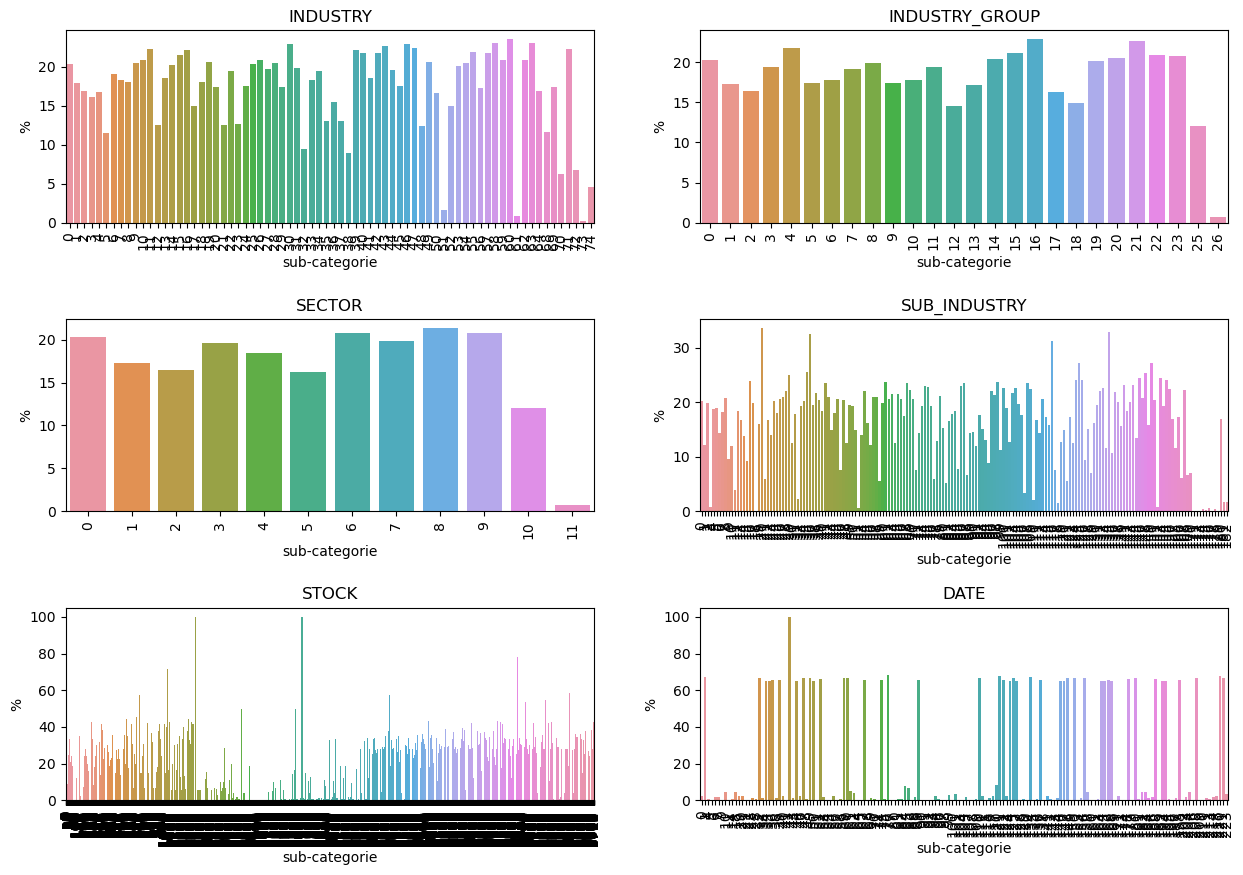

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

for i, categorie in enumerate(['INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY', 'STOCK', 'DATE']):
    plt.subplot(3, 2, i + 1)
    plt.title(categorie)
    
    # Calculate the percentage of NaN values per sub-category
    nan_percentages = [
        (cleaned_train[cleaned_train[categorie] == sub_categorie].isna().sum(axis=1) > 0).sum() / 
        len(cleaned_train[cleaned_train[categorie] == sub_categorie]) * 100 
        for sub_categorie in cleaned_train[categorie].sort_values().unique()
    ]
    
    sns.barplot(x=cleaned_train[categorie].sort_values().unique(), y=nan_percentages)
    
    plt.xlabel('sub-categorie')
    plt.ylabel('%')
    plt.xticks(rotation=90)

plt.show()


**Analysis of NaN Values Distribution**

The plots show the distribution of NaN values per sub-category in percentage. We can see a fairly even distribution of NaN values for the categorical variable `SECTOR`, while the amount of NaN values for the other categorical variables appears to be more equally spread out. 

It might be insightful to check if there are rows that predominantly consist of NaN values (especially for the descriptive variables `RET` and `VOLUME`). If such rows exist, we can drop them in good faith as these columns do not provide value in understanding the underlying structure. 

During this investigation, I noticed the following:

- Given no observed returns, there is no volume observed. Therefore, we should only delete those observations where no return has been observed over the past 5 days. I chose a 5-day window since I am using the observations of the past 5 days in my prediction.


In [6]:
return_features = [f'RET_{day}' for day in range(1,6)]
return_to_drop = cleaned_train[(cleaned_train[return_features].isna().sum(axis=1)/(cleaned_train[return_features].shape[1]) >= 1)][return_features]
return_to_drop

RET_1  RET_2  RET_3  RET_4  RET_5
ID                                       
2237      NaN    NaN    NaN    NaN    NaN
19916     NaN    NaN    NaN    NaN    NaN
20232     NaN    NaN    NaN    NaN    NaN
27739     NaN    NaN    NaN    NaN    NaN
28578     NaN    NaN    NaN    NaN    NaN
...       ...    ...    ...    ...    ...
401583    NaN    NaN    NaN    NaN    NaN
401584    NaN    NaN    NaN    NaN    NaN
401585    NaN    NaN    NaN    NaN    NaN
401586    NaN    NaN    NaN    NaN    NaN
401590    NaN    NaN    NaN    NaN    NaN

[2256 rows x 5 columns]

There are 2,256 rows that do not provide any value to our dataset, as these rows contain only NaN values for both `RET` and `VOLUME`. Therefore, I will proceed to drop these rows.

Dropping the corresponding rows:


In [7]:
cleaned_train.drop(index=return_to_drop.index, inplace=True)

In [8]:
(cleaned_train.isna().sum()/len(cleaned_train)*100)

DATE               0.000000
STOCK              0.000000
INDUSTRY           0.000000
INDUSTRY_GROUP     0.000000
SECTOR             0.000000
SUB_INDUSTRY       0.000000
RET_1              0.024739
VOLUME_1          15.076416
RET_2              0.050199
VOLUME_2          15.403313
RET_3              0.060287
VOLUME_3          15.747504
RET_4              0.069174
VOLUME_4          16.510824
RET_5              0.078782
VOLUME_5          17.398562
RET                0.000000
dtype: float64

We still have quite a few missing values, let's see what is the best way to bo about it to fill these:

In [9]:
num_cols= [f'RET_{i}' for i in range(1, 6)] + [f'VOLUME_{i}' for i in range(1, 6)]


In [10]:
cleaned_train[num_cols].describe()

RET_1          RET_2          RET_3          RET_4  \
count  416236.000000  416130.000000  416088.000000  416051.000000   
mean        0.001383       0.000973       0.002153      -0.000679   
std         0.031311       0.030987       0.031332       0.031224   
min        -0.845324      -0.770751      -0.740406      -0.863554   
25%        -0.010970      -0.011312      -0.009769      -0.012798   
50%         0.000637       0.000401       0.000909      -0.000495   
75%         0.012950       0.012326       0.012835       0.010813   
max         1.444990       1.427746       3.086617       2.243749   

               RET_5       VOLUME_1       VOLUME_2       VOLUME_3  \
count  416011.000000  353570.000000  352209.000000  350776.000000   
mean        0.000358      -0.071502      -0.075230      -0.097235   
std         0.031886       3.038658       2.635549       2.490831   
min        -0.792839      -2.434414      -3.007262      -3.370420   
25%        -0.012249      -0.555394      -0.540629      -0.534880   
50%         0.000000      -0.282609      -0.278437      -0.278277   
75%         0.011309       0.047759       0.041177       0.032378   
max         1.491705    1232.174009     632.268279     938.408298   

            VOLUME_4       VOLUME_5  
count  347598.000000  343902.000000  
mean       -0.088976      -0.092163  
std         1.730786       1.848977  
min        -2.390423      -1.810006  
25%        -0.524475      -0.543178  
50%        -0.275435      -0.281238  
75%         0.028775       0.029057  
max       440.871746     452.669715

**Outliers**

Let's check for outliers. Since, from above, Volumes' stardard deviations are significantly larger than returns on average, I am concerned for **outliers**.

To properly visualize outliers, let's do boxplots.

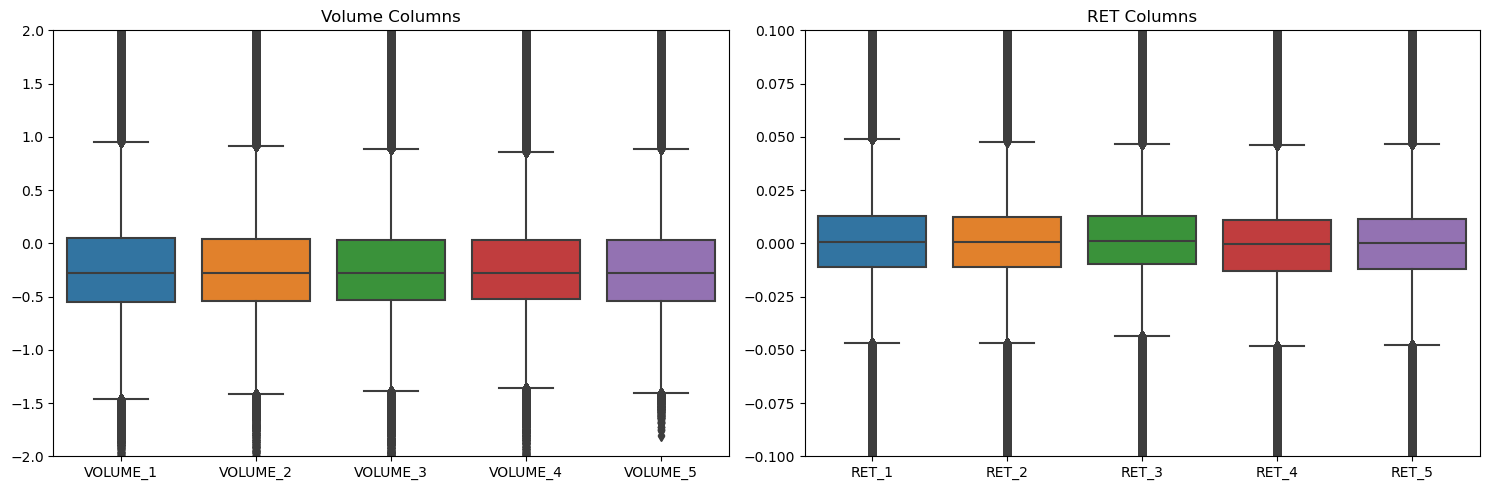

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the lists using list comprehension
ret_columns = [f'RET_{i}' for i in range(1, 6)]
volume_columns = [f'VOLUME_{i}' for i in range(1, 6)]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Boxplot for volume columns
sns.boxplot(data=cleaned_train[volume_columns], ax=axs[0])
axs[0].set_ylim((-2, 2))
axs[0].set_title('Volume Columns')

# Boxplot for ret columns
sns.boxplot(data=cleaned_train[ret_columns], ax=axs[1])
axs[1].set_ylim((-0.1, 0.1))
axs[1].set_title('RET Columns')

# Show the plots
plt.tight_layout()
plt.show()


**Class Imbalance**:

Let's check for class  imbalance.

In [12]:
train['RET'].value_counts(normalize=True)*100

RET
False    50.107861
True     49.892139
Name: proportion, dtype: float64

No class imbalance, hence a weighted loss in our training might not be needed.

**Correlation**

Let's check correlation between features.

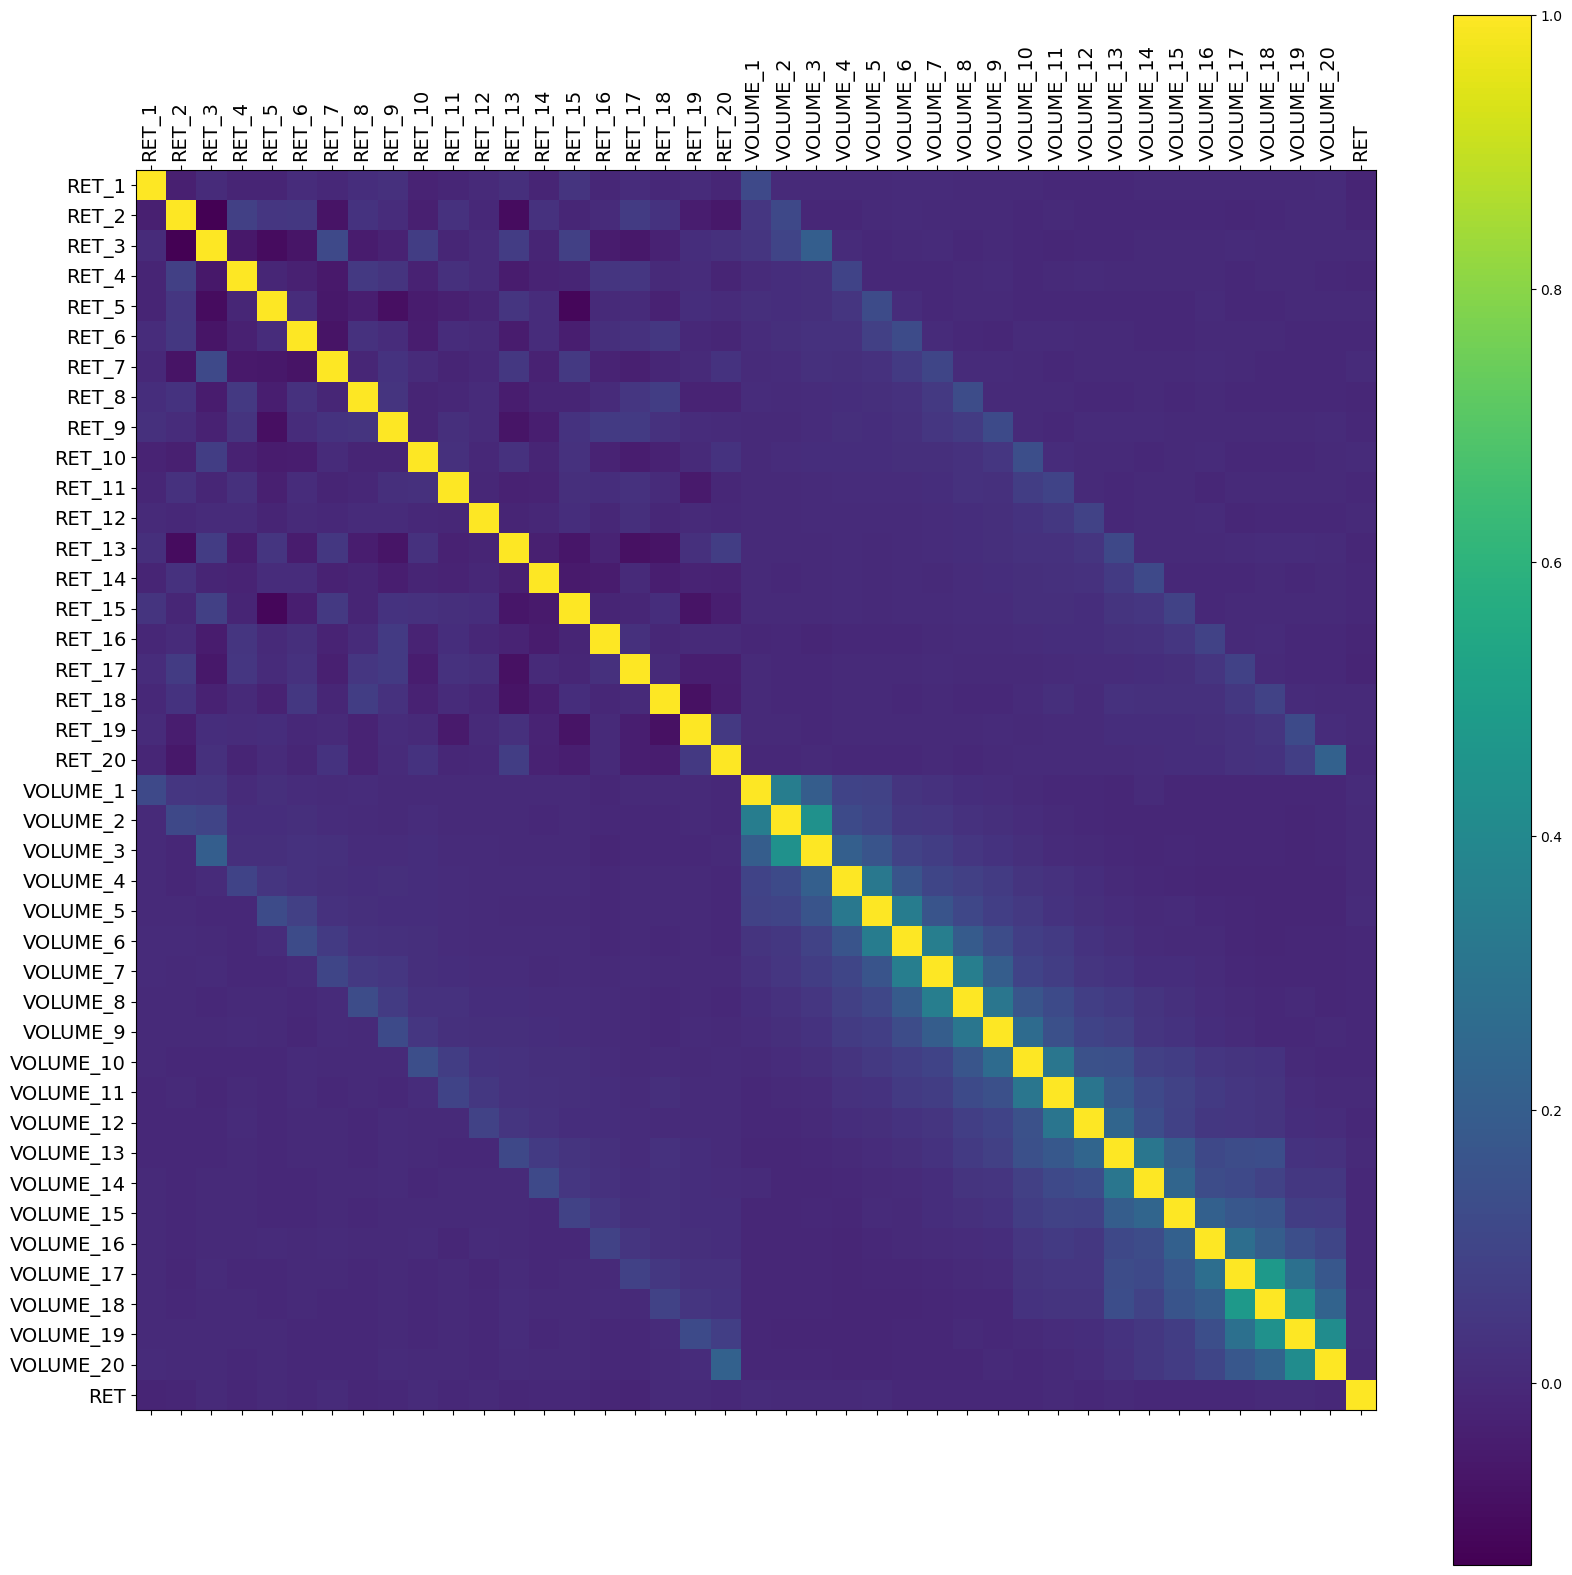

In [13]:
features = [f'RET_{day}' for day in range(1,21)]
features += [f'VOLUME_{day}' for day in range(1,21)]
features += ['RET']

fig = plt.figure(figsize=(20,20))
plt.matshow(train[features].corr(), fignum=fig.number)
plt.xticks(range(train[features].shape[1]), train[features].columns, rotation=90, fontsize=14)
plt.yticks(range(train[features].shape[1]), train[features].columns, fontsize=14)
plt.colorbar()
plt.show()

**Filling the Missing Values**

Based on the above, I wil fill the missing values with median and not mean.

In [14]:
ret_columns = [f'RET_{day}' for day in range(1,6)]
dropping = train[(train[ret_columns].isna().sum(axis=1)/(train[ret_columns].shape[1]) >= 1)][ret_columns]

train.drop(index=dropping.index, inplace=True) 

In [15]:
for column in [f'VOLUME_{day}' for day in range(1,21)]:
    train[column] = train[column].fillna(train[column].median())
    test[column] = test[column].fillna(test[column].median())

In [16]:
for column in [f'RET_{day}' for day in range(1,21)]:
    train[column] = train[column].fillna(train[column].median())
    test[column] = test[column].fillna(test[column].median())

In [17]:
test.shape

(198429, 46)

In [18]:
test

DATE  STOCK  INDUSTRY  INDUSTRY_GROUP  SECTOR  SUB_INDUSTRY     RET_1  \
ID                                                                              
418595     2      0        37              12       5            94  0.020208   
418596     2      1        15               4       3            37  0.009134   
418597     2      4        57              20       8           142  0.005008   
418598     2      5        35              12       5            91  0.015370   
418599     2      6        57              20       8           142  0.011419   
...      ...    ...       ...             ...     ...           ...       ...   
617019   222   5707        52              18       7           122  0.010188   
617020   222   5710        33              10       4            83 -0.000838   
617021   222   5714        49              17       7           113  0.005941   
617022   222   5715        56              20       8           138  0.001775   
617023   222   5716        50              17       7           114 -0.008352   

        VOLUME_1     RET_2  VOLUME_2  ...    RET_16  VOLUME_16    RET_17  \
ID                                    ...                                  
418595  0.146176  0.010059  0.224756  ...  0.022364  -0.301163 -0.001035   
418596 -0.251631  0.021913 -0.712515  ... -0.002062  -0.679724 -0.001544   
418597 -0.115845  0.005914 -0.107441  ...  0.004458  -0.451590  0.011481   
418598 -0.090295 -0.013738  0.048465  ... -0.010984  -0.039714  0.037018   
418599 -0.289027  0.022807 -0.262690  ...  0.001045  -0.565747  0.004304   
...          ...       ...       ...  ...       ...        ...       ...   
617019 -0.476830 -0.006419 -0.534137  ... -0.001028  -0.515748  0.019115   
617020 -0.063269 -0.026928  0.532781  ... -0.007136  -0.203097  0.032965   
617021 -0.506350 -0.016363 -0.173802  ... -0.016931   0.340198  0.002121   
617022 -0.530113 -0.014214 -0.272365  ...  0.019386   2.046782  0.023299   
617023 -0.506224  0.006073 -0.508414  ... -0.007219  -0.002671  0.009992   

        VOLUME_17    RET_18  VOLUME_18    RET_19  VOLUME_19    RET_20  \
ID                                                                      
418595  -0.416533 -0.000148  -0.004548 -0.000148  -0.161792  0.016997   
418596  -0.408979  0.001546   0.396372 -0.007875  -0.431760  0.001742   
418597  -0.536967  0.009520  -0.368585  0.000000   0.022713 -0.002066   
418598   0.665132 -0.003097   0.141991 -0.008191  -0.172382  0.005145   
418599  -0.506291 -0.026469  -0.280666  0.010743   0.365773 -0.011134   
...           ...       ...        ...       ...        ...       ...   
617019   0.361119 -0.002090  -0.132224  0.015389  -0.014298 -0.008680   
617020   0.108639  0.013488  -0.458271  0.019894  -0.353293  0.013513   
617021   1.087437 -0.012910   1.791362 -0.057857   6.330687 -0.000493   
617022   0.229290 -0.020338   0.061626  0.022176  -0.414312 -0.000692   
617023  -0.250345 -0.007770   0.408225  0.027816   0.269808  0.009172   

        VOLUME_20  
ID                 
418595  -0.007221  
418596  -0.574228  
418597  -0.207362  
418598  -0.353172  
418599   0.933284  
...           ...  
617019   0.128657  
617020  -0.219671  
617021   1.175063  
617022  -0.293960  
617023   0.291961  

[198429 rows x 46 columns]

In [19]:
train

DATE  STOCK  INDUSTRY  INDUSTRY_GROUP  SECTOR  SUB_INDUSTRY     RET_1  \
ID                                                                              
0          0      2        18               5       3            44 -0.015748   
1          0      3        43              15       6           104  0.003984   
2          0      4        57              20       8           142  0.000440   
3          0      8         1               1       1             2  0.031298   
4          0     14        36              12       5            92  0.027273   
...      ...    ...       ...             ...     ...           ...       ...   
418590   223   5703        32              10       4            77  0.021843   
418591   223   5705        35              12       5            91 -0.006920   
418592   223   5709         2               1       1             5  0.021869   
418593   223   5710        33              10       4            83  0.012248   
418594   223   5713        26               7       4            60  0.076162   

        VOLUME_1     RET_2  VOLUME_2  ...  VOLUME_16    RET_17  VOLUME_17  \
ID                                    ...                                   
0       0.147931 -0.015504  0.179183  ...   0.630899  0.003254  -0.379412   
1      -0.282609 -0.090580 -0.278437  ...  -0.272271  0.003774  -0.285480   
2      -0.096282 -0.058896  0.084771  ...  -0.010336 -0.017612  -0.354333   
3      -0.429540  0.007756 -0.089919  ...   0.012105  0.033824  -0.290178   
4      -0.847155 -0.039302 -0.943033  ...  -0.277083 -0.012659   0.139086   
...          ...       ...       ...  ...        ...       ...        ...   
418590 -0.217823 -0.021703 -0.125333  ...  -0.161543  0.007785  -0.141487   
418591 -0.375251  0.000000 -0.029437  ...  -0.955492 -0.016221  -0.171172   
418592 -0.978856 -0.005929 -1.026267  ...  -0.476550  0.029714  -0.385972   
418593 -0.627169  0.010925 -0.842108  ...  -0.210079  0.023729   0.813948   
418594 -1.325986 -0.000988  0.198856  ...   0.277896 -0.037037   0.056942   

          RET_18  VOLUME_18    RET_19  VOLUME_19    RET_20  VOLUME_20    RET  
ID                                                                            
0       0.008752  -0.110597 -0.012959   0.174521 -0.002155  -0.000937   True  
1      -0.018518  -0.281753 -0.028777  -0.277674 -0.034722  -0.283405   True  
2      -0.006562  -0.519391 -0.012101  -0.356157 -0.006867  -0.308868  False  
3      -0.001468  -0.663834 -0.013520  -0.562126 -0.036745  -0.631458  False  
4       0.004237  -0.017547  0.004256   0.579510 -0.040817   0.802806  False  
...          ...        ...       ...        ...       ...        ...    ...  
418590  0.008205  -0.268215 -0.058448   0.057577  0.031174  -0.163350  False  
418591  0.007819   1.540184 -0.015396  -0.502337 -0.011073   0.632885  False  
418592 -0.069148   1.780169 -0.082927   1.581453  0.098607   6.956960   True  
418593  0.026087  -0.868576 -0.051155   0.371052  0.041238   0.045695   True  
418594 -0.001896  -0.521932 -0.008366  -0.377668  0.003679  -1.393662  False  

[416339 rows x 47 columns]

# EDA Exploratory Data Analysis

Let's look at stock return and volume distributions!  These can be quite telling of how our entire dataset looks like.

In [21]:
df = train.copy()


# Now proceed with your plotting code
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

# Dropdown to select stock
stock_dropdown = widgets.Dropdown(
    options=df['STOCK'].unique(),
    description='Stock:',
    disabled=False,
)

# Function to update the plot
def update_plot(stock):
    stock_df = df[df['STOCK'] == stock]
    fig, axes = plt.subplots(2, 5, figsize=(18, 12))
    
    # Plotting RET_1 to RET_5
    for i in range(5):
        sns.histplot(stock_df[f'RET_{i+1}'], bins=50, kde=True, ax=axes[0, i])
        axes[0, i].set_title(f'Distribution of {stock} Returns (RET_{i+1})')
        axes[0, i].set_xlabel(f'RET_{i+1}')
        axes[0, i].set_ylabel('Frequency')
    
    # Plotting VOLUME_1 to VOLUME_5
    for i in range(5):
        sns.histplot(stock_df[f'VOLUME_{i+1}'], bins=50, kde=True, ax=axes[1, i])
        axes[1, i].set_title(f'Distribution of {stock} Volume (VOLUME_{i+1})')
        axes[1, i].set_xlabel(f'VOLUME_{i+1}')
        axes[1, i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Link the dropdown to the update function
interactive_plot = widgets.interactive(update_plot, stock=stock_dropdown)
display(interactive_plot)


interactive(children=(Dropdown(description='Stock:', options=(2, 3, 4, 8, 14, 23, 45, 59, 60, 65, 72, 84, 86, …

**Log**

Let's look at log returns and volumes

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

# Load your dataset
df = train.copy()

# Function to update the plot
def update_plot(stock):
    stock_df = df[df['STOCK'] == stock]
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    sns.histplot(stock_df['RET_1'], bins=50, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title(f'Distribution of {stock} Returns (RET_1)')
    axes[0, 0].set_xlabel('RET_1')
    axes[0, 0].set_ylabel('Frequency')

    sns.histplot(stock_df['VOLUME_1'], bins=50, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title(f'Distribution of {stock} Volume (VOLUME_1)')
    axes[0, 1].set_xlabel('VOLUME_1')
    axes[0, 1].set_ylabel('Frequency')

    sns.histplot(np.log(stock_df['RET_1'].replace(0, np.nan)).dropna(), bins=50, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title(f'Distribution of Log {stock} Returns (Log(RET_1))')
    axes[1, 0].set_xlabel('Log(RET_1)')
    axes[1, 0].set_ylabel('Frequency')

    sns.histplot(np.log(stock_df['VOLUME_1'].replace(0, np.nan)).dropna(), bins=50, kde=True, ax=axes[1, 1])
    axes[1, 1].set_title(f'Distribution of Log {stock} Volume (Log(VOLUME_1))')
    axes[1, 1].set_xlabel('Log(VOLUME_1)')
    axes[1, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Dropdown to select stock
stock_dropdown = widgets.Dropdown(
    options=df['STOCK'].unique(),
    description='Stock:',
    disabled=False,
)

# Link the dropdown to the update function
interactive_plot = widgets.interactive(update_plot, stock=stock_dropdown)
display(interactive_plot)


interactive(children=(Dropdown(description='Stock:', options=(2, 3, 4, 8, 14, 23, 45, 59, 60, 65, 72, 84, 86, …

**Comment**
In the code above we have a dropdown menu where we can select the stock and have look at the distributions of RET_1 to 5 and VOLUME_1 to 5.

We cannot click 1 by 1 across 5k stocks, so let's have a macro view per SECTOR and INDUSTRY now.

**Stats EDA per SECTOR and INDUSTRY**

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# Load your dataset
df = train.copy()

# Function to calculate skewness and kurtosis
def calc_skew_kurt(stock_df):
    skewness_ret = skew(stock_df['RET_1'])
    kurt_ret = kurtosis(stock_df['RET_1'])
    skewness_vol = skew(stock_df['VOLUME_1'])
    kurt_vol = kurtosis(stock_df['VOLUME_1'])
    return skewness_ret, kurt_ret, skewness_vol, kurt_vol

# Calculate skewness and kurtosis for each stock
stock_stats = df.groupby('STOCK').apply(lambda x: pd.Series({
    'Skewness_RET': calc_skew_kurt(x)[0],
    'Kurtosis_RET': calc_skew_kurt(x)[1],
    'Skewness_VOLUME': calc_skew_kurt(x)[2],
    'Kurtosis_VOLUME': calc_skew_kurt(x)[3]
})).reset_index()

# Calculate average skewness and kurtosis per sector and industry
sector_stats = df.groupby('SECTOR').apply(lambda x: pd.Series({
    'Average Skewness_RET': calc_skew_kurt(x)[0],
    'Average Kurtosis_RET': calc_skew_kurt(x)[1],
    'Average Skewness_VOLUME': calc_skew_kurt(x)[2],
    'Average Kurtosis_VOLUME': calc_skew_kurt(x)[3]
})).reset_index()

industry_stats = df.groupby('INDUSTRY').apply(lambda x: pd.Series({
    'Average Skewness_RET': calc_skew_kurt(x)[0],
    'Average Kurtosis_RET': calc_skew_kurt(x)[1],
    'Average Skewness_VOLUME': calc_skew_kurt(x)[2],
    'Average Kurtosis_VOLUME': calc_skew_kurt(x)[3]
})).reset_index()

/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/2246526377.py:13: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness_vol = skew(stock_df['VOLUME_1'])
/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/2246526377.py:14: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_vol = kurtosis(stock_df['VOLUME_1'])
/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/2246526377.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to sile

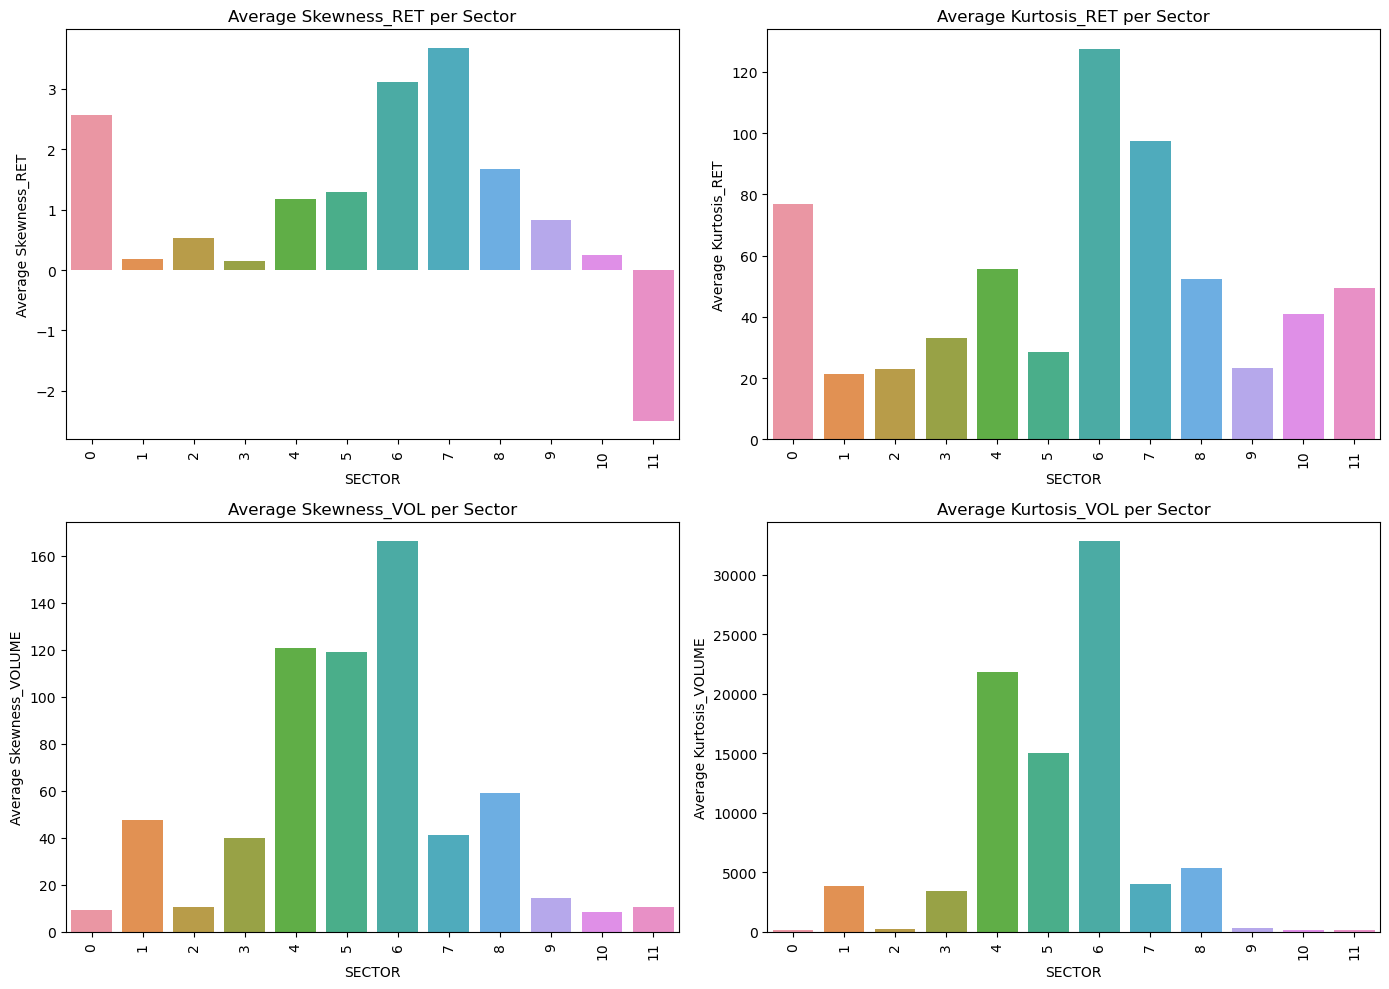

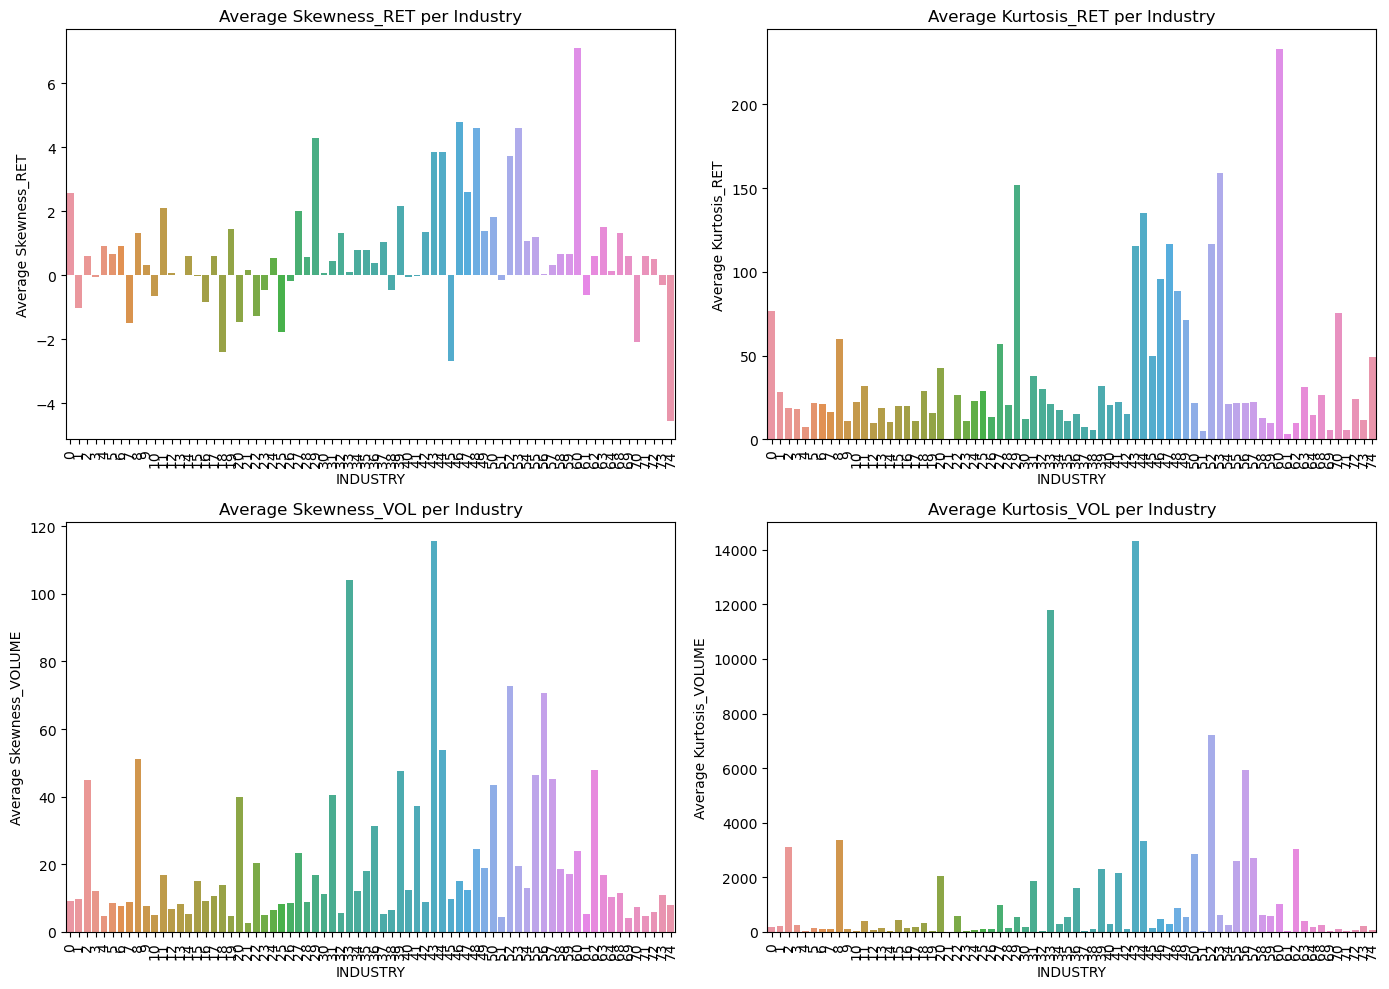

In [24]:
# Plotting sector and industry statistics
def plot_sector_industry_stats():
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    sns.barplot(x='SECTOR', y='Average Skewness_RET', data=sector_stats, ax=axes[0, 0])
    axes[0, 0].set_title('Average Skewness_RET per Sector')
    axes[0, 0].tick_params(axis='x', rotation=90)

    sns.barplot(x='SECTOR', y='Average Kurtosis_RET', data=sector_stats, ax=axes[0, 1])
    axes[0, 1].set_title('Average Kurtosis_RET per Sector')
    axes[0, 1].tick_params(axis='x', rotation=90)

    sns.barplot(x='SECTOR', y='Average Skewness_VOLUME', data=sector_stats, ax=axes[1, 0])
    axes[1, 0].set_title('Average Skewness_VOL per Sector')
    axes[1, 0].tick_params(axis='x', rotation=90)

    sns.barplot(x='SECTOR', y='Average Kurtosis_VOLUME', data=sector_stats, ax=axes[1, 1])
    axes[1, 1].set_title('Average Kurtosis_VOL per Sector')
    axes[1, 1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    sns.barplot(x='INDUSTRY', y='Average Skewness_RET', data=industry_stats, ax=axes[0, 0])
    axes[0, 0].set_title('Average Skewness_RET per Industry')
    axes[0, 0].tick_params(axis='x', rotation=90)

    sns.barplot(x='INDUSTRY', y='Average Kurtosis_RET', data=industry_stats, ax=axes[0, 1])
    axes[0, 1].set_title('Average Kurtosis_RET per Industry')
    axes[0, 1].tick_params(axis='x', rotation=90)

    sns.barplot(x='INDUSTRY', y='Average Skewness_VOLUME', data=industry_stats, ax=axes[1, 0])
    axes[1, 0].set_title('Average Skewness_VOL per Industry')
    axes[1, 0].tick_params(axis='x', rotation=90)

    sns.barplot(x='INDUSTRY', y='Average Kurtosis_VOLUME', data=industry_stats, ax=axes[1, 1])
    axes[1, 1].set_title('Average Kurtosis_VOL per Industry')
    axes[1, 1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

# Call the function to plot the sector and industry stats
plot_sector_industry_stats()

### **Explanation of the Graphs**

The graphs show the average skewness and kurtosis for `RET` (returns) and `VOLUME` (volume) across different sectors and industries. Skewness measures the asymmetry of the distribution of values, while kurtosis measures the "tailedness" or the propensity for extreme values. Here are the details:

1. **Top Row (Sector Level)**:
   - **Average Skewness of RET per Sector**: Shows how the returns' distributions are skewed (left or right) for each sector.
   - **Average Kurtosis of RET per Sector**: Shows the propensity for extreme return values in each sector.
   - **Average Skewness of VOLUME per Sector**: Shows how the volumes' distributions are skewed (left or right) for each sector.
   - **Average Kurtosis of VOLUME per Sector**: Shows the propensity for extreme volume values in each sector.

2. **Bottom Row (Industry Level)**:
   - **Average Skewness of RET per Industry**: Shows how the returns' distributions are skewed for each industry.
   - **Average Kurtosis of RET per Industry**: Shows the propensity for extreme return values in each industry.
   - **Average Skewness of VOLUME per Industry**: Shows how the volumes' distributions are skewed for each industry.
   - **Average Kurtosis of VOLUME per Industry**: Shows the propensity for extreme volume values in each industry.

### Mathematical Explanation

1. **Skewness**:
   - **Formula**: $$ \text{Skewness} = \frac{E[(X - \mu)^3]}{\sigma^3} $$
   - **Interpretation**: A measure of the asymmetry of the probability distribution of a real-valued random variable. Positive skewness indicates a distribution with an asymmetric tail extending toward more positive values, while negative skewness indicates a tail extending toward more negative values.

2. **Kurtosis**:
   - **Formula**: $$ \text{Kurtosis} = \frac{E[(X - \mu)^4]}{\sigma^4} $$
   - **Interpretation**: A measure of the "tailedness" of the probability distribution. High kurtosis indicates more outliers (heavier tails), while low kurtosis indicates fewer outliers (lighter tails).

### Comments on Distributions

1. **Sector Level**:
   - **RET Skewness**: Sectors like 5 and 7 have high positive skewness, indicating returns are skewed toward positive values. Sector 11 shows negative skewness.
   - **RET Kurtosis**: Sector 7 has extremely high kurtosis, indicating a high propensity for extreme return values.
   - **VOLUME Skewness**: Sectors 5 and 7 also show high positive skewness in volume, indicating volume data is skewed toward higher values.
   - **VOLUME Kurtosis**: Sector 6 has an extremely high kurtosis, suggesting many extreme volume values.

2. **Industry Level**:
   - **RET Skewness**: Industries have varied skewness, with some showing positive and others negative skewness. This indicates diverse return distributions across industries.
   - **RET Kurtosis**: Certain industries exhibit very high kurtosis, indicating the presence of extreme return values.
   - **VOLUME Skewness**: Similar to returns, volume skewness varies widely across industries.
   - **VOLUME Kurtosis**: Some industries show extremely high kurtosis, suggesting many extreme volume values.

### Comments on Sectors

1. **Sector 7**:
   - **RET Skewness**: High positive skewness suggests that returns are more often positive but with some very high return days.
   - **RET Kurtosis**: Extremely high kurtosis indicates the presence of very high returns on certain days, suggesting volatility.
   - **VOLUME Skewness**: High positive skewness suggests that trading volumes are frequently high.
   - **VOLUME Kurtosis**: High kurtosis indicates that there are days with very high trading volumes, indicating sporadic trading spikes.

2. **Sector 11**:
   - **RET Skewness**: Negative skewness indicates that returns are more often negative.
   - **RET Kurtosis**: Moderate kurtosis suggests fewer extreme return days compared to Sector 7.
   - **VOLUME Skewness**: Relatively low skewness compared to other sectors.
   - **VOLUME Kurtosis**: Low kurtosis indicates more stable trading volumes without significant spikes.

### Comments on Industries

1. **Industry with highest RET Kurtosis**:
   - **Skewness**: The skewness can be either positive or negative, but the high kurtosis indicates a lot of extreme returns.
   - **Kurtosis**: High kurtosis indicates that this industry has a lot of outlier returns, suggesting high volatility and risk.

2. **Industry with highest VOLUME Kurtosis**:
   - **Skewness**: The skewness could be positive, indicating frequent high trading volumes.
   - **Kurtosis**: Very high kurtosis indicates that this industry experiences significant spikes in trading volumes, possibly due to market events or news affecting this industry.

In summary, sectors and industries exhibit different skewness and kurtosis characteristics in both returns and volumes, indicating varying degrees of asymmetry and tail behavior. Some sectors and industries are more prone to extreme values, which can indicate higher risk and volatility.



**Broader Look**

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# Load your dataset
df = train.copy()

# Define a function to calculate required statistics
def calculate_statistics(data):
    stats = {}
    # RETURN
    stats['Mean_RET'] = np.mean(data['RET_1'])
    stats['Skewness_RET'] = skew(data['RET_1'])
    stats['Kurtosis_RET'] = kurtosis(data['RET_1'])
    stats['Std_RET'] = np.std(data['RET_1'])
    stats['Std_of_Std_RET'] = np.std(data['RET_1'].rolling(window=20).std().dropna())

    log_RET_1 = np.log(data['RET_1'].replace(0, np.nan)).dropna()
    log_squared_RET_1 = log_RET_1**2
    stats['Log_Mean_RET'] = np.mean(log_RET_1)
    stats['Log_Skewness_RET'] = skew(log_RET_1)
    stats['Log_Kurtosis_RET'] = kurtosis(log_RET_1)
    stats['Log_Std_RET'] = np.std(log_RET_1)
    stats['Log_Std_of_Std_RET'] = np.std(log_RET_1.rolling(window=20).std().dropna())

    stats['Log_Squared_Skewness_RET'] = skew(log_squared_RET_1)
    stats['Log_Squared_Kurtosis_RET'] = kurtosis(log_squared_RET_1)
    stats['Log_Squared_Std_RET'] = np.std(log_squared_RET_1)
    stats['Log_Squared_Std_of_Std_RET'] = np.std(log_squared_RET_1.rolling(window=20).std().dropna())



    # VOLUME
    stats['Mean_VOLUME'] = np.mean(data['VOLUME_1'])
    stats['Skewness_VOLUME'] = skew(data['VOLUME_1'])
    stats['Kurtosis_VOLUME'] = kurtosis(data['VOLUME_1'])
    stats['Std_VOLUME'] = np.std(data['VOLUME_1'])
    stats['Std_of_Std_VOLUME'] = np.std(data['VOLUME_1'].rolling(window=20).std().dropna())

    log_VOLUME_1 = np.log(data['VOLUME_1'].replace(0, np.nan)).dropna()
    log_squared_VOLUME_1 = log_VOLUME_1**2
    stats['Log_Mean_VOLUME'] = np.mean(log_VOLUME_1)
    stats['Log_Skewness_VOLUME'] = skew(log_VOLUME_1)
    stats['Log_Kurtosis_VOLUME'] = kurtosis(log_VOLUME_1)
    stats['Log_Std_VOLUME'] = np.std(log_VOLUME_1)
    stats['Log_Std_of_Std_VOLUME'] = np.std(log_VOLUME_1.rolling(window=20).std().dropna())
    stats['Log_Squared_Skewness_VOLUME'] = skew(log_squared_VOLUME_1)
    stats['Log_Squared_Kurtosis_VOLUME'] = kurtosis(log_squared_VOLUME_1)
    stats['Log_Squared_Std_VOLUME'] = np.std(log_squared_VOLUME_1)
    stats['Log_Squared_Std_of_Std_VOLUME'] = np.std(log_squared_VOLUME_1.rolling(window=20).std().dropna())

    return pd.Series(stats)

# Calculate statistics for each sector and industry
sector_stats = df.groupby('SECTOR').apply(calculate_statistics).reset_index()
industry_stats = df.groupby('INDUSTRY').apply(calculate_statistics).reset_index()

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/4070037874.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sector_stats = df.groupby('SECTOR').apply(calculate_statistics).reset_index()
/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/4070037874.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grou

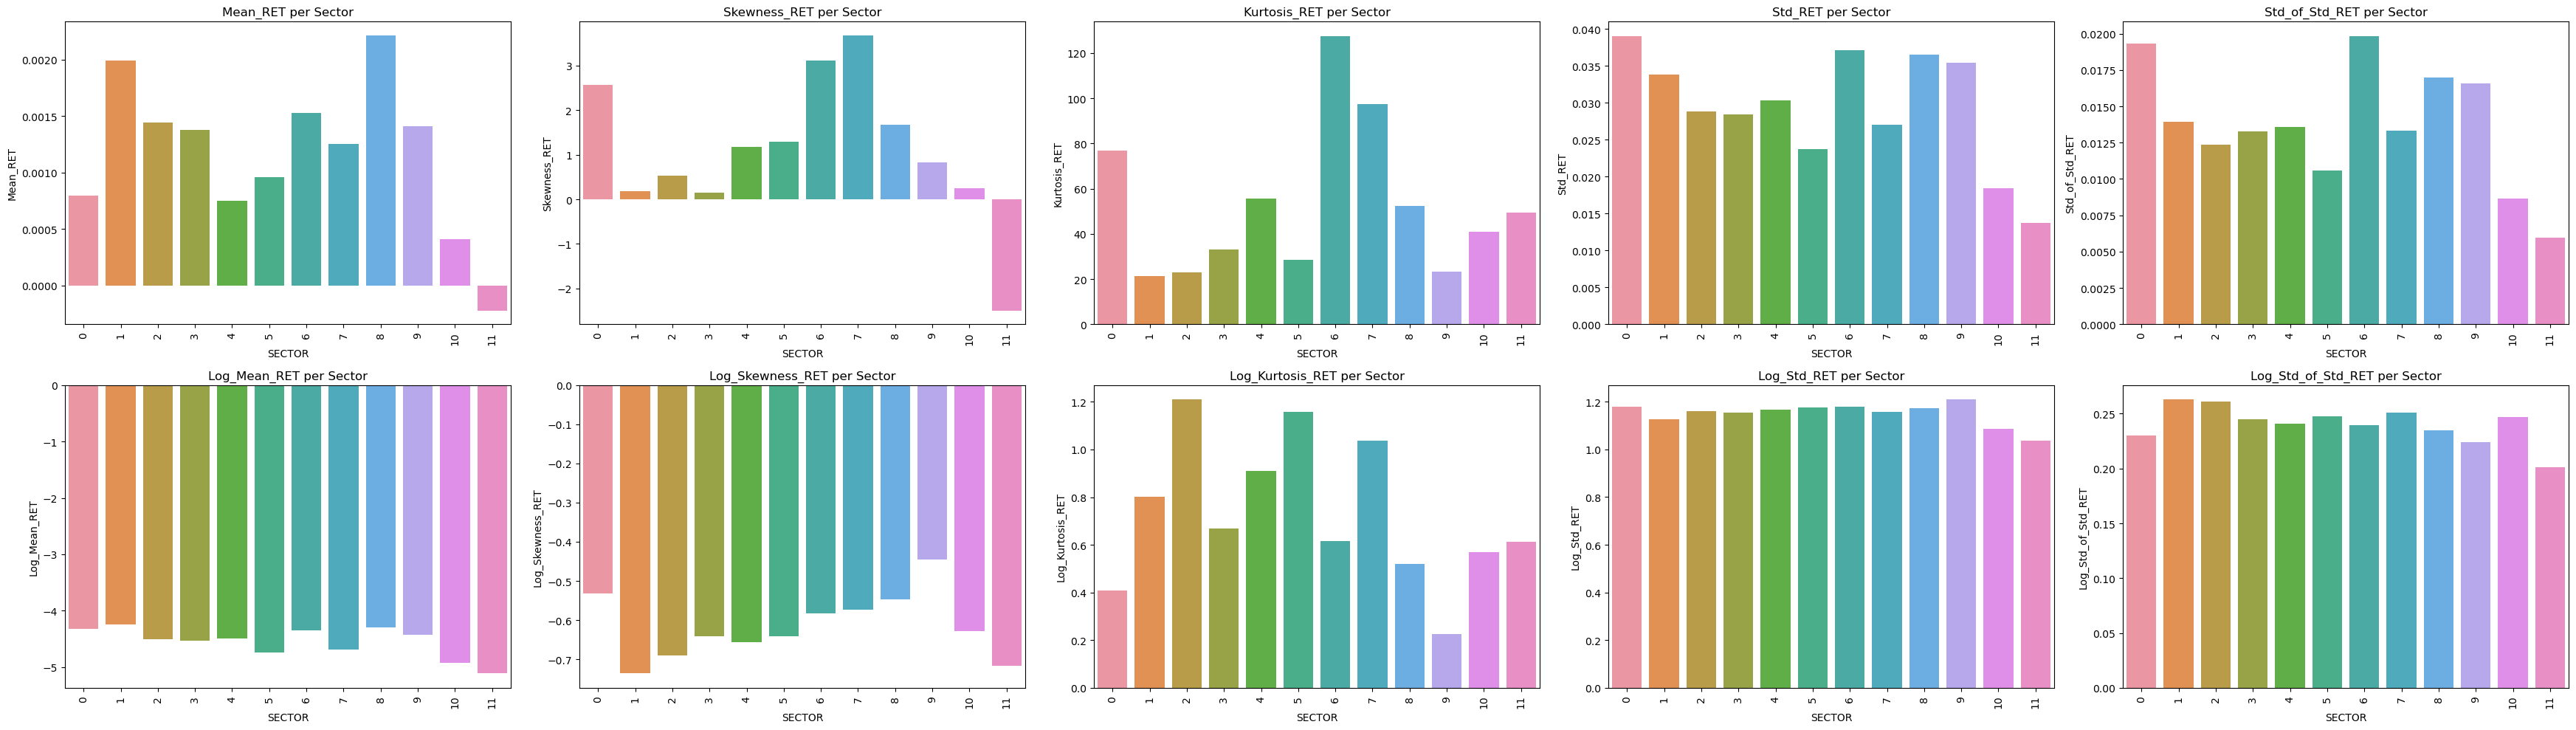

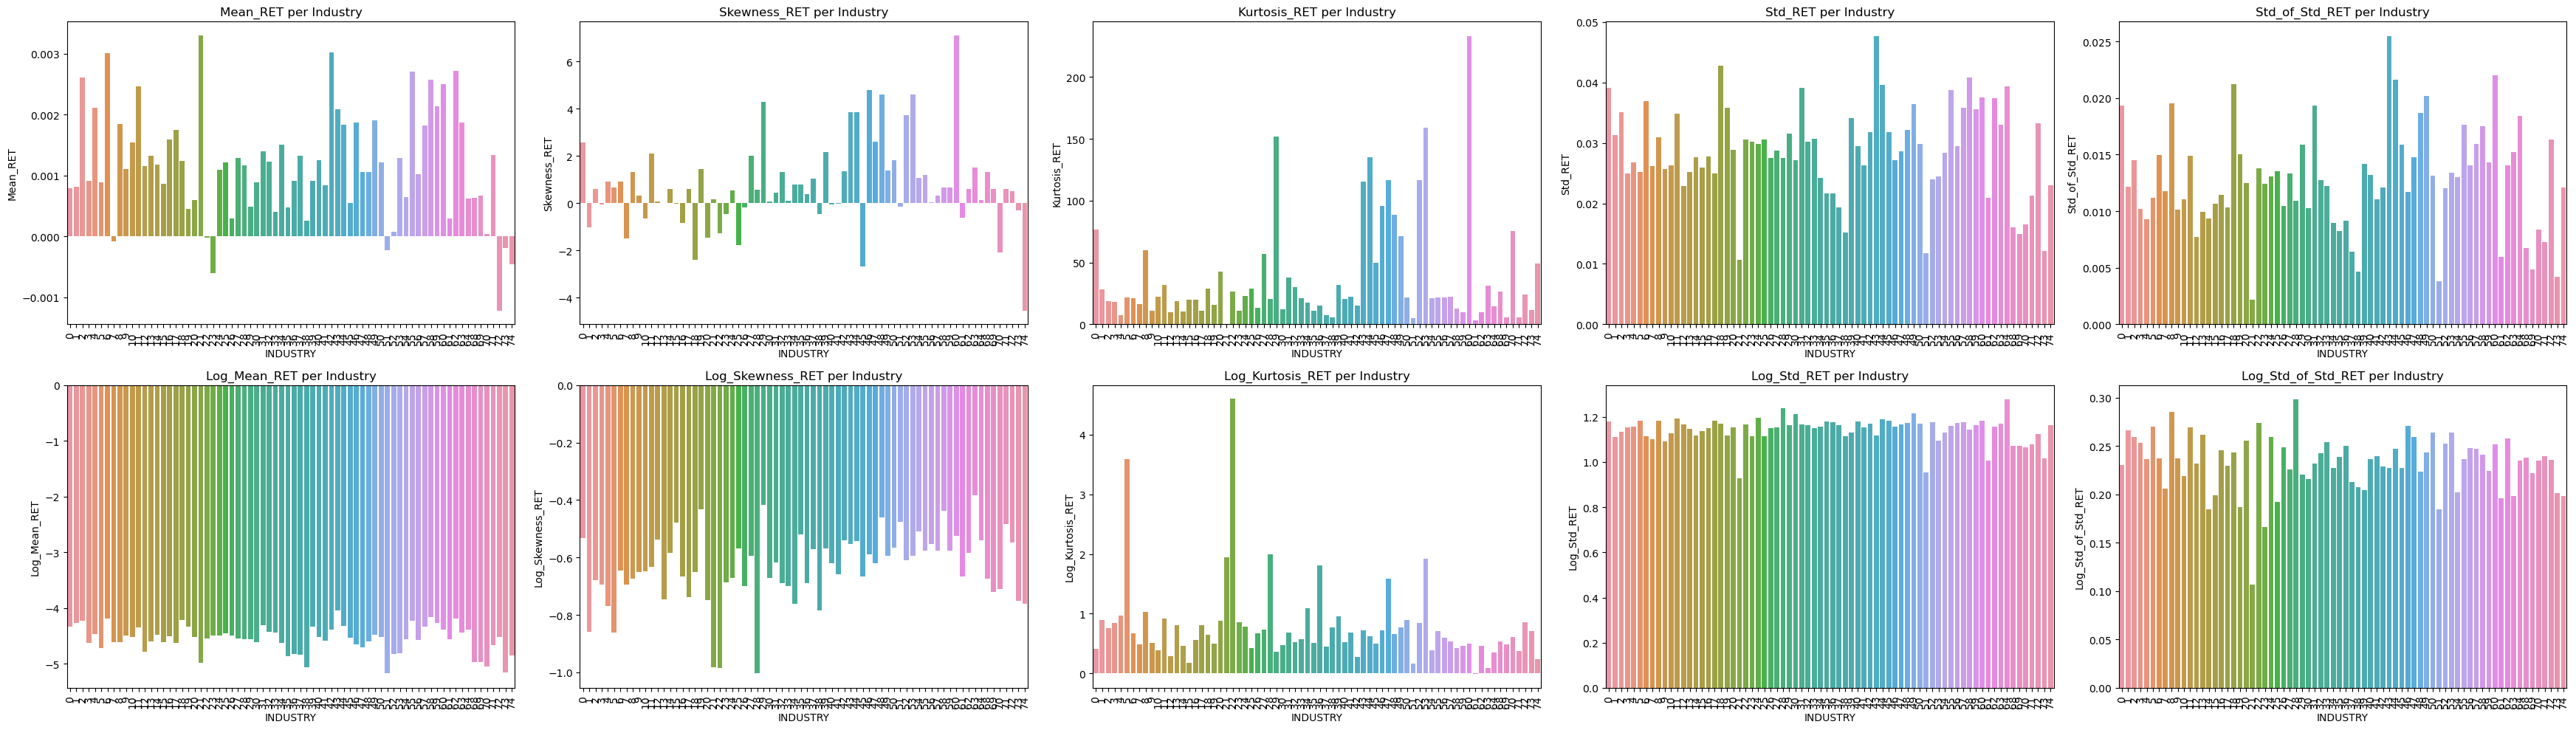

In [26]:
# Define a function to plot the statistics
def plot_sector_industry_stats():
    # Plot sector statistics
    fig, axes = plt.subplots(2, 5, figsize=(35, 10))

    sns.barplot(x='SECTOR', y='Mean_RET', data=sector_stats, ax=axes[0, 0])
    axes[0, 0].set_title('Mean_RET per Sector')
    axes[0, 0].tick_params(axis='x', rotation=90)

    sns.barplot(x='SECTOR', y='Skewness_RET', data=sector_stats, ax=axes[0, 1])
    axes[0, 1].set_title('Skewness_RET per Sector')
    axes[0, 1].tick_params(axis='x', rotation=90)

    sns.barplot(x='SECTOR', y='Kurtosis_RET', data=sector_stats, ax=axes[0, 2])
    axes[0, 2].set_title('Kurtosis_RET per Sector')
    axes[0, 2].tick_params(axis='x', rotation=90)

    sns.barplot(x='SECTOR', y='Std_RET', data=sector_stats, ax=axes[0, 3])
    axes[0, 3].set_title('Std_RET per Sector')
    axes[0, 3].tick_params(axis='x', rotation=90)

    sns.barplot(x='SECTOR', y='Std_of_Std_RET', data=sector_stats, ax=axes[0, 4])
    axes[0, 4].set_title('Std_of_Std_RET per Sector')
    axes[0, 4].tick_params(axis='x', rotation=90)

    sns.barplot(x='SECTOR', y='Log_Mean_RET', data=sector_stats, ax=axes[1, 0])
    axes[1, 0].set_title('Log_Mean_RET per Sector')
    axes[1, 0].tick_params(axis='x', rotation=90)

    sns.barplot(x='SECTOR', y='Log_Skewness_RET', data=sector_stats, ax=axes[1, 1])
    axes[1, 1].set_title('Log_Skewness_RET per Sector')
    axes[1, 1].tick_params(axis='x', rotation=90)

    sns.barplot(x='SECTOR', y='Log_Kurtosis_RET', data=sector_stats, ax=axes[1, 2])
    axes[1, 2].set_title('Log_Kurtosis_RET per Sector')
    axes[1, 2].tick_params(axis='x', rotation=90)

    sns.barplot(x='SECTOR', y='Log_Std_RET', data=sector_stats, ax=axes[1, 3])
    axes[1, 3].set_title('Log_Std_RET per Sector')
    axes[1, 3].tick_params(axis='x', rotation=90)

    sns.barplot(x='SECTOR', y='Log_Std_of_Std_RET', data=sector_stats, ax=axes[1, 4])
    axes[1, 4].set_title('Log_Std_of_Std_RET per Sector')
    axes[1, 4].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

    # Plot industry statistics
    fig, axes = plt.subplots(2, 5, figsize=(35, 10))

    sns.barplot(x='INDUSTRY', y='Mean_RET', data=industry_stats, ax=axes[0, 0])
    axes[0, 0].set_title('Mean_RET per Industry')
    axes[0, 0].tick_params(axis='x', rotation=90)

    sns.barplot(x='INDUSTRY', y='Skewness_RET', data=industry_stats, ax=axes[0, 1])
    axes[0, 1].set_title('Skewness_RET per Industry')
    axes[0, 1].tick_params(axis='x', rotation=90)

    sns.barplot(x='INDUSTRY', y='Kurtosis_RET', data=industry_stats, ax=axes[0, 2])
    axes[0, 2].set_title('Kurtosis_RET per Industry')
    axes[0, 2].tick_params(axis='x', rotation=90)

    sns.barplot(x='INDUSTRY', y='Std_RET', data=industry_stats, ax=axes[0, 3])
    axes[0, 3].set_title('Std_RET per Industry')
    axes[0, 3].tick_params(axis='x', rotation=90)

    sns.barplot(x='INDUSTRY', y='Std_of_Std_RET', data=industry_stats, ax=axes[0, 4])
    axes[0, 4].set_title('Std_of_Std_RET per Industry')
    axes[0, 4].tick_params(axis='x', rotation=90)

    sns.barplot(x='INDUSTRY', y='Log_Mean_RET', data=industry_stats, ax=axes[1, 0])
    axes[1, 0].set_title('Log_Mean_RET per Industry')
    axes[1, 0].tick_params(axis='x', rotation=90)

    sns.barplot(x='INDUSTRY', y='Log_Skewness_RET', data=industry_stats, ax=axes[1, 1])
    axes[1, 1].set_title('Log_Skewness_RET per Industry')
    axes[1, 1].tick_params(axis='x', rotation=90)

    sns.barplot(x='INDUSTRY', y='Log_Kurtosis_RET', data=industry_stats, ax=axes[1, 2])
    axes[1, 2].set_title('Log_Kurtosis_RET per Industry')
    axes[1, 2].tick_params(axis='x', rotation=90)

    sns.barplot(x='INDUSTRY', y='Log_Std_RET', data=industry_stats, ax=axes[1, 3])
    axes[1, 3].set_title('Log_Std_RET per Industry')
    axes[1, 3].tick_params(axis='x', rotation=90)

    sns.barplot(x='INDUSTRY', y='Log_Std_of_Std_RET', data=industry_stats, ax=axes[1, 4])
    axes[1, 4].set_title('Log_Std_of_Std_RET per Industry')
    axes[1, 4].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

# Call the function to plot the sector and industry stats
plot_sector_industry_stats()


# Feature Engineering

The following provides a breakdown of all the feature engineering tasks performed on the dataset, categorized into return-related features and volume-related features. Each feature is listed with a brief description.

#### Return-Related Features

1. **Relative Strength Index (RSI):**
   - Measures the magnitude of recent price changes to evaluate overbought or oversold conditions.

2. **Rate of Change (ROC):**
   - Measures the percentage change between the most recent price and the price n periods ago.

3. **Momentum:**
   - Measures the change in price over a specified period.

4. **Stochastic Oscillator (%K and %D):**
   - Measures the current price relative to the price range over a specified period.

5. **Moving Average Convergence Divergence (MACD):**
   - Measures the difference between the short-term and long-term exponential moving averages (EMA).

6. **Golden Cross**
   - A Golden Cross is a bullish breakout pattern formed from a crossover involving a security's short-term moving average (such as the 10-day moving average) breaking above its long-term moving average (such as the 200-day moving average) or resistance level.


7. **Bollinger Bands:**
   - Measures price volatility by placing bands around a moving average.

8. **Cumulative Return**
   - Cumulative return is the total change in the price of an asset over a period, expressed as a percentage.

9. **Bollinger for Cum Rets**

10. **Money Flow Index (MFI)**

11. **Moving Averages:**
   - **Exponential Moving Average (EMA):** Measures the average price over a specified period with more weight on recent prices.
   - **Simple Moving Average (SMA):** Measures the average price over a specified period.


12. **Average True Range (ATR):**
    - Measures the volatility of a security.




#### Volume-Related Features

1. **Volume Deviation**

2. **Volume Spike Detection**

3. **Accumulation/Distribution Line (ADL):**
   - Measures the cumulative flow of money into and out of a security.

1. **Relative Volume:**
   - Measures trading volume relative to the average volume over a specified period.

2. **On-Balance Volume (OBV):**
   - Measures cumulative volume flow that indicates buying and selling pressure.




This breakdown provides a comprehensive overview of the feature engineering tasks, categorized into return-related and volume-related features.


**New Features List**

In [27]:
new_features = []

**1. Relative Strength Index (RSI)**

The RSI is a momentum oscillator that measures the speed and change of price movements. It oscillates between 0 and 100. Traditionally, RSI is considered overbought when above 70 and oversold when below 30.

**Formula:**
$$ \text{RSI} = 100 - \frac{100}{1 + RS} $$
$$ RS = \frac{\text{Average Gain}}{\text{Average Loss}} $$


In [28]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np

def calculate_rsi(data, window=14):
    """
    Calculate RSI for each stock.

    Args:
    data: pd.DataFrame, containing 'STOCK', 'DATE', and 'RET_i' columns (i from 1 to 20).
    window: int, the lookback period for RSI calculation.

    Returns:
    pd.DataFrame with RSI values for each stock.
    """
    data = data.copy()
    
    # Calculate average gains and losses over the window period
    avg_gain = data.groupby(['STOCK', 'DATE'])[[f'RET_{day}' for day in range(1, window+1)]].mean().agg(lambda x: x[x > 0].mean(), axis=1)
    avg_loss = data.groupby(['STOCK', 'DATE'])[[f'RET_{day}' for day in range(1, window+1)]].mean().agg(lambda x: x[x < 0].mean(), axis=1).abs()

    # Calculate relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    # Convert RSI Series to DataFrame
    rsi_df = rsi.reset_index()
    rsi_df.rename(columns={0: 'RSI'}, inplace=True)



    # Join RSI values back to the original dataframe
    data = data.merge(rsi_df, on=['STOCK', 'DATE'], how='left')

    # Fill NaNs in RSI with the median RSI value for each stock
    data['RSI'] = data.groupby('STOCK')['RSI'].transform(lambda x: x.fillna(x.median()))

    # Add overbought and oversold signals
    data['overbought_rsi'] = np.where(data['RSI'] > 70, 1, 0)
    data['oversold_rsi'] = np.where(data['RSI'] < 30, 1, 0)





    return data


In [29]:
new_features.append('RSI')
new_features.append('overbought_rsi')
new_features.append('oversold_rsi')

In [30]:
train = calculate_rsi(train)
test = calculate_rsi(test)


In [31]:
train[new_features]

RSI  overbought_rsi  oversold_rsi
0       71.099949               1             0
1       60.456872               0             0
2       60.869335               0             0
3       40.365913               0             0
4       63.940647               0             0
...           ...             ...           ...
416334  55.504847               0             0
416335  59.056946               0             0
416336  72.095903               1             0
416337  78.286329               1             0
416338  67.481810               0             0

[416339 rows x 3 columns]

In [32]:
test[new_features]

RSI  overbought_rsi  oversold_rsi
0       56.433509               0             0
1       50.340402               0             0
2       33.705929               0             0
3       41.376956               0             0
4       46.693326               0             0
...           ...             ...           ...
198424  64.451973               0             0
198425  53.403149               0             0
198426  57.721751               0             0
198427  38.888544               0             0
198428  70.315878               1             0

[198429 rows x 3 columns]

In [33]:
train[new_features].isna().sum()

RSI               0
overbought_rsi    0
oversold_rsi      0
dtype: int64

In [34]:
new_features

['RSI', 'overbought_rsi', 'oversold_rsi']

**RSI per Sector**

The RSI is also calculated for each sector by grouping the data by 'SECTOR' and 'DATE'.

**Formula:**
$$ \text{RSI} = 100 - \frac{100}{1 + RS} $$
$$ RS = \frac{\text{Average Gain}}{\text{Average Loss}} $$


In [35]:
import pandas as pd
import numpy as np

def calculate_rsi_per_sector(data, window=14):
    """
    Calculate RSI for each sector.

    Args:
    data: pd.DataFrame, containing 'SECTOR', 'DATE', and 'RET_i' columns (i from 1 to 20).
    window: int, the lookback period for RSI calculation.

    Returns:
    pd.DataFrame with RSI values for each sector.
    """
    data = data.copy()
    
    # Calculate average gains and losses over the window period
    avg_gain = data.groupby(['SECTOR', 'DATE'])[[f'RET_{day}' for day in range(1, window+1)]].mean().agg(lambda x: x[x > 0].mean(), axis=1)
    avg_loss = data.groupby(['SECTOR', 'DATE'])[[f'RET_{day}' for day in range(1, window+1)]].mean().agg(lambda x: x[x < 0].mean(), axis=1).abs()

    # Calculate relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi_sector = 100 - (100 / (1 + rs))

    # Convert RSI Series to DataFrame
    rsi_sector_df = rsi_sector.reset_index()
    rsi_sector_df.rename(columns={0: 'RSI_SECTOR'}, inplace=True)

    # Join RSI values back to the original dataframe
    data = data.merge(rsi_sector_df, on=['SECTOR', 'DATE'], how='left')

    # Add overbought and oversold signals
    data['overbought_rsi_sector'] = np.where(data['RSI_SECTOR'] > 70, 1, 0)
    data['oversold_rsi_sector'] = np.where(data['RSI_SECTOR'] < 30, 1, 0)

    return data

In [36]:
new_features.append('RSI_SECTOR')
new_features.append('overbought_rsi_sector')
new_features.append('oversold_rsi_sector')

In [37]:
train = calculate_rsi_per_sector(train)
test = calculate_rsi_per_sector(test)

In [38]:
train[new_features].isna().sum()

RSI                      0
overbought_rsi           0
oversold_rsi             0
RSI_SECTOR               0
overbought_rsi_sector    0
oversold_rsi_sector      0
dtype: int64

In [39]:
train[new_features]

RSI  overbought_rsi  oversold_rsi  RSI_SECTOR  \
0       71.099949               1             0   61.242267   
1       60.456872               0             0   45.222206   
2       60.869335               0             0   53.374117   
3       40.365913               0             0   47.975181   
4       63.940647               0             0   57.060722   
...           ...             ...           ...         ...   
416334  55.504847               0             0   71.808896   
416335  59.056946               0             0   52.651975   
416336  72.095903               1             0   61.999383   
416337  78.286329               1             0   71.808896   
416338  67.481810               0             0   71.808896   

        overbought_rsi_sector  oversold_rsi_sector  
0                           0                    0  
1                           0                    0  
2                           0                    0  
3                           0                    0  
4                           0                    0  
...                       ...                  ...  
416334                      1                    0  
416335                      0                    0  
416336                      0                    0  
416337                      1                    0  
416338                      1                    0  

[416339 rows x 6 columns]

In [40]:
new_features

['RSI',
 'overbought_rsi',
 'oversold_rsi',
 'RSI_SECTOR',
 'overbought_rsi_sector',
 'oversold_rsi_sector']

In [41]:
test.shape

(198429, 52)

**2. Rate of Change (ROC)**

The ROC is a momentum oscillator that measures the percentage change in price between the current price and the price a certain number of periods ago.

**Formula:**
$$ \text{ROC} = \frac{\text{Current Price} - \text{Price n periods ago}}{\text{Price n periods ago}} \times 100 $$


In [42]:
import pandas as pd
import numpy as np

def calculate_roc_past_rows(data, window=12):
    """
    Calculate ROC for each stock for the columns RET_1 to RET_5 over a rolling window of past rows.

    Args:
    data: pd.DataFrame, containing 'STOCK', 'DATE', and 'RET_i' columns (i from 1 to 5).
    window: int, the lookback period for ROC calculation.

    Returns:
    pd.DataFrame with ROC values for the columns RET_1 to RET_5 for each stock.
    """
    data = data.copy()
    new_features = []

    for i in [1, 5, 14]:
        ret_col = f'RET_{i}'
        roc_col = f'ROC_{i}'
        new_features.append(f'ROC_{i}')
        
        # Calculate ROC over past rows for each stock and date
        data[roc_col] = data.groupby(['STOCK'])[ret_col].transform(lambda x: x.pct_change(periods=window) * 100)

        # Fill NaNs with the median of the ROC values for each stock
        data[roc_col] = data.groupby('STOCK')[roc_col].transform(lambda x: x.fillna(x.median()))

        # Fillna for those stocks which have only 1 observation
        data[roc_col] = data.groupby('SECTOR')[roc_col].transform(lambda x: x.fillna(x.median()))
    
    return data, new_features


In [43]:
train, f = calculate_roc_past_rows(train) 
test, _ = calculate_roc_past_rows(test) 

In [44]:
new_features.extend(f)


In [45]:
new_features

['RSI',
 'overbought_rsi',
 'oversold_rsi',
 'RSI_SECTOR',
 'overbought_rsi_sector',
 'oversold_rsi_sector',
 'ROC_1',
 'ROC_5',
 'ROC_14']

In [46]:
train[new_features].isna().sum()

RSI                      0
overbought_rsi           0
oversold_rsi             0
RSI_SECTOR               0
overbought_rsi_sector    0
oversold_rsi_sector      0
ROC_1                    0
ROC_5                    0
ROC_14                   0
dtype: int64

In [47]:
train[new_features]

RSI  overbought_rsi  oversold_rsi  RSI_SECTOR  \
0       71.099949               1             0   61.242267   
1       60.456872               0             0   45.222206   
2       60.869335               0             0   53.374117   
3       40.365913               0             0   47.975181   
4       63.940647               0             0   57.060722   
...           ...             ...           ...         ...   
416334  55.504847               0             0   71.808896   
416335  59.056946               0             0   52.651975   
416336  72.095903               1             0   61.999383   
416337  78.286329               1             0   71.808896   
416338  67.481810               0             0   71.808896   

        overbought_rsi_sector  oversold_rsi_sector        ROC_1       ROC_5  \
0                           0                    0  -120.717591 -100.000000   
1                           0                    0   -96.055144  -69.402805   
2                           0                    0   -94.426868 -101.771838   
3                           0                    0   -93.964253 -108.900565   
4                           0                    0  -100.660035 -100.000000   
...                       ...                  ...          ...         ...   
416334                      1                    0  -347.776349  -89.139094   
416335                      0                    0   -91.300381  -56.736706   
416336                      0                    0  -118.339500 -836.849612   
416337                      1                    0  -524.255370  238.087308   
416338                      1                    0 -1196.307643 -279.300814   

            ROC_14  
0      -100.158599  
1      -110.903666  
2       -95.390195  
3       -98.947375  
4      -100.000000  
...            ...  
416334   61.001335  
416335 -141.133468  
416336 -202.295094  
416337  -85.460026  
416338 -337.017787  

[416339 rows x 9 columns]

In [48]:
test.shape

(198429, 55)

**3. Momentum**


In this implementation, we calculate the momentum for both `RET` and `VOLUME` over a specified window period. Momentum is calculated by taking the difference between the current value (`RET_1` or `VOLUME_1`) and the average value of the subsequent days within the window. This method provides an indication of how much the value has changed relative to the average over the window period.


**Mathematical Expression**

$$ \text{Momentum} = \text{Current Value} - \text{Average Value Over Window} $$

Where:
- $\text{Current Value}$ is the value on the first day of the window (`RET_1` or `VOLUME_1`).
- $\text{Average Value Over Window}$ is the average of the values from the second day to the end of the window period.

**Implementation Steps**

1. **Define the window size:** Set the window size for the calculation.
2. **Calculate the rolling mean:** Compute the rolling mean of the target columns (`RET` or `VOLUME`) from the second day to the end of the window period.
3. **Calculate the current mean:** Compute the mean of the first day's value (`RET_1` or `VOLUME_1`).
4. **Align the data:** Align the current mean and the rolling mean to ensure they match for the subtraction.
5. **Calculate momentum:** Subtract the rolling mean from the current mean to get the momentum.
6. **Rename and join:** Rename the resulting column to indicate momentum and join it back to the original dataset.

This approach ensures that a single momentum value encapsulating the past 20 days is calculated for both `RET` and `VOLUME` for each stock.


In [50]:
import pandas as pd
import numpy as np

def calculate_momentum(data, window=10):
    """
    Calculate Momentum for both RET and VOLUME for each stock encapsulating the past 20 days.

    Args:
    data: pd.DataFrame, containing 'STOCK', 'DATE', 'RET_i' columns (i from 1 to 20), and 'VOLUME_i' columns (i from 1 to 20).
    window: int, the lookback period for Momentum calculation (default is 10).

    Returns:
    pd.DataFrame with Momentum values for RET and VOLUME for each stock and a list of new feature names.
    """
    data = data.copy()
    new_features = []

    for target in ['RET', 'VOLUME']:
        window_size = window
        momentum_col_name = f'{target}_{window_size}_day_momentum'
        new_features.append(momentum_col_name)
        
        # Calculate the rolling mean of target columns and mean of the first day
        rolling_mean_target = data.groupby(by=['STOCK', 'DATE'])[[f'{target}_{day}' for day in range(2, window_size+1)]].mean()
        target_1_mean = data.groupby(by=['STOCK', 'DATE'])[[f'{target}_1']].mean()

        # Align the data for subtraction
        current_value_aligned, rolling_mean_value_aligned = target_1_mean.align(rolling_mean_target, axis=0, level='STOCK')
        momentum_value = current_value_aligned.sub(rolling_mean_value_aligned.mean(axis=1), axis=0)

        # Rename the column to indicate momentum
        momentum_value.rename(columns={f'{target}_1': momentum_col_name}, inplace=True)

        # Join the momentum back to the original data
        placeholder = data.join(momentum_value, on=['STOCK', 'DATE'], how='left')
        data[momentum_col_name] = placeholder[momentum_col_name]

    return data, new_features




In [51]:
# Example usage:
train, f = calculate_momentum(train, window=10)
test, _ = calculate_momentum(test, window=10)


In [52]:
new_features.extend(f)


In [53]:
new_features

['RSI',
 'overbought_rsi',
 'oversold_rsi',
 'RSI_SECTOR',
 'overbought_rsi_sector',
 'oversold_rsi_sector',
 'ROC_1',
 'ROC_5',
 'ROC_14',
 'RET_10_day_momentum',
 'VOLUME_10_day_momentum']

In [54]:
train[f].isna().sum()

RET_10_day_momentum       0
VOLUME_10_day_momentum    0
dtype: int64

In [55]:
train[f]

RET_10_day_momentum  VOLUME_10_day_momentum
0                 -0.048236               -1.239471
1                 -0.002612                0.002948
2                 -0.001473                0.066345
3                  0.039200               -0.003646
4                  0.030532                0.021683
...                     ...                     ...
416334             0.017910               -0.202457
416335            -0.011269               -0.664952
416336             0.022347               -0.435619
416337             0.001842               -0.284009
416338             0.074407               -4.355403

[416339 rows x 2 columns]

In [57]:
test.shape

(198429, 57)

**Momentum per Sector**

Momentum is also calculated for each sector by grouping the data by 'SECTOR' and 'DATE'.

**Formula:**
$$ \text{Momentum} = \text{Current Price} - \text{Price n periods ago} $$


**Momentum Calculation**

In this implementation, we calculate the momentum for both `RET` and `VOLUME` over a specified window period, grouped by `SECTOR` and `DATE`. Momentum is calculated by taking the difference between the current value (`RET_1` or `VOLUME_1`) and the average value of the subsequent days within the window. This method provides an indication of how much the value has changed relative to the average over the window period.

**Mathematical Expression**

$$ \text{Momentum} = \text{Current Value} - \text{Average Value Over Window} $$

Where:
- $\text{Current Value}$ is the value on the first day of the window (`RET_1` or `VOLUME_1`).
- $\text{Average Value Over Window}$ is the average of the values from the second day to the end of the window period.

**Implementation Steps**

1. **Define the window size:** Set the window size for the calculation.
2. **Calculate the rolling mean:** Compute the rolling mean of the target columns (`RET` or `VOLUME`) from the second day to the end of the window period.
3. **Calculate the current mean:** Compute the mean of the first day's value (`RET_1` or `VOLUME_1`).
4. **Align the data:** Align the current mean and the rolling mean to ensure they match for the subtraction.
5. **Calculate momentum:** Subtract the rolling mean from the current mean to get the momentum.
6. **Rename and join:** Rename the resulting column to indicate momentum and join it back to the original dataset.

This approach ensures that a single momentum value encapsulating the past 20 days is calculated for both `RET` and `VOLUME` for each sector.



In [58]:
import pandas as pd
import numpy as np

def calculate_momentum_sector(data, window=10):
    """
    Calculate Momentum for both RET and VOLUME for each sector encapsulating the past 20 days.

    Args:
    data: pd.DataFrame, containing 'SECTOR', 'DATE', 'RET_i' columns (i from 1 to 20), and 'VOLUME_i' columns (i from 1 to 20).
    window: int, the lookback period for Momentum calculation (default is 10).

    Returns:
    pd.DataFrame with Momentum values for RET and VOLUME for each sector and a list of new feature names.
    """
    data = data.copy()
    new_features = []

    for target in ['RET', 'VOLUME']:
        window_size = window
        momentum_col_name = f'{target}_{window_size}_day_momentum_sector'
        new_features.append(momentum_col_name)
        
        # Calculate the rolling mean of target columns and mean of the first day
        rolling_mean_target = data.groupby(by=['SECTOR', 'DATE'])[[f'{target}_{day}' for day in range(2, window_size+1)]].mean()
        target_1_mean = data.groupby(by=['SECTOR', 'DATE'])[[f'{target}_1']].mean()

        # Align the data for subtraction
        current_value_aligned, rolling_mean_value_aligned = target_1_mean.align(rolling_mean_target, axis=0, level='SECTOR')
        momentum_value = current_value_aligned.sub(rolling_mean_value_aligned.mean(axis=1), axis=0)

        # Rename the column to indicate momentum
        momentum_value.rename(columns={f'{target}_1': momentum_col_name}, inplace=True)

        # Join the momentum back to the original data
        placeholder = data.join(momentum_value, on=['SECTOR', 'DATE'], how='left')
        data[momentum_col_name] = placeholder[momentum_col_name]

    return data, new_features


In [59]:
# Example usage:
train, f = calculate_momentum_sector(train, window=10)
test, _ = calculate_momentum_sector(test, window=10)


In [60]:
new_features.extend(f)

In [61]:
new_features

['RSI',
 'overbought_rsi',
 'oversold_rsi',
 'RSI_SECTOR',
 'overbought_rsi_sector',
 'oversold_rsi_sector',
 'ROC_1',
 'ROC_5',
 'ROC_14',
 'RET_10_day_momentum',
 'VOLUME_10_day_momentum',
 'RET_10_day_momentum_sector',
 'VOLUME_10_day_momentum_sector']

In [62]:
train[f].isna().sum()

RET_10_day_momentum_sector       0
VOLUME_10_day_momentum_sector    0
dtype: int64

In [63]:
train[f]

RET_10_day_momentum_sector  VOLUME_10_day_momentum_sector
0                         0.007065                       0.133418
1                         0.004629                       0.160778
2                         0.009124                       0.005700
3                         0.021372                       0.166425
4                         0.005308                      -0.155035
...                            ...                            ...
416334                    0.013402                      -0.164016
416335                    0.012422                      -0.119847
416336                    0.025563                       0.406792
416337                    0.013402                      -0.164016
416338                    0.013402                      -0.164016

[416339 rows x 2 columns]

In [64]:
test.shape

(198429, 59)

**4. Stochastic Oscillator**

The Stochastic Oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time.

**Formula:**
$$ \%K = \frac{(C - L14)}{(H14 - L14)} \times 100 $$
$$ \%D = \text{SMA of } \%K $$


**Stochastic Oscillator Calculation**

In this implementation, we calculate the Stochastic Oscillator using `RET_1` to `RET_3` instead of `High`, `Low`, and `Close` columns. The Stochastic Oscillator is a momentum indicator that compares a particular closing price of a security to a range of its prices over a certain period of time.

**Mathematical Expressions**

$$ \%K = \frac{\text{Close} - \text{L14}}{\text{H14} - \text{L14}} \times 100 $$
$$ \%D = \text{SMA}(\%K, \text{smooth\_window}) $$

Where:
- $\text{Close}$ is the current return (e.g., `RET_1`).
- $\text{L14}$ is the lowest return over the lookback period.
- $\text{H14}$ is the highest return over the lookback period.
- $\%K$ is the Stochastic Oscillator value.
- $\%D$ is the smoothed value of \(\%K\).

### Implementation Steps

1. **Calculate Lowest and Highest Returns:** Compute the lowest and highest returns over the lookback period (`RET_1`, `RET_2`, `RET_3`).
2. **Calculate %K:** Calculate the Stochastic Oscillator value using the formula.
3. **Calculate %D:** Calculate the smoothed value of %K using a simple moving average (SMA).
4. **Return New Features:** Return the new feature names along with the modified DataFrame.

This approach ensures that the Stochastic Oscillator values are calculated for each stock using the returns data.


In [65]:
import pandas as pd
import numpy as np

def calculate_stochastic_oscillator(data, window=14, smooth_window=3):
    """
    Calculate Stochastic Oscillator for each stock using RET_1, RET_3, RET_5, RET_10, and RET_20.

    Args:
    data: pd.DataFrame, containing 'STOCK', 'DATE', and 'RET_i' columns (i from 1 to 20).
    window: int, the lookback period for Stochastic Oscillator calculation.
    smooth_window: int, the smoothing window for %D calculation.

    Returns:
    pd.DataFrame with %K and %D values for each stock and a list of new feature names.
    """
    data = data.copy()
    new_features = []

    for i in [1, 5, 14]:
        ret_col = f'RET_{i}'
        low_col = f'L14_{i}'
        high_col = f'H14_{i}'
        k_col = f'%K_{i}'
        d_col = f'%D_{i}'
        # new_features.extend([low_col, high_col, k_col, d_col])
        new_features.extend([k_col, d_col])

        # Calculate the lowest low and highest high over the lookback period
        data[low_col] = data.groupby('STOCK')[ret_col].transform(lambda x: x.rolling(window, min_periods=1).min())
        data[high_col] = data.groupby('STOCK')[ret_col].transform(lambda x: x.rolling(window, min_periods=1).max())

        # Calculate %K
        data[k_col] = ((data[ret_col] - data[low_col]) / (data[high_col] - data[low_col])) * 100
        
        # Calculate %D (SMA of %K)
        data[d_col] = data.groupby('STOCK')[k_col].transform(lambda x: x.rolling(smooth_window, min_periods=1).mean())

        # Fill NaNs with the median for each stock group
        data[[k_col, d_col]] = data.groupby('STOCK')[[k_col, d_col]].transform(lambda x: x.fillna(x.median()))


        # Fill NaNs with the median for each sector group
        data[[k_col, d_col]] = data.groupby('SECTOR')[[k_col, d_col]].transform(lambda x: x.fillna(x.median()))

    return data, new_features



In [66]:
train, f = calculate_stochastic_oscillator(train)
test, _ = calculate_stochastic_oscillator(test)


In [67]:
new_features.extend(f)

In [68]:
train[f].isna().sum()

%K_1     0
%D_1     0
%K_5     0
%D_5     0
%K_14    0
%D_14    0
dtype: int64

In [69]:
train[f]

%K_1       %D_1       %K_5       %D_5      %K_14      %D_14
0       58.958002  53.194697  42.589522  43.745103  46.220601  44.843310
1       45.946271  44.741551  42.452812  39.616714  34.575980  37.569976
2       55.094383  52.632506  46.489893  45.898899  49.805157  46.079921
3       51.910552  50.202875  53.746054  50.460429  51.477098  49.211536
4       40.212263  43.191684  51.247785  52.217563  38.883628  39.858564
...           ...        ...        ...        ...        ...        ...
416334  70.987928  39.528136  60.720718  55.651953  14.903654  59.979523
416335  75.215881  59.435426  48.052815  30.160055  22.382360  26.529451
416336  62.951031  59.171597  40.174556  40.628638  49.343571  36.927301
416337  63.301728  36.041907  64.159737  71.042262  21.888551  38.841668
416338  57.997161  30.407523  70.379877  73.442211  26.912056  40.163366

[416339 rows x 6 columns]

In [70]:
test.shape

(198429, 71)

**5. MACD and MACD Divergence**

The Moving Average Convergence Divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price.

**Formula:**

$$ \text{MACD} = \text{EMA}_{12} - \text{EMA}_{26} $$
$$ \text{Signal Line} = \text{EMA}_{9} \text{ of MACD} $$
$$ \text{MACD Divergence} = \text{MACD} - \text{Signal Line} $$



**MACD Calculation**

In this implementation, we calculate the MACD for `RET_1` to `RET_5` instead of `Close` prices. The MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price.

**Mathematical Expressions**

1. **Short-term EMA:**
$ \text{EMA}_{12} = \text{EMA}_{short}(\text{RET}) $

2. **Long-term EMA:**
$ \text{EMA}_{26} = \text{EMA}_{long}(\text{RET}) $

3. **MACD:**
$ \text{MACD} = \text{EMA}_{12} - \text{EMA}_{26} $

4. **Signal Line:**
$ \text{Signal Line} = \text{EMA}_{signal}(\text{MACD}) $

5. **MACD Divergence:**
$ \text{MACD Divergence} = \text{MACD} - \text{Signal Line} $

**Implementation Steps**

1. **Calculate Short-term EMA:** Compute the short-term EMA (`EMA_12_i`) for each `RET_i`.
2. **Calculate Long-term EMA:** Compute the long-term EMA (`EMA_26_i`) for each `RET_i`.
3. **Calculate MACD:** Calculate the MACD (`MACD_i`) as the difference between the short-term EMA and the long-term EMA.
4. **Calculate Signal Line:** Compute the signal line (`Signal_Line_i`) as the EMA of the MACD.
5. **Calculate MACD Divergence:** Calculate the MACD divergence (`MACD_Divergence_i`) as the difference between the MACD and the signal line.
6. **Return New Features:** Return the new feature names along with the modified DataFrame.

This approach ensures that the MACD values are calculated for each stock using the returns data.



In [72]:
import pandas as pd
import numpy as np

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    """
    Calculate MACD and MACD Divergence for each stock for RET_1 to RET_5.

    Args:
    data: pd.DataFrame, containing 'STOCK', 'DATE', and 'RET_i' columns (i from 1 to 5).
    short_window: int, the short window period for EMA calculation.
    long_window: int, the long window period for EMA calculation.
    signal_window: int, the signal line period for EMA calculation.

    Returns:
    pd.DataFrame with MACD, Signal Line, and MACD Divergence for each stock for RET_1 to RET_5.
    list of new feature names.
    """
    data = data.copy()
    new_features = []

    for i in [1, 5, 14]:
        ret_col = f'RET_{i}'
        ema_12_col = f'EMA_12_{i}'
        ema_26_col = f'EMA_26_{i}'
        macd_col = f'MACD_{i}'
        signal_line_col = f'Signal_Line_{i}'
        macd_divergence_col = f'MACD_Divergence_{i}'

        # new_features.extend([ema_12_col, ema_26_col, macd_col, signal_line_col, macd_divergence_col])
        new_features.extend([macd_col, signal_line_col, macd_divergence_col])

        # Calculate short-term EMA
        data[ema_12_col] = data.groupby('STOCK')[ret_col].transform(lambda x: x.ewm(span=short_window, adjust=False).mean())
        
        # Calculate long-term EMA
        data[ema_26_col] = data.groupby('STOCK')[ret_col].transform(lambda x: x.ewm(span=long_window, adjust=False).mean())
        
        # Calculate MACD
        data[macd_col] = data[ema_12_col] - data[ema_26_col]
        
        # Calculate Signal Line
        data[signal_line_col] = data.groupby('STOCK')[macd_col].transform(lambda x: x.ewm(span=signal_window, adjust=False).mean())
        
        # Calculate MACD Divergence
        data[macd_divergence_col] = data[macd_col] - data[signal_line_col]
    
    return data, new_features



In [73]:
train, f = calculate_macd(train)
test, _ = calculate_macd(test)

In [74]:
new_features.extend(f)

In [75]:
train[f].isna().sum()

MACD_1                0
Signal_Line_1         0
MACD_Divergence_1     0
MACD_5                0
Signal_Line_5         0
MACD_Divergence_5     0
MACD_14               0
Signal_Line_14        0
MACD_Divergence_14    0
dtype: int64

In [76]:
train[f]

MACD_1  Signal_Line_1  MACD_Divergence_1    MACD_5  Signal_Line_5  \
0       0.000000       0.000000           0.000000  0.000000       0.000000   
1       0.000000       0.000000           0.000000  0.000000       0.000000   
2       0.000000       0.000000           0.000000  0.000000       0.000000   
3       0.000000       0.000000           0.000000  0.000000       0.000000   
4       0.000000       0.000000           0.000000  0.000000       0.000000   
...          ...            ...                ...       ...            ...   
416334  0.003560       0.003930          -0.000371  0.001533       0.003300   
416335 -0.002613      -0.001276          -0.001337  0.001319       0.000995   
416336  0.006544       0.004892           0.001651 -0.001297      -0.001089   
416337 -0.003248      -0.001604          -0.001644  0.002699       0.001951   
416338  0.008869       0.007007           0.001862  0.001392       0.000297   

        MACD_Divergence_5   MACD_14  Signal_Line_14  MACD_Divergence_14  
0                0.000000  0.000000        0.000000            0.000000  
1                0.000000  0.000000        0.000000            0.000000  
2                0.000000  0.000000        0.000000            0.000000  
3                0.000000  0.000000        0.000000            0.000000  
4                0.000000  0.000000        0.000000            0.000000  
...                   ...       ...             ...                 ...  
416334          -0.001767  0.002305        0.001476            0.000830  
416335           0.000324  0.001049        0.002230           -0.001181  
416336          -0.000207  0.002325        0.001821            0.000504  
416337           0.000748  0.001520        0.000669            0.000851  
416338           0.001094 -0.002810       -0.001532           -0.001278  

[416339 rows x 9 columns]

**6. Golden Cross**

A Golden Cross is a bullish breakout pattern formed from a crossover involving a security's short-term moving average (such as the 10-day moving average) breaking above its long-term moving average (such as the 200-day moving average) or resistance level.


In [77]:
def calculate_golden_cross(data, short_window=10, long_window=200):
    """
    Calculate Golden Cross for each stock.

    Args:
    data: pd.DataFrame, containing 'STOCK', 'DATE', and 'Close' columns.
    short_window: int, the short window period for moving average calculation.
    long_window: int, the long window period for moving average calculation.

    Returns:
    pd.DataFrame with Golden Cross binary variable for each stock.
    """
    data = data.copy()
    
    # Calculate short-term SMA
    data[f'SMA_{short_window}_1'] = data.groupby(['STOCK'])['RET_1'].transform(lambda x: x.rolling(window=short_window, min_periods=1).mean())
    
    # Calculate long-term SMA
    data[f'SMA_{long_window}_1'] = data.groupby(['STOCK'])['RET_1'].transform(lambda x: x.rolling(window=long_window, min_periods=1).mean())
    
    # Determine Golden Cross
    data['Golden_Cross_1'] = np.where(data[f'SMA_{short_window}_1'] > data[f'SMA_{long_window}_1'], 1, 0)

    # features = [f'SMA_{short_window}_1', f'SMA_{long_window}_1', 'Golden_Cross_1']
    features = ['Golden_Cross_1']

    return data, features


In [78]:
train, f = calculate_golden_cross(train)
test, _ = calculate_golden_cross(test)

In [79]:
new_features.extend(f)

In [80]:
train[f].isna().sum().sum()

0

In [81]:
train[f]

Golden_Cross_1
0                    0
1                    0
2                    0
3                    0
4                    0
...                ...
416334               1
416335               0
416336               1
416337               0
416338               1

[416339 rows x 1 columns]

In [82]:
train['Golden_Cross_1'].sum()

148249

**7. Bollinger Bands**

Bollinger Bands consist of a middle band being a simple moving average (SMA) and an upper and lower band at a specified number of standard deviations above and below the middle band.

**Formula:**
$$ \text{Middle Band} = \text{SMA}(n) $$
$$ \text{Upper Band} = \text{Middle Band} + (K \times \text{Standard Deviation}) $$
$$ \text{Lower Band} = \text{Middle Band} - (K \times \text{Standard Deviation}) $$


**Bollinger Bands Calculation**

In this implementation, we calculate the Bollinger Bands for `RET_1` to `RET_5`. Bollinger Bands are volatility bands placed above and below a moving average. Volatility is based on the standard deviation, which changes as volatility increases and decreases.

**Mathematical Expressions**

1. **Simple Moving Average (SMA):**
$$ \text{SMA} = \frac{\sum \text{RET}}{n} $$

2. **Standard Deviation (STD):**
$$ \text{STD} = \sqrt{\frac{\sum (\text{RET} - \text{SMA})^2}{n}} $$

3. **Upper Band:**
$$ \text{Upper Band} = \text{SMA} + (\text{num\_std\_dev} \times \text{STD}) $$

4. **Lower Band:**
$$ \text{Lower Band} = \text{SMA} - (\text{num\_std\_dev} \times \text{STD}) $$

5. **Band Distance:**
$$ \text{Band Distance} = \text{Upper Band} - \text{Lower Band} $$

### Implementation Steps

1. **Calculate SMA:** Compute the simple moving average (`SMA_i`) for each `RET_i`.
2. **Calculate Standard Deviation:** Compute the standard deviation (`STD_i`) for each `RET_i`.
3. **Calculate Bollinger Bands:** Calculate the upper (`Upper_Band_i`) and lower (`Lower_Band_i`) bands using the SMA and STD.
4. **Calculate Band Distance:** Compute the distance between the upper and lower bands (`Band_Distance_i`).
5. **Return New Features:** Return the new feature names along with the modified DataFrame.

This approach ensures that the Bollinger Bands are calculated for each stock using the returns data.


In [83]:
import pandas as pd
import numpy as np

def calculate_bollinger_bands(data, window=20, num_std_dev=2):
    """
    Calculate Bollinger Bands for each stock for RET_1 to RET_5.

    Args:
    data: pd.DataFrame, containing 'STOCK', 'DATE', and 'RET_i' columns (i from 1 to 5).
    window: int, the lookback period for SMA calculation.
    num_std_dev: int, the number of standard deviations for band calculation.

    Returns:
    pd.DataFrame with Bollinger Bands and distance between bands for each stock for RET_1 to RET_5.
    list of new feature names.
    """
    data = data.copy()
    new_features = []

    for i in [1, 5, 14]:
        ret_col = f'RET_{i}'
        sma_col = f'SMA_{i}'
        std_col = f'STD_{i}'
        upper_band_col = f'Upper_Band_{i}'
        lower_band_col = f'Lower_Band_{i}'
        band_distance_col = f'Band_Distance_{i}'

        # new_features.extend([sma_col, std_col, upper_band_col, lower_band_col, band_distance_col])
        new_features.extend([upper_band_col, lower_band_col, band_distance_col])

        # Calculate SMA
        data[sma_col] = data.groupby('STOCK')[ret_col].transform(lambda x: x.rolling(window, min_periods=1).mean())
        
        # Calculate Standard Deviation
        data[std_col] = data.groupby('STOCK')[ret_col].transform(lambda x: x.rolling(window, min_periods=1).std())
        data = data.fillna(data.median())

        # Calculate Bollinger Bands
        data[upper_band_col] = data[sma_col] + (num_std_dev * data[std_col])
        data[lower_band_col] = data[sma_col] - (num_std_dev * data[std_col])
        
        # Calculate distance between bands
        data[band_distance_col] = data[upper_band_col] - data[lower_band_col]
    
    return data, new_features



In [84]:
train, f = calculate_bollinger_bands(train)
test, _ = calculate_bollinger_bands(test)

/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/1307977604.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[sma_col] = data.groupby('STOCK')[ret_col].transform(lambda x: x.rolling(window, min_periods=1).mean())
/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/1307977604.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[std_col] = data.groupby('STOCK')[ret_col].transform(lambda x: x.rolling(window, min_periods=1).std())
/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85

In [85]:
new_features.extend(f)

In [86]:
f

['Upper_Band_1',
 'Lower_Band_1',
 'Band_Distance_1',
 'Upper_Band_5',
 'Lower_Band_5',
 'Band_Distance_5',
 'Upper_Band_14',
 'Lower_Band_14',
 'Band_Distance_14']

In [87]:
train.isna().sum().sum()

0

In [88]:
train[f]

Upper_Band_1  Lower_Band_1  Band_Distance_1  Upper_Band_5  \
0           0.030167     -0.061663         0.091830      0.063044   
1           0.049899     -0.041931         0.091830      0.008498   
2           0.046355     -0.045474         0.091830      0.055914   
3           0.077213     -0.014617         0.091830      0.050105   
4           0.073188     -0.018642         0.091830      0.068882   
...              ...           ...              ...           ...   
416334      0.042744     -0.030982         0.073726      0.042869   
416335      0.045012     -0.052786         0.097799      0.041030   
416336      0.078669     -0.084145         0.162814      0.062813   
416337      0.045670     -0.043877         0.089547      0.040964   
416338      0.092741     -0.064038         0.156779      0.044210   

        Lower_Band_5  Band_Distance_5  Upper_Band_14  Lower_Band_14  \
0          -0.030077         0.093122      -0.004578      -0.094161   
1          -0.084623         0.093122      -0.007253      -0.096836   
2          -0.037207         0.093122       0.042105      -0.047478   
3          -0.043017         0.093122       0.045271      -0.044312   
4          -0.024239         0.093122       0.140682       0.051099   
...              ...              ...            ...            ...   
416334     -0.034943         0.077812       0.035337      -0.044456   
416335     -0.041164         0.082195       0.033168      -0.024794   
416336     -0.061968         0.124782       0.070780      -0.065298   
416337     -0.033297         0.074261       0.044751      -0.039317   
416338     -0.039086         0.083296       0.049551      -0.043461   

        Band_Distance_14  
0               0.089583  
1               0.089583  
2               0.089583  
3               0.089583  
4               0.089583  
...                  ...  
416334          0.079793  
416335          0.057962  
416336          0.136078  
416337          0.084068  
416338          0.093012  

[416339 rows x 9 columns]

**8. Cumulative Return**

Cumulative return is the total change in the price of an asset over a period, expressed as a percentage.


In [89]:
import pandas as pd

# Function to calculate cumulative returns
def calculate_cumulative_returns(df):
    feat_ = []
    for day in range(1, 21):
        cum_return_col = f'CUM_RET_{day}'
        feat_.append(cum_return_col)
        df[cum_return_col] = df.groupby('STOCK')[f'RET_{day}'].transform(lambda x: (1 + x).cumprod() - 1)
    return df, feat_

# Apply cumulative returns calculation to train and test datasets
train, cum_return_col = calculate_cumulative_returns(train)
test, _ = calculate_cumulative_returns(test)

print("Cumulative returns calculated.")

/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/2867509455.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cum_return_col] = df.groupby('STOCK')[f'RET_{day}'].transform(lambda x: (1 + x).cumprod() - 1)
/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/2867509455.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cum_return_col] = df.groupby('STOCK')[f'RET_{day}'].transform(lambda x: (1 + x).cumprod() - 1)
/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/2867509455.py:9: 

Cumulative returns calculated.


/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/2867509455.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cum_return_col] = df.groupby('STOCK')[f'RET_{day}'].transform(lambda x: (1 + x).cumprod() - 1)


In [90]:
# new_features.extend(cum_return_col)

# Not adding the cumulative returns

In [91]:
train[cum_return_col].isna().sum().sum()

0

In [92]:
train[cum_return_col]

CUM_RET_1  CUM_RET_2  CUM_RET_3  CUM_RET_4  CUM_RET_5  CUM_RET_6  \
0       -0.015748  -0.015504   0.010972  -0.014672   0.016483   0.014331   
1        0.003984  -0.090580   0.018826  -0.025540  -0.038062  -0.006873   
2        0.000440  -0.058896  -0.009042   0.024852   0.009354   0.027522   
3        0.031298   0.007756  -0.004632  -0.019677   0.003544  -0.002021   
4        0.027273  -0.039302   0.000000   0.000000   0.022321   0.018182   
...           ...        ...        ...        ...        ...        ...   
416334   0.084354   0.490639   0.069338  -0.288387   0.115940  -0.482633   
416335  -0.276131  -0.119297   0.205792  -0.167044  -0.243929   0.418727   
416336   0.160842   0.133009   0.052365  -0.209020   0.657783  -0.476995   
416337   0.278176   0.099316   0.195961  -0.178727   0.000021  -0.340716   
416338   0.265861   0.014846  -0.149916  -0.067290   0.565887  -0.201713   

        CUM_RET_7  CUM_RET_8  CUM_RET_9  CUM_RET_10  CUM_RET_11  CUM_RET_12  \
0       -0.017215  -0.018433   0.134146    0.182287    0.013570    0.030108   
1       -0.026756   0.023973   0.158731    0.045642   -0.008230   -0.028000   
2       -0.023047  -0.002979  -0.006342    0.055803   -0.012781    0.028093   
3       -0.043962  -0.004329   0.014146   -0.021946    0.007693    0.007264   
4       -0.026549  -0.017391  -0.008621    0.022026   -0.008734   -0.004348   
...           ...        ...        ...         ...         ...         ...   
416334   0.021328  -0.125280  -0.154269    0.443010   -0.044987   -0.420189   
416335   0.127856   0.618609  -0.123599    0.076874    0.188609   -0.185150   
416336  -0.000315  -0.124532  -0.152807   -0.043449   -0.213969    0.616621   
416337   0.074751  -0.211729   0.100052    0.206681   -0.180774    0.000377   
416338  -0.100248  -0.474951   0.128160    0.163689    0.339278    0.451526   

        CUM_RET_13  CUM_RET_14  CUM_RET_15  CUM_RET_16  CUM_RET_17  \
0         0.027624   -0.049370   -0.028571    0.059459    0.003254   
1        -0.019608   -0.052044   -0.004073    0.015413    0.003774   
2        -0.009426   -0.002686   -0.007552    0.008964   -0.017612   
3        -0.010067    0.000479    0.021057   -0.031769    0.033824   
4        -0.041667    0.095891   -0.026667   -0.038461   -0.012659   
...            ...         ...         ...         ...         ...   
416334    0.090712    0.119067    0.340735    0.394462    0.451424   
416335    0.298965   -0.173978    0.944034    0.798618   -0.002066   
416336    0.547137   -0.262583    0.022853    0.271048    0.824622   
416337    1.260905    0.740540    0.114269    0.508950    0.441920   
416338    0.033010    0.483426    0.159496    0.356283    0.314383   

        CUM_RET_18  CUM_RET_19  CUM_RET_20  
0         0.008752   -0.012959   -0.002155  
1        -0.018518   -0.028777   -0.034722  
2        -0.006562   -0.012101   -0.006867  
3        -0.001468   -0.013520   -0.036745  
4         0.004237    0.004256   -0.040817  
...            ...         ...         ...  
416334    0.396035    0.035165   -0.122713  
416335    0.784613    0.514925   -0.014864  
416336   -0.255009   -0.578121   -0.132328  
416337   -0.084907   -0.462649    0.021652  
416338    0.270574   -0.279145   -0.105357  

[416339 rows x 20 columns]

**9. Bollinger Bands for Cum Ret**

In [93]:
import pandas as pd
import numpy as np

def calculate_bollinger_bands_cum_ret(data, window=20, num_std_dev=2):
    """
    Calculate Bollinger Bands for each stock for CUM_RET_1 to CUM_RET_5.

    Args:
    data: pd.DataFrame, containing 'STOCK', 'DATE', and 'CUM_RET_i' columns (i from 1 to 5).
    window: int, the lookback period for SMA calculation.
    num_std_dev: int, the number of standard deviations for band calculation.

    Returns:
    pd.DataFrame with Bollinger Bands and distance between bands for each stock for CUM_RET_1 to CUM_RET_5.
    list of new feature names.
    """
    data = data.copy()
    new_features = []

    for i in [1, 5, 14]:
        cum_ret_col = f'CUM_RET_{i}'
        sma_col = f'SMA_CUM_{i}'
        std_col = f'STD_CUM_{i}'
        upper_band_col = f'Upper_Band_CUM_{i}'
        lower_band_col = f'Lower_Band_CUM_{i}'
        band_distance_col = f'Band_Distance_CUM_{i}'

        # new_features.extend([sma_col, std_col, upper_band_col, lower_band_col, band_distance_col])
        new_features.extend([band_distance_col])

        # Calculate SMA
        data[sma_col] = data.groupby('STOCK')[cum_ret_col].transform(lambda x: x.rolling(window, min_periods=1).mean())
        
        # Calculate Standard Deviation
        data[std_col] = data.groupby('STOCK')[cum_ret_col].transform(lambda x: x.rolling(window, min_periods=1).std())

        # Fill NaNs with the median for each stock group
        data[[sma_col, std_col]] = data.groupby('STOCK')[[sma_col, std_col]].transform(lambda x: x.fillna(x.median()))

        # Calculate Bollinger Bands
        data[upper_band_col] = data[sma_col] + (num_std_dev * data[std_col])
        data[lower_band_col] = data[sma_col] - (num_std_dev * data[std_col])
        
        # Calculate distance between bands
        data[band_distance_col] = data[upper_band_col] - data[lower_band_col]


        # Fill NaNs with the median for each stock group
        data[[std_col, upper_band_col,lower_band_col , band_distance_col]] = data.groupby('STOCK')[[std_col, upper_band_col,lower_band_col, band_distance_col ]].transform(lambda x: x.fillna(x.median()))


        # Fill NaNs with the median for each sector group
        data[[std_col, upper_band_col,lower_band_col , band_distance_col]] = data.groupby('SECTOR')[[std_col, upper_band_col,lower_band_col , band_distance_col]].transform(lambda x: x.fillna(x.median()))
    
    return data, new_features

# Example usage:
# df_with_bbands_cum, new_features_bbands_cum = calculate_bollinger_bands_cum_ret(df)


In [94]:
train, f = calculate_bollinger_bands_cum_ret(train)
test, _ = calculate_bollinger_bands_cum_ret(test)

In [95]:
new_features.extend(f)

In [96]:
train[f].isna().sum()

Band_Distance_CUM_1     0
Band_Distance_CUM_5     0
Band_Distance_CUM_14    0
dtype: int64

In [97]:
train[f]

Band_Distance_CUM_1  Band_Distance_CUM_5  Band_Distance_CUM_14
0                  0.234664             0.320674              0.167177
1                  0.453786             0.231889              0.201601
2                  0.137566             0.140375              0.162805
3                  0.176585             0.162663              0.322515
4                  0.186936             0.137563              0.473691
...                     ...                  ...                   ...
416334             0.165497             0.202363              0.108817
416335             0.135128             0.066356              0.092235
416336             0.307233             0.213247              0.136376
416337             0.253032             0.107519              0.231598
416338             0.422951             0.188098              0.239345

[416339 rows x 3 columns]

**10. Money Flow Index (MFI)**

The Money Flow Index (MFI) is a momentum indicator that uses both price and volume data to measure buying and selling pressure.

**Formula:**
$$ \text{Typical Price} = \frac{\text{High} + \text{Low} + \text{Close}}{3} $$
$$ \text{Raw Money Flow} = \text{Typical Price} \times \text{Volume} $$
$$ \text{Money Flow Ratio} = \frac{\text{Positive Money Flow}}{\text{Negative Money Flow}} $$
$$ \text{MFI} = 100 - \frac{100}{1 + \text{Money Flow Ratio}} $$


**Money Flow Index (MFI) Calculation**

**We do not have prices, but rather the daily returns!  Will use this as proxy!**

In this implementation, we adapt the calculation of the Money Flow Index (MFI) to use `RET_1`, `RET_10`, and `RET_20` as proxies for typical price changes. The MFI is a momentum indicator that measures the inflow and outflow of money into a security over a specific period.

**Mathematical Expressions**

1. **Raw Money Flow:**
$$ \text{Raw Money Flow}_i = \text{RET}_i \times \text{VOLUME}_i $$

2. **Positive and Negative Money Flow:**
$$ \text{Positive Money Flow}_i = \begin{cases} 
\text{Raw Money Flow}_i & \text{if} \ \text{RET}_i > 0 \\
0 & \text{otherwise}
\end{cases} $$
$$ \text{Negative Money Flow}_i = \begin{cases} 
\text{Raw Money Flow}_i & \text{if} \ \text{RET}_i < 0 \\
0 & \text{otherwise}
\end{cases} $$

3. **Money Flow Ratio:**
$$ \text{Money Flow Ratio}_i = \frac{\sum \text{Positive Money Flow}_i}{\sum \text{Negative Money Flow}_i} $$

4. **Money Flow Index (MFI):**
$$ \text{MFI}_i = 100 - \frac{100}{1 + \text{Money Flow Ratio}_i} $$

**Implementation Steps**

1. **Calculate Raw Money Flow:** Compute the raw money flow using `RET_i` and `VOLUME_i`.
2. **Calculate Positive and Negative Money Flow:** Determine the positive and negative money flows based on the changes in `RET_i`.
3. **Calculate Money Flow Ratio:** Compute the money flow ratio using the rolling sums of positive and negative money flows.
4. **Calculate MFI:** Calculate the Money Flow Index (MFI) using the money flow ratio.
5. **Add Overbought and Oversold Signals:** Determine overbought and oversold conditions based on the MFI values.
6. **Return New Features:** Return the new feature names along with the modified DataFrame.

This approach ensures that the MFI is calculated for each stock using `RET_1`, `RET_10`, and `RET_20` as proxies for price changes and volume.


In [98]:
import pandas as pd
import numpy as np

def calculate_mfi(data, window=14):
    """
    Calculate MFI for each stock for RET_1, RET_10, and RET_20.

    Args:
    data: pd.DataFrame, containing 'STOCK', 'DATE', 'RET_i' and 'VOLUME_i' columns (i being 1, 10, and 20).
    window: int, the lookback period for MFI calculation.

    Returns:
    pd.DataFrame with MFI values for each stock.
    list of new feature names.
    """
    data = data.copy()
    new_features = []

    for i in [1, 10, 20]:
        ret_col = f'RET_{i}'
        volume_col = f'VOLUME_{i}'
        typical_price_col = f'Typical_Price_{i}'
        money_flow_col = f'Money_Flow_{i}'
        positive_money_flow_col = f'Positive_Money_Flow_{i}'
        negative_money_flow_col = f'Negative_Money_Flow_{i}'
        money_flow_ratio_col = f'Money_Flow_Ratio_{i}'
        mfi_col = f'MFI_{i}'
        overbought_col = f'overbought_mfi_{i}'
        oversold_col = f'oversold_mfi_{i}'

        # new_features.extend([typical_price_col, money_flow_col, positive_money_flow_col, negative_money_flow_col, money_flow_ratio_col, mfi_col, overbought_col, oversold_col])
        new_features.extend([mfi_col, overbought_col, oversold_col])

        # Calculate Typical Price using RET_i
        data[typical_price_col] = data[ret_col]
        
        # Calculate Money Flow
        data[money_flow_col] = data[typical_price_col] * data[volume_col]
        
        # Calculate Positive and Negative Money Flow
        data[positive_money_flow_col] = np.where(data[typical_price_col].diff(1) > 0, data[money_flow_col], 0)
        data[negative_money_flow_col] = np.where(data[typical_price_col].diff(1) < 0, data[money_flow_col], 0)
        
        # Calculate Money Flow Ratio
        data[money_flow_ratio_col] = data.groupby('STOCK')[positive_money_flow_col].transform(lambda x: x.rolling(window, min_periods=1).sum()) / data.groupby('STOCK')[negative_money_flow_col].transform(lambda x: x.rolling(window, min_periods=1).sum())
        
        # Calculate MFI
        data[mfi_col] = 100 - (100 / (1 + data[money_flow_ratio_col]))
        
        # Add overbought and oversold signals
        data[overbought_col] = np.where(data[mfi_col] > 80, 1, 0)
        data[oversold_col] = np.where(data[mfi_col] < 20, 1, 0)

        # Fill NaNs with the median for each stock group
        data[[money_flow_ratio_col, mfi_col]] = data.groupby('STOCK')[[money_flow_ratio_col, mfi_col]].transform(lambda x: x.fillna(x.median()))

        # Fill NaNs with the median for each sector group
        data[[money_flow_ratio_col, mfi_col]] = data.groupby('SECTOR')[[money_flow_ratio_col, mfi_col]].transform(lambda x: x.fillna(x.median()))

    return data, new_features

# Example usage with your dataset:
# Assuming train and test are your actual datasets

# Apply the function
train, mfi_features_train = calculate_mfi(train)
test, _ = calculate_mfi(test)


In [99]:
new_features.extend(mfi_features_train)

In [100]:
train[mfi_features_train].isna().sum()

MFI_1                0
overbought_mfi_1     0
oversold_mfi_1       0
MFI_10               0
overbought_mfi_10    0
oversold_mfi_10      0
MFI_20               0
overbought_mfi_20    0
oversold_mfi_20      0
dtype: int64

In [101]:
train[['MFI_1', 'MFI_10', 'MFI_20']].describe()


MFI_1        MFI_10        MFI_20
count  4.163390e+05  4.163390e+05  4.163390e+05
mean   4.115426e+01  1.299185e+03  1.145756e+01
std    7.121345e+03  6.422289e+05  2.296894e+04
min   -1.679945e+06 -2.704484e+06 -1.114726e+07
25%    0.000000e+00 -2.091918e-01 -9.766402e-01
50%    5.746027e+01  5.327174e+01  5.237503e+01
75%    1.005917e+02  1.000858e+02  1.000000e+02
max    1.321397e+06  3.912041e+08  3.853528e+06

In [102]:
# Count values below 0 and above 100
below_0 = (train[['MFI_1', 'MFI_10', 'MFI_20']] < 0).sum().sum()
above_100 = (train[['MFI_1', 'MFI_10', 'MFI_20']] > 100).sum().sum()

print(f"Values below 0: {below_0}")
print(f"Values above 100: {above_100}")




Values below 0: 311963
Values above 100: 313898


In [103]:
# Clip the MFI values to the range [0, 100]
train[['MFI_1', 'MFI_10', 'MFI_20']] = train[['MFI_1', 'MFI_10', 'MFI_20']].clip(lower=0, upper=100)

# Verify the changes
train[['MFI_1', 'MFI_10', 'MFI_20']].describe()

MFI_1         MFI_10         MFI_20
count  416339.000000  416339.000000  416339.000000
mean       52.424429      50.942788      50.550879
std        42.141174      42.285088      42.367514
min         0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000
50%        57.460274      53.271742      52.375034
75%       100.000000     100.000000     100.000000
max       100.000000     100.000000     100.000000

In [104]:
# Clip the MFI values to the range [0, 100]
test[['MFI_1', 'MFI_10', 'MFI_20']] = test[['MFI_1', 'MFI_10', 'MFI_20']].clip(lower=0, upper=100)

# Verify the changes
test[['MFI_1', 'MFI_10', 'MFI_20']].describe()

MFI_1         MFI_10         MFI_20
count  198429.000000  198429.000000  198429.000000
mean       51.871657      48.468506      47.629015
std        42.479965      42.525847      42.340196
min         0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000
50%        55.798510      46.349551      43.675090
75%       100.000000     100.000000      99.878092
max       100.000000     100.000000     100.000000

In [105]:
train[mfi_features_train]

MFI_1  overbought_mfi_1  oversold_mfi_1      MFI_10  \
0        68.702193                 0               0   48.966769   
1       100.000000                 1               0    0.000000   
2         0.000000                 0               1  100.000000   
3       100.000000                 1               0    0.000000   
4         0.000000                 0               1  100.000000   
...            ...               ...             ...         ...   
416334    0.000000                 0               1   31.024705   
416335    0.000000                 0               1  100.000000   
416336   69.605106                 0               0    0.000000   
416337  100.000000                 1               0   85.309930   
416338   98.706938                 1               0   66.405111   

        overbought_mfi_10  oversold_mfi_10      MFI_20  overbought_mfi_20  \
0                       0                0   75.456699                  0   
1                       0                1    0.000000                  0   
2                       1                0  100.000000                  1   
3                       0                1    0.000000                  0   
4                       1                0    0.000000                  0   
...                   ...              ...         ...                ...   
416334                  0                0  100.000000                  1   
416335                  1                0  100.000000                  1   
416336                  0                1  100.000000                  1   
416337                  1                0    0.000000                  0   
416338                  0                0    0.000000                  0   

        oversold_mfi_20  
0                     0  
1                     1  
2                     0  
3                     1  
4                     1  
...                 ...  
416334                0  
416335                0  
416336                0  
416337                1  
416338                1  

[416339 rows x 9 columns]

**MFI per Sector**

The MFI is also calculated for each sector by grouping the data by 'SECTOR' and 'DATE'.

**Formula:**
$$ \text{Typical Price} = \frac{\text{High} + \text{Low} + \text{Close}}{3} $$
$$ \text{Raw Money Flow} = \text{Typical Price} \times \text{Volume} $$
$$ \text{Money Flow Ratio} = \frac{\text{Positive Money Flow}}{\text{Negative Money Flow}} $$
$$ \text{MFI} = 100 - \frac{100}{1 + \text{Money Flow Ratio}} $$


**Money Flow Index (MFI) Calculation Per Sector**

In this implementation, we adapt the calculation of the Money Flow Index (MFI) to use `RET_1`, `RET_10`, and `RET_20` as proxies for typical price changes. The MFI is a momentum indicator that measures the inflow and outflow of money into a security over a specific period. This calculation is done per sector.

**Mathematical Expressions**

1. **Raw Money Flow:**
$$ \text{Raw Money Flow}_i = \text{RET}_i \times \text{VOLUME}_i $$

2. **Positive and Negative Money Flow:**
$$ \text{Positive Money Flow}_i = \begin{cases} 
\text{Raw Money Flow}_i & \text{if} \ \text{RET}_i > 0 \\
0 & \text{otherwise}
\end{cases} $$
$$ \text{Negative Money Flow}_i = \begin{cases} 
\text{Raw Money Flow}_i & \text{if} \ \text{RET}_i < 0 \\
0 & \text{otherwise}
\end{cases} $$

3. **Money Flow Ratio:**
$$ \text{Money Flow Ratio}_i = \frac{\sum \text{Positive Money Flow}_i}{\sum \text{Negative Money Flow}_i} $$

4. **Money Flow Index (MFI):**
$$ \text{MFI}_i = 100 - \frac{100}{1 + \text{Money Flow Ratio}_i} $$

**Implementation Steps**

1. **Calculate Raw Money Flow:** Compute the raw money flow using `RET_i` and `VOLUME_i`.
2. **Calculate Positive and Negative Money Flow:** Determine the positive and negative money flows based on the changes in `RET_i`.
3. **Calculate Money Flow Ratio:** Compute the money flow ratio using the rolling sums of positive and negative money flows.
4. **Calculate MFI:** Calculate the Money Flow Index (MFI) using the money flow ratio.
5. **Add Overbought and Oversold Signals:** Determine overbought and oversold conditions based on the MFI values.
6. **Return New Features:** Return the new feature names along with the modified DataFrame.

This approach ensures that the MFI is calculated for each sector using `RET_1`, `RET_10`, and `RET_20` as proxies for price changes and volume.


In [106]:
import pandas as pd
import numpy as np

def calculate_mfi_per_sector(data, window=14):
    """
    Calculate MFI for each sector for RET_1, RET_10, and RET_20.

    Args:
    data: pd.DataFrame, containing 'SECTOR', 'DATE', 'RET_i' and 'VOLUME_i' columns (i being 1, 10, and 20).
    window: int, the lookback period for MFI calculation.

    Returns:
    pd.DataFrame with MFI values for each sector.
    list of new feature names.
    """
    data = data.copy()
    new_features = []

    for i in [1, 10, 20]:
        ret_col = f'RET_{i}'
        volume_col = f'VOLUME_{i}'
        raw_money_flow_col = f'Raw_Money_Flow_{i}_sector'
        positive_money_flow_col = f'Positive_Money_Flow_{i}_sector'
        negative_money_flow_col = f'Negative_Money_Flow_{i}_sector'
        money_flow_ratio_col = f'Money_Flow_Ratio_{i}_sector'
        mfi_col = f'MFI_{i}_sector'
        overbought_col = f'overbought_mfi_{i}_sector'
        oversold_col = f'oversold_mfi_{i}_sector'

        # new_features.extend([raw_money_flow_col, positive_money_flow_col, negative_money_flow_col, money_flow_ratio_col, mfi_col, overbought_col, oversold_col])
        new_features.extend([mfi_col, overbought_col, oversold_col])

        # Calculate Raw Money Flow using RET_i and VOLUME_i
        data[raw_money_flow_col] = data[ret_col] * data[volume_col]
        
        # Calculate Positive and Negative Money Flow
        data[positive_money_flow_col] = np.where(data[ret_col].diff(1) > 0, data[raw_money_flow_col], 0)
        data[negative_money_flow_col] = np.where(data[ret_col].diff(1) < 0, data[raw_money_flow_col], 0)
        
        # Calculate Money Flow Ratio
        data[money_flow_ratio_col] = data.groupby(['SECTOR', 'DATE'])[positive_money_flow_col].transform(lambda x: x.rolling(window, min_periods=1).sum()) / data.groupby(['SECTOR', 'DATE'])[negative_money_flow_col].transform(lambda x: x.rolling(window, min_periods=1).sum())
        
        # Calculate MFI
        data[mfi_col] = 100 - (100 / (1 + data[money_flow_ratio_col]))
        
        # Add overbought and oversold signals
        data[overbought_col] = np.where(data[mfi_col] > 90, 1, 0)
        data[oversold_col] = np.where(data[mfi_col] < 10, 1, 0)

        # Fill NaNs with the median for each stock group
        data[[money_flow_ratio_col,mfi_col ]] = data.groupby('STOCK')[[money_flow_ratio_col,mfi_col]].transform(lambda x: x.fillna(x.median()))


        # Fill NaNs with the median for each sector group
        data[[money_flow_ratio_col,mfi_col]] = data.groupby('SECTOR')[[money_flow_ratio_col,mfi_col]].transform(lambda x: x.fillna(x.median()))
    
    
    
    return data, new_features



In [107]:
train, f = calculate_mfi_per_sector(train)
test, _ = calculate_mfi_per_sector(test)
new_features.extend(f)

In [108]:
train[f].isna().sum()


MFI_1_sector                0
overbought_mfi_1_sector     0
oversold_mfi_1_sector       0
MFI_10_sector               0
overbought_mfi_10_sector    0
oversold_mfi_10_sector      0
MFI_20_sector               0
overbought_mfi_20_sector    0
oversold_mfi_20_sector      0
dtype: int64

In [109]:
# Count values below 0 and above 100
below_0 = (train[['MFI_1_sector', 'MFI_10_sector', 'MFI_20_sector']] < 0).sum().sum()
above_100 = (train[['MFI_1_sector', 'MFI_10_sector', 'MFI_20_sector']] > 100).sum().sum()

print(f"Values below 0: {below_0}")
print(f"Values above 100: {above_100}")


Values below 0: 275294
Values above 100: 291725


In [110]:
# Clip the MFI values to the range [0, 100]
train[['MFI_1_sector', 'MFI_10_sector', 'MFI_20_sector']] = train[['MFI_1_sector', 'MFI_10_sector', 'MFI_20_sector']].clip(lower=0, upper=100)

# Verify the changes
train[['MFI_1_sector', 'MFI_10_sector', 'MFI_20_sector']].describe()

MFI_1_sector  MFI_10_sector  MFI_20_sector
count  416339.000000  416339.000000  416339.000000
mean       52.377366      50.683513      51.379754
std        40.923072      40.969311      40.875404
min         0.000000       0.000000       0.000000
25%         4.475807       2.487554       3.599229
50%        55.923862      51.380284      53.457733
75%        99.740099      98.528876      98.689207
max       100.000000     100.000000     100.000000

In [111]:
# Clip the MFI values to the range [0, 100]
test[['MFI_1_sector', 'MFI_10_sector', 'MFI_20_sector']] = test[['MFI_1_sector', 'MFI_10_sector', 'MFI_20_sector']].clip(lower=0, upper=100)

# Verify the changes
test[['MFI_1_sector', 'MFI_10_sector', 'MFI_20_sector']].describe()

MFI_1_sector  MFI_10_sector  MFI_20_sector
count  198429.000000  198429.000000  198429.000000
mean       51.320270      49.845931      50.078515
std        40.552824      40.504444      40.120432
min         0.000000       0.000000       0.000000
25%         4.439446       3.182542       4.453485
50%        52.869300      49.256757      49.710647
75%        98.427128      96.843162      95.989164
max       100.000000     100.000000     100.000000

In [112]:
train[f]

MFI_1_sector  overbought_mfi_1_sector  oversold_mfi_1_sector  \
0          80.999989                        0                      0   
1         100.000000                        1                      0   
2           0.000000                        0                      1   
3         100.000000                        1                      0   
4           0.000000                        0                      1   
...              ...                      ...                    ...   
416334     42.098800                        0                      0   
416335     57.929735                        0                      0   
416336     81.726063                        0                      0   
416337     38.901286                        0                      0   
416338     57.128185                        0                      0   

        MFI_10_sector  overbought_mfi_10_sector  oversold_mfi_10_sector  \
0           32.728979                         0                       0   
1            0.000000                         0                       1   
2          100.000000                         1                       0   
3            0.000000                         0                       1   
4          100.000000                         1                       0   
...               ...                       ...                     ...   
416334       1.222032                         0                       1   
416335      86.125540                         0                       0   
416336       0.000000                         0                       1   
416337       1.569089                         0                       1   
416338       1.681309                         0                       1   

        MFI_20_sector  overbought_mfi_20_sector  oversold_mfi_20_sector  
0           57.818471                         0                       0  
1            0.000000                         0                       1  
2          100.000000                         1                       0  
3            0.000000                         0                       1  
4            0.000000                         0                       1  
...               ...                       ...                     ...  
416334      63.122428                         0                       0  
416335      92.146165                         1                       0  
416336     100.000000                         1                       0  
416337      64.224444                         0                       0  
416338      76.220237                         0                       0  

[416339 rows x 9 columns]

**11. Exponential Moving Average (EMA) and Simple Moving Average (SMA)**

EMA and SMA are both used to smooth out price data and identify trends.

**Formula for EMA:**
$$ \text{EMA} = \text{Price}_t \times \frac{2}{n+1} + \text{EMA}_{t-1} \times \left(1 - \frac{2}{n+1}\right) $$

**Formula for SMA:**
$$ \text{SMA} = \frac{\sum_{i=1}^{n} \text{Price}_i}{n} $$


We do not have the prices, but we are using the returns as proxies.


**EMA and SMA Calculation**

In this implementation, we calculate the Exponential Moving Average (EMA) and Simple Moving Average (SMA) for `RET_1` to `RET_5` and `CUM_RET_1` to `CUM_RET_5`. These calculations help smooth out the data to identify trends over a specified window period.

**Mathematical Expressions**

1. **Exponential Moving Average (EMA):**
$$ \text{EMA} = \text{Current Price} \times \frac{2}{N+1} + \text{EMA Previous Day} \times \left(1 - \frac{2}{N+1}\right) $$

2. **Simple Moving Average (SMA):**
$$ \text{SMA} = \frac{\sum \text{Price}}{N} $$

Where \(N\) is the window period.

**Implementation Steps**

1. **Calculate EMA:**
   - Compute the EMA for daily returns (`EMA_RET_i`) and cumulative returns (`EMA_CUM_RET_i`) for each `RET_i` and `CUM_RET_i`.
2. **Calculate SMA:**
   - Compute the SMA for daily returns (`SMA_RET_i`) and cumulative returns (`SMA_CUM_RET_i`) for each `RET_i` and `CUM_RET_i`.
3. **Return New Features:**
   - Return the new feature names along with the modified DataFrame.

This approach ensures that the EMA and SMA are calculated for each stock using the returns data.


In [113]:
import pandas as pd
import numpy as np

def calculate_ema(data, window=20):
    """
    Calculate EMA for each stock for RET_1 to RET_5 and CUM_RET_1 to CUM_RET_5.

    Args:
    data: pd.DataFrame, containing 'STOCK', 'DATE', 'RET_i' and 'CUM_RET_i' columns (i from 1 to 5).
    window: int, the lookback period for EMA calculation.

    Returns:
    pd.DataFrame with EMA values for each stock.
    list of new feature names.
    """
    data = data.copy()
    new_features = []

    for i in range(1, 6):
        ret_col = f'RET_{i}'
        cum_ret_col = f'CUM_RET_{i}'
        ema_ret_col = f'EMA_{ret_col}'
        ema_cum_ret_col = f'EMA_{cum_ret_col}'

        new_features.extend([ema_ret_col, ema_cum_ret_col])
        
        # Calculate EMA of daily returns
        data[ema_ret_col] = data.groupby('STOCK')[ret_col].transform(lambda x: x.ewm(span=window, adjust=False).mean())
        
        # Calculate EMA of cumulative returns
        data[ema_cum_ret_col] = data.groupby('STOCK')[cum_ret_col].transform(lambda x: x.ewm(span=window, adjust=False).mean())
    
    return data, new_features

def calculate_sma(data, window=20):
    """
    Calculate SMA for each stock for RET_1 to RET_5 and CUM_RET_1 to CUM_RET_5.

    Args:
    data: pd.DataFrame, containing 'STOCK', 'DATE', 'RET_i' and 'CUM_RET_i' columns (i from 1 to 5).
    window: int, the lookback period for SMA calculation.

    Returns:
    pd.DataFrame with SMA values for each stock.
    list of new feature names.
    """
    data = data.copy()
    new_features = []

    for i in range(1, 6):
        ret_col = f'RET_{i}'
        cum_ret_col = f'CUM_RET_{i}'
        sma_ret_col = f'SMA_{ret_col}'
        sma_cum_ret_col = f'SMA_{cum_ret_col}'

        new_features.extend([sma_ret_col, sma_cum_ret_col])
        
        # Calculate SMA of daily returns
        data[sma_ret_col] = data.groupby('STOCK')[ret_col].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
        
        # Calculate SMA of cumulative returns
        data[sma_cum_ret_col] = data.groupby('STOCK')[cum_ret_col].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    
    return data, new_features




In [114]:
train, f = calculate_ema(train)
test, _ = calculate_ema(test)
new_features.extend(f)



In [115]:
train[f].isna().sum()


EMA_RET_1        0
EMA_CUM_RET_1    0
EMA_RET_2        0
EMA_CUM_RET_2    0
EMA_RET_3        0
EMA_CUM_RET_3    0
EMA_RET_4        0
EMA_CUM_RET_4    0
EMA_RET_5        0
EMA_CUM_RET_5    0
dtype: int64

In [116]:
train[f]

EMA_RET_1  EMA_CUM_RET_1  EMA_RET_2  EMA_CUM_RET_2  EMA_RET_3  \
0       -0.015748      -0.015748  -0.015504      -0.015504   0.010972   
1        0.003984       0.003984  -0.090580      -0.090580   0.018826   
2        0.000440       0.000440  -0.058896      -0.058896  -0.009042   
3        0.031298       0.031298   0.007756       0.007756  -0.004632   
4        0.027273       0.027273  -0.039302      -0.039302   0.000000   
...           ...            ...        ...            ...        ...   
416334   0.003566       0.052096   0.003528       0.450344   0.000961   
416335  -0.005967      -0.231424   0.000101      -0.116171  -0.000384   
416336   0.003375       0.136999   0.003525       0.104794  -0.004231   
416337  -0.002875       0.317532   0.004724       0.054429  -0.001720   
416338   0.014967       0.112220   0.004312      -0.021716   0.003893   

        EMA_CUM_RET_3  EMA_RET_4  EMA_CUM_RET_4  EMA_RET_5  EMA_CUM_RET_5  
0            0.010972  -0.014672      -0.014672   0.016483       0.016483  
1            0.018826  -0.025540      -0.025540  -0.038062      -0.038062  
2           -0.009042   0.024852       0.024852   0.009354       0.009354  
3           -0.004632  -0.019677      -0.019677   0.003544       0.003544  
4            0.000000   0.000000       0.000000   0.022321       0.022321  
...               ...        ...            ...        ...            ...  
416334       0.061616  -0.001092      -0.278045   0.004107       0.076569  
416335       0.214742  -0.003443      -0.136402  -0.000113      -0.241118  
416336       0.105163  -0.006181      -0.151799  -0.002365       0.706115  
416337       0.218074  -0.001797      -0.162652   0.004948      -0.043367  
416338      -0.177703   0.001066      -0.072797   0.005777       0.487605  

[416339 rows x 10 columns]

In [117]:

train, f = calculate_sma(train)
test, _ = calculate_sma(test)
new_features.extend(f)


In [118]:
train[f].isna().sum()


SMA_RET_1        0
SMA_CUM_RET_1    0
SMA_RET_2        0
SMA_CUM_RET_2    0
SMA_RET_3        0
SMA_CUM_RET_3    0
SMA_RET_4        0
SMA_CUM_RET_4    0
SMA_RET_5        0
SMA_CUM_RET_5    0
dtype: int64

In [119]:
train[f]

SMA_RET_1  SMA_CUM_RET_1  SMA_RET_2  SMA_CUM_RET_2  SMA_RET_3  \
0       -0.015748      -0.015748  -0.015504      -0.015504   0.010972   
1        0.003984       0.003984  -0.090580      -0.090580   0.018826   
2        0.000440       0.000440  -0.058896      -0.058896  -0.009042   
3        0.031298       0.031298   0.007756       0.007756  -0.004632   
4        0.027273       0.027273  -0.039302      -0.039302   0.000000   
...           ...            ...        ...            ...        ...   
416334   0.005881       0.022681   0.003058       0.445077  -0.003120   
416335  -0.003887      -0.220970  -0.000150      -0.131998  -0.003650   
416336  -0.002738       0.104114   0.000153       0.089151   0.003995   
416337   0.000897       0.313193  -0.001938       0.046897  -0.001243   
416338   0.014351       0.058463   0.003247      -0.045544   0.003933   

        SMA_CUM_RET_3  SMA_RET_4  SMA_CUM_RET_4  SMA_RET_5  SMA_CUM_RET_5  
0            0.010972  -0.014672      -0.014672   0.016483       0.016483  
1            0.018826  -0.025540      -0.025540  -0.038062      -0.038062  
2           -0.009042   0.024852       0.024852   0.009354       0.009354  
3           -0.004632  -0.019677      -0.019677   0.003544       0.003544  
4            0.000000   0.000000       0.000000   0.022321       0.022321  
...               ...        ...            ...        ...            ...  
416334       0.066418  -0.002183      -0.286574   0.003963       0.054362  
416335       0.217095  -0.004089      -0.122133  -0.000067      -0.244511  
416336       0.113827  -0.005579      -0.147284   0.000423       0.712701  
416337       0.229658  -0.001613      -0.159781   0.003834      -0.053443  
416338      -0.178194   0.002678      -0.074831   0.002562       0.499756  

[416339 rows x 10 columns]




**12. Average True Range (ATR)**

ATR is a measure of volatility that captures the range of price movement for a stock over a given period.
**Formula:**
$$ \text{TR} = \max(\text{High} - \text{Low}, |\text{High} - \text{Previous Close}|, |\text{Low} - \text{Previous Close}|) $$
$$ \text{ATR} = \text{SMA of TR} $$

**Average True Range (ATR) Calculation**


In this implementation, we calculate the Average True Range (ATR) for `RET_1`, `RET_3`, `RET_5`, `RET_10`, and `RET_20`. The ATR is a measure of volatility that captures the range of price movement for a security.

**Mathematical Expressions**

1. **High, Low, and Close:**
   - $ \text{High}_i = \max(\text{RET}_i) $ over the rolling window
   - $ \text{Low}_i = \min(\text{RET}_i) $ over the rolling window
   - $ \text{Close}_i = \text{RET}_i $

2. **True Range (TR):**
$$ \text{TR} = \max(\text{High} - \text{Low}, |\text{High} - \text{Close Previous}|, |\text{Low} - \text{Close Previous}|) $$

3. **Average True Range (ATR):**
$$ \text{ATR} = \text{SMA}(\text{TR}, \text{window}) $$

**Implementation Steps**

1. **Calculate High, Low, and Close:** Compute the high and low values over the rolling window, and set the close value as `RET_i`.
2. **Calculate True Range (TR):** Calculate the true range using the high, low, and close values.
3. **Fill NaNs:** Replace NaNs in the true range calculation with the median of the `TR` column for each stock.
4. **Calculate ATR:** Compute the average true range using a rolling mean of the true range.
5. **Return New Features:** Return the new feature names along with the modified DataFrame.

This approach ensures that the ATR is calculated for each stock using the returns data, and NaNs are handled more appropriately by filling with the median of the `TR` values.

In [120]:
import pandas as pd
import numpy as np

def calculate_atr(df, window=14):
    """
    Calculate ATR per stock.

    Args:
    df: pd.DataFrame, containing 'STOCK', 'DATE', and 'RET_i' columns.
    window: int, the lookback period for ATR calculation.

    Returns:
    pd.DataFrame with ATR values for each stock.
    list of new feature names.
    """
    df = df.copy()
    new_features = []

    for day in [1, 5, 14]:
        # Calculate High, Low, and Close
        df[f'HIGH_{day}'] = df.groupby('STOCK')[f'RET_{day}'].transform(lambda x: x.rolling(window=window, min_periods=1).max())
        df[f'LOW_{day}'] = df.groupby('STOCK')[f'RET_{day}'].transform(lambda x: x.rolling(window=window, min_periods=1).min())
        df[f'CLOSE_{day}'] = df[f'RET_{day}']

        # Calculate True Range (TR)
        df[f'TR_{day}'] = df.groupby('STOCK').apply(
            lambda x: np.maximum(
                x[f'HIGH_{day}'] - x[f'LOW_{day}'],
                np.abs(x[f'HIGH_{day}'] - x[f'CLOSE_{day}'].shift(1)),
                np.abs(x[f'LOW_{day}'] - x[f'CLOSE_{day}'].shift(1))
            )
        ).reset_index(level=0, drop=True)

        # Fill NaNs with the median of the TR column
        df[f'TR_{day}'] = df.groupby('STOCK')[f'TR_{day}'].transform(lambda x: x.fillna(x.median()))
        
        # Calculate Average True Range (ATR)
        df[f'ATR_{day}'] = df.groupby('STOCK')[f'TR_{day}'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
        new_features.append(f'ATR_{day}')

        # Fill NaNs with the median for each stock group
        df[[f'ATR_{day}' ]] = df.groupby('STOCK')[[f'ATR_{day}']].transform(lambda x: x.fillna(x.median()))


        # Fill NaNs with the median for each sector group
        df[[f'ATR_{day}']] = df.groupby('SECTOR')[[f'ATR_{day}']].transform(lambda x: x.fillna(x.median()))
    
    

    return df, new_features

# Example usage:
# df_with_atr, new_features_atr = calculate_atr(df)

In [121]:
train, f = calculate_atr(train)
test, _ = calculate_atr(test)


/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/1249048390.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df[f'TR_{day}'] = df.groupby('STOCK').apply(
/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/1249048390.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df[f'TR_{day}'] = df.groupby('STOCK').apply(
/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_853

In [122]:
new_features.extend(f)

In [123]:
train[f].isna().sum()


ATR_1     0
ATR_5     0
ATR_14    0
dtype: int64

In [124]:
train[f]

ATR_1     ATR_5    ATR_14
0       0.180666  0.156233  0.109036
1       0.147245  0.150904  0.125418
2       0.077269  0.076371  0.064929
3       0.067484  0.089297  0.096382
4       0.095478  0.120328  0.100743
...          ...       ...       ...
416334  0.073461  0.097764  0.063953
416335  0.101165  0.066277  0.077307
416336  0.177542  0.120654  0.116745
416337  0.076273  0.068241  0.096763
416338  0.138807  0.101458  0.084799

[416339 rows x 3 columns]

## Volume related features

**1. Volume Deviation**

Volume Deviation measures how much the volume of a particular stock deviates from the average relative volume of all stocks on a given day.

**Formula:**
$$ \text{Deviation}_{RVOL} = \text{Volume} - \text{Average Volume} $$

In [125]:
import pandas as pd

def calculate_deviation_from_avg_relative_volume(train, test, days=[1, 5, 14]):
    """
    Calculate Deviation from Average Relative Volume for VOLUME_1 to VOLUME_20.

    Args:
    train: pd.DataFrame, training data containing 'STOCK', 'DATE', and 'VOLUME_i' columns.
    test: pd.DataFrame, testing data containing 'STOCK', 'DATE', and 'VOLUME_i' columns.
    days: list, list of days to calculate deviation for (default: [1, 3, 5, 10, 20]).

    Returns:
    pd.DataFrame for train and test with added columns for average relative volume and deviation.
    list of new feature names.
    """
    new_features_volume = []

    for day in days:
        volume_col = f'VOLUME_{day}'
        avg_rvol_col = f'AVG_RVOL_{day}'
        deviation_rvol_col = f'DEVIATION_RVOL_{day}'
        new_features_volume.extend([avg_rvol_col, deviation_rvol_col])

        for df in [train, test]:
            # Calculate average relative volume across all stocks for each day
            df[avg_rvol_col] = df.groupby('DATE')[volume_col].transform('mean')

            # Calculate deviation from average relative volume
            df[deviation_rvol_col] = df[volume_col] - df[avg_rvol_col]

    return train, test, new_features_volume



In [126]:
train, test, f = calculate_deviation_from_avg_relative_volume(train, test)


In [127]:
new_features.extend(f)

In [128]:
train[f].isna().sum()


AVG_RVOL_1           0
DEVIATION_RVOL_1     0
AVG_RVOL_5           0
DEVIATION_RVOL_5     0
AVG_RVOL_14          0
DEVIATION_RVOL_14    0
dtype: int64

In [129]:
train[f]

AVG_RVOL_1  DEVIATION_RVOL_1  AVG_RVOL_5  DEVIATION_RVOL_5  \
0        -0.030900          0.178832   -0.160976         -0.811944   
1        -0.030900         -0.251708   -0.160976         -0.120262   
2        -0.030900         -0.065381   -0.160976          0.252431   
3        -0.030900         -0.398640   -0.160976         -0.721488   
4        -0.030900         -0.816254   -0.160976         -1.043422   
...            ...               ...         ...               ...   
416334   -0.051081         -0.166742   -0.071143          0.044233   
416335   -0.051081         -0.324170   -0.071143         -0.769275   
416336   -0.051081         -0.927775   -0.071143         -0.630175   
416337   -0.051081         -0.576088   -0.071143          0.031838   
416338   -0.051081         -1.274905   -0.071143         10.737159   

        AVG_RVOL_14  DEVIATION_RVOL_14  
0          0.021618          -2.064242  
1          0.021618          -0.314647  
2          0.021618          -0.378329  
3          0.021618          -2.166381  
4          0.021618          18.872648  
...             ...                ...  
416334    -0.080199           0.246064  
416335    -0.080199          -0.536143  
416336    -0.080199          -0.342537  
416337    -0.080199          -0.551091  
416338    -0.080199          -0.891052  

[416339 rows x 6 columns]

**2. Volume Spike Detection**
Volume Spike Detection identifies significant spikes in volume by comparing the deviation from the average relative volume to a threshold multiple of the standard deviation.
**Formula:**
$$ \text{Spike} = \begin{cases}
1 & \text{if } \left|\text{Deviation}_{RVOL}\right| > \text{Threshold} \times \sigma \\
0 & \text{otherwise}
\end{cases} $$

In [130]:
def detect_volume_spikes(df, threshold=2):
    new_features_volume = []

    for day in [1, 5, 14]: #  range(1, 21):
        deviation_rvol_col = f'DEVIATION_RVOL_{day}'
        spike_col = f'SPIKE_{day}'
        new_features_volume.append(spike_col)

        # Detect volume spikes
        df[spike_col] = (np.abs(df[deviation_rvol_col]) > threshold * df.groupby('STOCK')[deviation_rvol_col].transform(lambda x: x.rolling(window=20).std())).astype(int)
    return df, new_features_volume


In [131]:
train, f = detect_volume_spikes(train)
test, _ = detect_volume_spikes(test)


In [132]:
new_features.extend(f)

In [133]:
train[f].isna().sum()


SPIKE_1     0
SPIKE_5     0
SPIKE_14    0
dtype: int64

In [134]:
train[f]

SPIKE_1  SPIKE_5  SPIKE_14
0             0        0         0
1             0        0         0
2             0        0         0
3             0        0         0
4             0        0         0
...         ...      ...       ...
416334        0        0         0
416335        0        0         0
416336        0        0         0
416337        0        0         0
416338        0        1         1

[416339 rows x 3 columns]

**3. Accumulation/Distribution Line (ADL)**

The ADL measures the cumulative flow of money into and out of a security.
**Formula:**
$$ \text{Money Flow Multiplier} = \frac{(\text{Close} - \text{Low}) - (\text{High} - \text{Close})}{\text{High} - \text{Low}} $$
$$ \text{Money Flow Volume} = \text{Money Flow Multiplier} \times \text{Volume} $$
$$ \text{ADL} = \sum \text{Money Flow Volume} $$

**Accumulation/Distribution Line (ADL) Calculation**

In this implementation, we calculate the Accumulation/Distribution Line (ADL) for `RET_1` to `RET_5`. The ADL is a cumulative measure of the volume flowing into or out of a security.

**Mathematical Expressions**

1. **High, Low, and Close:**
   - $\text{High}_i = \max(\text{RET}_i) $ over the rolling window
   - $ \text{Low}_i = \min(\text{RET}_i) $ over the rolling window
   - $ \text{Close}_i = \text{RET}_i $

2. **Money Flow Multiplier:**
$$ \text{Money Flow Multiplier}_i = \frac{(\text{Close}_i - \text{Low}_i) - (\text{High}_i - \text{Close}_i)}{\text{High}_i - \text{Low}_i + \epsilon} $$
Where \(\epsilon\) is a small value to prevent division by zero.

3. **Money Flow Volume:**
$$ \text{Money Flow Volume}_i = \text{Money Flow Multiplier}_i \times \text{Volume}_i $$

4. **Accumulation/Distribution Line (ADL):**
$$ \text{ADL}_i = \sum \text{Money Flow Volume}_i $$

**Implementation Steps**

1. **Calculate High, Low, and Close:** Compute the high and low values over the rolling window, and set the close value as `RET_i`.
2. **Calculate Money Flow Multiplier:** Determine the money flow multiplier for each return column, ensuring no division by zero using a small epsilon value.
3. **Calculate Money Flow Volume:** Compute the money flow volume using the money flow multiplier and volume data.
4. **Fill NaNs:** Replace NaNs in the money flow volume calculation with the median of the column for each stock.
5. **Calculate ADL:** Calculate the accumulation/distribution line as the cumulative sum of the money flow volume.
6. **Return New Features:** Return the new feature names along with the modified DataFrame.

This approach ensures that the ADL is calculated for each stock using the returns and volume data, and NaNs are handled more appropriately by filling with the median of the Money Flow Volume values.


In [135]:
import pandas as pd
import numpy as np

def calculate_adl(df, window=14):
    """
    Calculate ADL for each stock.
    
    Args:
    df: pd.DataFrame, containing 'STOCK', 'DATE', 'RET_i' (i from 1 to 5) and 'VOLUME_i' columns.
    
    Returns:
    pd.DataFrame with ADL values for each stock.
    list of new feature names.
    """
    df = df.copy()
    new_features = []
    epsilon = 1e-10  # Small value to prevent division by zero

    for i in [1, 3, 5, 10]:
        high_col = f'HIGH_{i}'
        low_col = f'LOW_{i}'
        close_col = f'RET_{i}'
        volume_col = f'VOLUME_{i}'
        money_flow_multiplier_col = f'Money_Flow_Multiplier_{i}'
        money_flow_volume_col = f'Money_Flow_Volume_{i}'
        adl_col = f'ADL_{i}'

        # new_features.extend([money_flow_multiplier_col, money_flow_volume_col, adl_col])
        new_features.extend([adl_col])

        # Calculate High, Low, and Close as the rolling max, min, and close
        df[high_col] = df.groupby('STOCK')[close_col].transform(lambda x: x.rolling(window=window, min_periods=1).max())
        df[low_col] = df.groupby('STOCK')[close_col].transform(lambda x: x.rolling(window=window, min_periods=1).min())
        
        # Calculate Money Flow Multiplier
        df[money_flow_multiplier_col] = ((df[close_col] - df[low_col]) - (df[high_col] - df[close_col])) / (df[high_col] - df[low_col] + epsilon)

        # Calculate Money Flow Volume
        df[money_flow_volume_col] = df[money_flow_multiplier_col] * df[volume_col]

        # Fill NaNs with the median of the Money Flow Volume column
        df[money_flow_volume_col] = df.groupby('STOCK')[money_flow_volume_col].transform(lambda x: x.fillna(x.median()))

        # Calculate ADL
        df[adl_col] = df.groupby('STOCK')[money_flow_volume_col].cumsum()
    
    return df, new_features




In [136]:
train, f = calculate_adl(train)
test, _ = calculate_adl(test)
new_features.extend(f)

In [137]:
train[f]

ADL_1      ADL_3      ADL_5     ADL_10
0       0.000000   0.000000   0.000000   0.000000
1       0.000000   0.000000   0.000000   0.000000
2       0.000000   0.000000   0.000000   0.000000
3       0.000000   0.000000   0.000000   0.000000
4       0.000000   0.000000   0.000000   0.000000
...          ...        ...        ...        ...
416334 -1.072127   4.395687  14.324332  13.352821
416335 -7.746949  -3.159481  -5.020298  67.618191
416336  1.126356  -0.065818   3.874775   6.481500
416337  3.634286   7.103026  -7.390414   2.076551
416338  1.149445  18.308425   7.230009  14.536137

[416339 rows x 4 columns]

In [138]:
train[f].isna().sum()


ADL_1     0
ADL_3     0
ADL_5     0
ADL_10    0
dtype: int64

**4. Relative Volume**

Relative Volume compares the current volume to the average volume over a specified period.

**Formula:**

$$ \text{Relative Volume} = \frac{\text{Current Volume}}{\text{Average Volume over period}} $$


In [139]:
import pandas as pd
import numpy as np

def calculate_relative_volume(data, window=20):
    """
    Calculate Relative Volume for each stock for VOLUME_1 to VOLUME_5.

    Args:
    data: pd.DataFrame, containing 'STOCK', 'DATE', and 'VOLUME_i' columns (i from 1 to 5).
    window: int, the lookback period for average volume calculation.

    Returns:
    pd.DataFrame with Relative Volume values for each stock.
    list of new feature names.
    """
    data = data.copy()
    new_features = []

    for i in range(1, 6):
        volume_col = f'VOLUME_{i}'
        avg_volume_col = f'Average_Volume_{i}'
        rel_volume_col = f'Relative_Volume_{i}'

        new_features.extend([avg_volume_col, rel_volume_col])
        
        # Calculate average volume over the specified period
        data[avg_volume_col] = data.groupby('STOCK')[volume_col].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
        
        # Calculate relative volume
        data[rel_volume_col] = data[volume_col] / data[avg_volume_col]
    
    return data, new_features




In [140]:
train, f = calculate_relative_volume(train)
test, _ = calculate_relative_volume(test)
new_features.extend(f)

In [141]:
train[f].isna().sum()


Average_Volume_1     0
Relative_Volume_1    0
Average_Volume_2     0
Relative_Volume_2    0
Average_Volume_3     0
Relative_Volume_3    0
Average_Volume_4     0
Relative_Volume_4    0
Average_Volume_5     0
Relative_Volume_5    0
dtype: int64

In [142]:
train[f]

Average_Volume_1  Relative_Volume_1  Average_Volume_2  \
0               0.147931           1.000000          0.179183   
1              -0.282609           1.000000         -0.278437   
2              -0.096282           1.000000          0.084771   
3              -0.429540           1.000000         -0.089919   
4              -0.847155           1.000000         -0.943033   
...                  ...                ...               ...   
416334         -0.182358           1.194482         -0.156239   
416335         -0.083347           4.502276          0.284176   
416336         -0.433463           2.258226         -0.472731   
416337         -0.380963           1.646270         -0.161237   
416338         -0.048841          27.149058         -0.181118   

        Relative_Volume_2  Average_Volume_3  Relative_Volume_3  \
0                1.000000          0.033832           1.000000   
1                1.000000         -0.278277           1.000000   
2                1.000000         -0.298777           1.000000   
3                1.000000         -0.639737           1.000000   
4                1.000000         -1.180629           1.000000   
...                   ...               ...                ...   
416334           0.802189         -0.086037           7.843165   
416335          -0.103588          0.029492         108.134558   
416336           2.170932         -0.512409           1.413243   
416337           5.222792         -0.230566           1.997031   
416338          -1.097940          0.579803          28.929475   

        Average_Volume_4  Relative_Volume_4  Average_Volume_5  \
0              -0.362868           1.000000         -0.972920   
1              -0.275435           1.000000         -0.281238   
2              -0.157421           1.000000          0.091455   
3              -0.940163           1.000000         -0.882464   
4              -1.313896           1.000000         -1.204398   
...                  ...                ...               ...   
416334          0.030045          -5.005705         -0.102644   
416335         -0.389250          -1.036695         -0.271074   
416336         -0.158196           4.958308         -0.275335   
416337         -0.103199          -0.391302         -0.061782   
416338         -0.114280          -5.234590          0.382911   

        Relative_Volume_5  
0                1.000000  
1                1.000000  
2                1.000000  
3                1.000000  
4                1.000000  
...                   ...  
416334           0.262168  
416335           3.100329  
416336           2.547143  
416337           0.636183  
416338          27.855043  

[416339 rows x 10 columns]

**5. On-Balance Volume (OBV)**

On-Balance Volume (OBV) is a momentum indicator that uses volume flow to predict changes in stock price.

**Formula:**
$$ \text{OBV} = \text{Previous OBV} + \begin{cases}
\text{Volume} & \text{if close > previous close} \\

-\text{Volume} & \text{if close < previous close} \\
0 & \text{if close = previous close}
\end{cases} $$

In [143]:
import pandas as pd
import numpy as np

def calculate_obv(data):
    """
    Calculate OBV for each stock for RET_1 to RET_5 and VOLUME_1 to VOLUME_5.

    Args:
    data: pd.DataFrame, containing 'STOCK', 'DATE', 'RET_i' (i from 1 to 5) and 'VOLUME_i' columns.
    
    Returns:
    pd.DataFrame with OBV values for each stock.
    list of new feature names.
    """
    data = data.copy()
    new_features = []

    for i in [1, 3, 5, 14]:
        ret_col = f'RET_{i}'
        volume_col = f'VOLUME_{i}'
        obv_col = f'OBV_{i}'

        new_features.append(obv_col)
        
        # Calculate OBV
        data[obv_col] = data.groupby('STOCK').apply(
            lambda x: ((x[ret_col].diff() > 0) * x[volume_col] - (x[ret_col].diff() < 0) * x[volume_col]).cumsum()
        ).reset_index(level=0, drop=True)
    
    return data, new_features




In [144]:
train, f = calculate_obv(train)
test, _ = calculate_obv(test)
new_features.extend(f)

/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/1244764097.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data[obv_col] = data.groupby('STOCK').apply(
/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/1244764097.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data[obv_col] = data.groupby('STOCK').apply(
/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_853

In [145]:
test

DATE  STOCK  INDUSTRY  INDUSTRY_GROUP  SECTOR  SUB_INDUSTRY     RET_1  \
0          2      0        37              12       5            94  0.020208   
1          2      1        15               4       3            37  0.009134   
2          2      4        57              20       8           142  0.005008   
3          2      5        35              12       5            91  0.015370   
4          2      6        57              20       8           142  0.011419   
...      ...    ...       ...             ...     ...           ...       ...   
198424   222   5707        52              18       7           122  0.010188   
198425   222   5710        33              10       4            83 -0.000838   
198426   222   5714        49              17       7           113  0.005941   
198427   222   5715        56              20       8           138  0.001775   
198428   222   5716        50              17       7           114 -0.008352   

        VOLUME_1     RET_2  VOLUME_2  ...  Average_Volume_3  \
0       0.146176  0.010059  0.224756  ...         -0.474404   
1      -0.251631  0.021913 -0.712515  ...         -0.328719   
2      -0.115845  0.005914 -0.107441  ...          0.347900   
3      -0.090295 -0.013738  0.048465  ...         -0.218245   
4      -0.289027  0.022807 -0.262690  ...         -0.370676   
...          ...       ...       ...  ...               ...   
198424 -0.476830 -0.006419 -0.534137  ...         -0.005296   
198425 -0.063269 -0.026928  0.532781  ...         -0.227846   
198426 -0.506350 -0.016363 -0.173802  ...         -0.076823   
198427 -0.530113 -0.014214 -0.272365  ...         -0.230840   
198428 -0.506224  0.006073 -0.508414  ...         -0.226618   

        Relative_Volume_3  Average_Volume_4  Relative_Volume_4  \
0                1.000000          0.026316           1.000000   
1                1.000000         -0.921532           1.000000   
2                1.000000          0.731513           1.000000   
3                1.000000         -0.055296           1.000000   
4                1.000000         -0.107222           1.000000   
...                   ...               ...                ...   
198424         114.432357          0.221109          -0.945324   
198425          -2.481533         -0.128422         -18.325672   
198426           3.886077         -0.097608           4.212072   
198427           0.730471         -0.051308         -16.949672   
198428           2.524421         -0.114809           4.375021   

        Average_Volume_5  Relative_Volume_5     OBV_1     OBV_3      OBV_5  \
0               0.079495           1.000000  0.000000  0.000000   0.000000   
1              -0.857393           1.000000  0.000000  0.000000   0.000000   
2               2.681007           1.000000  0.000000  0.000000   0.000000   
3               0.257485           1.000000  0.000000  0.000000   0.000000   
4              -0.412849           1.000000  0.000000  0.000000   0.000000   
...                  ...                ...       ...       ...        ...   
198424         -0.117212           1.317190  4.796595  0.176055 -12.362200   
198425         -0.134241         -18.366974 -4.359596  1.449722   0.713573   
198426         -0.144462           2.508425 -4.905983  1.325586   3.483331   
198427         -0.221642           0.519267 -6.845595  1.988635  12.547208   
198428         -0.134593           4.427176  8.032103 -1.408299   2.177514   

          OBV_14  
0       0.000000  
1       0.000000  
2       0.000000  
3       0.000000  
4       0.000000  
...          ...  
198424  0.371156  
198425  4.750448  
198426 -5.127845  
198427 -4.160062  
198428  0.730075  

[198429 rows x 258 columns]

In [146]:
train[f].isna().sum()


OBV_1     0
OBV_3     0
OBV_5     0
OBV_14    0
dtype: int64

In [147]:
train[f]

OBV_1      OBV_3      OBV_5     OBV_14
0       0.000000   0.000000   0.000000   0.000000
1       0.000000   0.000000   0.000000   0.000000
2       0.000000   0.000000   0.000000   0.000000
3       0.000000   0.000000   0.000000   0.000000
4       0.000000   0.000000   0.000000   0.000000
...          ...        ...        ...        ...
416334 -6.271607  11.200491  12.494181   1.589072
416335  0.087341 -11.956368   0.678821 -15.320813
416336  4.500969   6.115927   9.449556  -0.232095
416337  6.798331  -3.041882   4.187923  18.568926
416338  1.619886  17.612314  10.458201  12.054122

[416339 rows x 4 columns]

### Plotting features

**MACD for Cumulative Returns**

In [148]:
import pandas as pd
import numpy as np

def calculate_macd_cum_ret(data, short_window=12, long_window=26, signal_window=9):
    """
    Calculate MACD for cumulative returns for CUM_RET_1 to CUM_RET_20.

    Args:
    data: pd.DataFrame, containing 'STOCK', 'DATE', and 'CUM_RET_i' columns (i from 1 to 20).
    short_window: int, the short window period for EMA calculation.
    long_window: int, the long window period for EMA calculation.
    signal_window: int, the signal line period for EMA calculation.

    Returns:
    pd.DataFrame with MACD, Signal Line, and MACD Divergence for cumulative returns.
    list of new feature names.
    """
    data = data.copy()
    new_features = []

    for i in [1, 5, 14 ]:
        cum_ret_col = f'CUM_RET_{i}'
        ema_12_col = f'EMA_12_CUM_{i}'
        ema_26_col = f'EMA_26_CUM_{i}'
        macd_col = f'MACD_CUM_{i}'
        signal_col = f'Signal_Line_CUM_{i}'
        divergence_col = f'MACD_Divergence_CUM_{i}'
        
        # new_features.extend([ema_12_col, ema_26_col, macd_col, signal_col, divergence_col])
        new_features.extend([macd_col, signal_col, divergence_col])

        # Calculate short-term EMA for cumulative returns
        data[ema_12_col] = data.groupby('STOCK')[cum_ret_col].transform(lambda x: x.ewm(span=short_window, adjust=False).mean())
        
        # Calculate long-term EMA for cumulative returns
        data[ema_26_col] = data.groupby('STOCK')[cum_ret_col].transform(lambda x: x.ewm(span=long_window, adjust=False).mean())
        
        # Calculate MACD for cumulative returns
        data[macd_col] = data[ema_12_col] - data[ema_26_col]
        
        # Calculate Signal Line for cumulative returns
        data[signal_col] = data.groupby('STOCK')[macd_col].transform(lambda x: x.ewm(span=signal_window, adjust=False).mean())
        
        # Calculate MACD Divergence for cumulative returns
        data[divergence_col] = data[macd_col] - data[signal_col]

    return data, new_features

# Example usage:
# df_with_macd_cum, new_features_macd_cum = calculate_macd_cum_ret(df)


In [149]:
train, f = calculate_macd_cum_ret(train)
test, _ = calculate_macd_cum_ret(test)


In [150]:
new_features.extend(f)

In [151]:
train[f].isna().sum()


MACD_CUM_1                0
Signal_Line_CUM_1         0
MACD_Divergence_CUM_1     0
MACD_CUM_5                0
Signal_Line_CUM_5         0
MACD_Divergence_CUM_5     0
MACD_CUM_14               0
Signal_Line_CUM_14        0
MACD_Divergence_CUM_14    0
dtype: int64

In [152]:
train[f]

MACD_CUM_1  Signal_Line_CUM_1  MACD_Divergence_CUM_1  MACD_CUM_5  \
0         0.000000           0.000000               0.000000    0.000000   
1         0.000000           0.000000               0.000000    0.000000   
2         0.000000           0.000000               0.000000    0.000000   
3         0.000000           0.000000               0.000000    0.000000   
4         0.000000           0.000000               0.000000    0.000000   
...            ...                ...                    ...         ...   
416334   -0.010743          -0.028798               0.018054    0.012371   
416335   -0.019418          -0.015884              -0.003533   -0.009726   
416336   -0.040867          -0.063528               0.022661   -0.019374   
416337    0.001581           0.009811              -0.008229    0.011130   
416338    0.032720           0.002445               0.030275    0.040643   

        Signal_Line_CUM_5  MACD_Divergence_CUM_5  MACD_CUM_14  \
0                0.000000               0.000000     0.000000   
1                0.000000               0.000000     0.000000   
2                0.000000               0.000000     0.000000   
3                0.000000               0.000000     0.000000   
4                0.000000               0.000000     0.000000   
...                   ...                    ...          ...   
416334          -0.002175               0.014546    -0.027762   
416335          -0.012691               0.002965    -0.006665   
416336          -0.013455              -0.005920    -0.005747   
416337           0.003566               0.007563     0.014067   
416338           0.037791               0.002852     0.033083   

        Signal_Line_CUM_14  MACD_Divergence_CUM_14  
0                 0.000000                0.000000  
1                 0.000000                0.000000  
2                 0.000000                0.000000  
3                 0.000000                0.000000  
4                 0.000000                0.000000  
...                    ...                     ...  
416334           -0.034726                0.006964  
416335           -0.014923                0.008258  
416336           -0.011062                0.005314  
416337            0.005443                0.008624  
416338            0.041851               -0.008768  

[416339 rows x 9 columns]

### Plot

In [159]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_stock_plot(data, stock_id, cum_ret_to_plot):
    # Filter the data for the specific stock
    stock_data = data[data['STOCK'] == stock_id]

    # Create the figure with subplots
    fig = make_subplots(rows=10, cols=1, shared_xaxes=True, vertical_spacing=0.05, row_heights=[0.4, 0.10, 0.10, 0.10, 0.10, 0.20, 0.20, 0.20, 0.20, 0.20])

    # Plotting Cumulative Returns
    for i in cum_ret_to_plot:  # Plot specified CUM_RET
        fig.add_trace(go.Scatter(x=stock_data['DATE'],
                                 y=stock_data[f'CUM_RET_{i}'],
                                 mode='lines',
                                 name=f'CUM_RET_{i}',
                                 line=dict(color=f'rgba({i * 50}, {i * 20}, {255 - i * 40}, 1)')),
                      row=1, col=1)

    # Adding Bollinger Bands for Cumulative Returns
    for i in cum_ret_to_plot:
        fig.add_trace(go.Scatter(x=stock_data['DATE'],
                                 y=stock_data[f'Upper_Band_CUM_{i}'],
                                 mode='lines',
                                 line=dict(color='#00BFFF'),
                                 name=f'Upper Band CUM_RET {i}'),
                      row=1, col=1)
        fig.add_trace(go.Scatter(x=stock_data['DATE'],
                                 y=stock_data[f'Lower_Band_CUM_{i}'],
                                 mode='lines',
                                 line=dict(color='#00BFFF'),
                                 name=f'Lower Band CUM_RET {i}'),
                      row=1, col=1)

    # Adding RSI
    fig.add_trace(go.Scatter(x=stock_data['DATE'],
                             y=stock_data['RSI'],
                             mode='lines',
                             line=dict(color='#CBC3E3'),
                             name='RSI'), row=2, col=1)

    # Adding RSI per Sector
    fig.add_trace(go.Scatter(x=stock_data['DATE'],
                             y=stock_data['RSI_SECTOR'],
                             mode='lines',
                             line=dict(color='#A52A2A'),
                             name='RSI (Sector, Date)'), row=3, col=1)

    # Adding marking lines at 70 and 30 levels for RSI
    fig.add_shape(type="line", x0=stock_data['DATE'].min(), y0=70, x1=stock_data['DATE'].max(), y1=70,
                  line=dict(color="red", width=2, dash="dot"), row=2, col=1)
    fig.add_shape(type="line", x0=stock_data['DATE'].min(), y0=30, x1=stock_data['DATE'].max(), y1=30,
                  line=dict(color="#90EE90", width=2, dash="dot"), row=2, col=1)

    # Adding ATR
    for i in cum_ret_to_plot:  # Plot specified ATR
        fig.add_trace(go.Scatter(x=stock_data['DATE'],
                                 y=stock_data[f'ATR_{i}'],
                                 mode='lines',
                                 line=dict(color=f'rgba({i * 50}, {i * 20}, {255 - i * 40}, 1)'),
                                 name=f'ATR_{i}'), row=4, col=1)

    # Adding Volume Deviation
    for i in cum_ret_to_plot:
        fig.add_trace(go.Scatter(x=stock_data['DATE'],
                                 y=stock_data[f'DEVIATION_RVOL_{i}'],
                                 mode='lines',
                                 line=dict(color='orange'),
                                 name=f'DEVIATION_RVOL_{i}'), row=5, col=1)

    # Adding Volume Spike as scatter plot
    for i in cum_ret_to_plot:
        fig.add_trace(go.Scatter(x=stock_data['DATE'],
                                 y=stock_data[f'SPIKE_{i}'],
                                 mode='markers',
                                 marker=dict(color=f'rgba({i * 50}, {i * 20}, {255 - i * 40}, 1)'),
                                 name=f'SPIKE_{i}'), row=6, col=1)

    # Adding Volume
    fig.add_trace(go.Bar(x=stock_data['DATE'],
                         y=stock_data['VOLUME_1'],  # Assuming VOLUME_1 is the relevant volume column
                         name='Volume',
                         marker=dict(color='orange', opacity=1.0)), row=7, col=1)

    # Adding MFI
    fig.add_trace(go.Scatter(x=stock_data['DATE'],
                             y=stock_data['MFI_1'],
                             mode='lines',
                             line=dict(color='#6A5ACD'),
                             name='MFI_1'), row=8, col=1)

    # Adding marking lines at 90 and 10 levels for MFI
    fig.add_shape(type="line", x0=stock_data['DATE'].min(), y0=90, x1=stock_data['DATE'].max(), y1=90,
                  line=dict(color="red", width=2, dash="dot"), row=8, col=1)
    fig.add_shape(type="line", x0=stock_data['DATE'].min(), y0=10, x1=stock_data['DATE'].max(), y1=10,
                  line=dict(color="#90EE90", width=2, dash="dot"), row=8, col=1)

    # Adding ADL
    fig.add_trace(go.Scatter(x=stock_data['DATE'],
                             y=stock_data['ADL_1'],
                             mode='lines',
                             line=dict(color='#FF4500'),
                             name='ADL_1'), row=9, col=1)

    # Adding MACD and its lines
    fig.add_trace(go.Scatter(x=stock_data['DATE'],
                             y=stock_data['MACD_1'],
                             mode='lines',
                             line=dict(color='#1E90FF'),
                             name='MACD_1'), row=10, col=1)
    fig.add_trace(go.Scatter(x=stock_data['DATE'],
                             y=stock_data['Signal_Line_1'],
                             mode='lines',
                             line=dict(color='#FFD700'),
                             name='Signal Line 1'), row=10, col=1)
    
    # Add conditional colors for MACD histogram with brighter colors
    macd_divergence_1 = stock_data['MACD_Divergence_1']
    colors = ['#32CD32' if val > 0 else '#FF6347' for val in macd_divergence_1]
    fig.add_trace(go.Bar(x=stock_data['DATE'],
                         y=macd_divergence_1,
                         name='MACD Divergence 1',
                         marker=dict(color=colors, opacity=0.5)), row=10, col=1)

    # Layout
    fig.update_layout(title=f'Stock {stock_id} Analysis',
                      yaxis=dict(title='Value'),
                      height=2000,
                      template='plotly_dark')

    # Axes and subplots
    fig.update_xaxes(rangeslider_visible=False, row=1, col=1)
    fig.update_xaxes(rangeslider_visible=False, row=10, col=1)
    fig.update_yaxes(title_text='Cumulative Returns', row=1, col=1)
    fig.update_yaxes(title_text='RSI', row=2, col=1)
    fig.update_yaxes(title_text='RSI (Sector)', row=3, col=1)
    fig.update_yaxes(title_text='ATR', row=4, col=1)
    fig.update_yaxes(title_text='Volume Deviation', row=5, col=1)
    fig.update_yaxes(title_text='Volume Spike', row=6, col=1)
    fig.update_yaxes(title_text='Volume', row=7, col=1)
    fig.update_yaxes(title_text='MFI', row=8, col=1)
    fig.update_yaxes(title_text='ADL', row=9, col=1)
    fig.update_yaxes(title_text='MACD', row=10, col=1)


    
    fig.show()



# Example usage:
# Assuming 'train' is your DataFrame and 'cum_ret_to_plot' contains the cumulative return periods to plot
cum_ret_to_plot = [5]  # Example: plot CUM_RET_1

# Plot for a specific stock (Example: Stock ID 1)
create_stock_plot(train, stock_id=25, cum_ret_to_plot=cum_ret_to_plot)


In [160]:
new_features

['RSI',
 'overbought_rsi',
 'oversold_rsi',
 'RSI_SECTOR',
 'overbought_rsi_sector',
 'oversold_rsi_sector',
 'ROC_1',
 'ROC_5',
 'ROC_14',
 'RET_10_day_momentum',
 'VOLUME_10_day_momentum',
 'RET_10_day_momentum_sector',
 'VOLUME_10_day_momentum_sector',
 '%K_1',
 '%D_1',
 '%K_5',
 '%D_5',
 '%K_14',
 '%D_14',
 'MACD_1',
 'Signal_Line_1',
 'MACD_Divergence_1',
 'MACD_5',
 'Signal_Line_5',
 'MACD_Divergence_5',
 'MACD_14',
 'Signal_Line_14',
 'MACD_Divergence_14',
 'Golden_Cross_1',
 'Upper_Band_1',
 'Lower_Band_1',
 'Band_Distance_1',
 'Upper_Band_5',
 'Lower_Band_5',
 'Band_Distance_5',
 'Upper_Band_14',
 'Lower_Band_14',
 'Band_Distance_14',
 'Band_Distance_CUM_1',
 'Band_Distance_CUM_5',
 'Band_Distance_CUM_14',
 'MFI_1',
 'overbought_mfi_1',
 'oversold_mfi_1',
 'MFI_10',
 'overbought_mfi_10',
 'oversold_mfi_10',
 'MFI_20',
 'overbought_mfi_20',
 'oversold_mfi_20',
 'MFI_1_sector',
 'overbought_mfi_1_sector',
 'oversold_mfi_1_sector',
 'MFI_10_sector',
 'overbought_mfi_10_sector',
 

# More Feature Engineering

**Grouping by SECTOR/DATE**

In [161]:
import pandas as pd

def calculate_conditional_aggregated_features(train, test, shifts=[1, 2, 3, 4], statistics=['mean'], gb_features_list=[['SECTOR', 'DATE']], target_features=['RET']):
    """
    Calculate conditional aggregated features for the given shifts, statistics, and group-by features.

    Args:
    train: pd.DataFrame, training data containing target features and group-by features.
    test: pd.DataFrame, testing data containing target features and group-by features.
    shifts: list, list of shifts to calculate (default: [1, 2, 3, 4]).
    statistics: list, list of statistics to calculate (default: ['mean']).
    gb_features_list: list, list of group-by feature lists (default: [['SECTOR', 'DATE']]).
    target_features: list, list of target features to calculate (default: ['RET']).

    Returns:
    pd.DataFrame for train and test with added conditional aggregated features.
    list of new feature names.
    """
    new_features = []

    for target_feature in target_features:
        for gb_features in gb_features_list:
            tmp_name = '_'.join(gb_features)
            for shift in shifts:
                for stat in statistics:
                    name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
                    feat = f'{target_feature}_{shift}'
                    new_features.append(name)
                    for data in [train, test]:
                        data[name] = data.groupby(gb_features)[feat].transform(stat)
    
    return train, test, new_features

# Example usage:
# train, test, new_features_conditional = calculate_conditional_aggregated_features(train, test)


In [162]:
train, test, new_features_conditional = calculate_conditional_aggregated_features(train, test)


In [163]:
new_features.extend(new_features_conditional)

In [164]:
train[new_features_conditional].isna().sum()


RET_1_SECTOR_DATE_mean    0
RET_2_SECTOR_DATE_mean    0
RET_3_SECTOR_DATE_mean    0
RET_4_SECTOR_DATE_mean    0
dtype: int64

In [165]:
train[new_features_conditional]

RET_1_SECTOR_DATE_mean  RET_2_SECTOR_DATE_mean  \
0                     0.009178               -0.017313   
1                     0.006477               -0.023300   
2                     0.013449               -0.044973   
3                     0.017253                0.001304   
4                     0.006241               -0.014918   
...                        ...                     ...   
416334                0.016746               -0.009807   
416335                0.012887               -0.013627   
416336                0.024201               -0.007720   
416337                0.016746               -0.009807   
416338                0.016746               -0.009807   

        RET_3_SECTOR_DATE_mean  RET_4_SECTOR_DATE_mean  
0                    -0.000148               -0.000655  
1                    -0.008673               -0.003666  
2                    -0.011703               -0.000975  
3                    -0.014219               -0.009237  
4                    -0.004146               -0.000578  
...                        ...                     ...  
416334                0.010368                0.018595  
416335                0.004498                0.013905  
416336               -0.002901                0.003346  
416337                0.010368                0.018595  
416338                0.010368                0.018595  

[416339 rows x 4 columns]

**Grouped Periods**

In [166]:
import pandas as pd

def compute_statistical_features(train, test, periods=4, statistics=['mean', 'std'], target_features=['RET', 'VOLUME']):
    """
    Compute statistical features for the given target columns over specified periods.

    Args:
    train: pd.DataFrame, training data containing target columns.
    test: pd.DataFrame, testing data containing target columns.
    periods: int, number of periods to calculate (default: 4).
    statistics: list, list of statistics to calculate (default: ['mean', 'std']).
    target_features: list, list of target columns to calculate (default: ['RET', 'VOLUME']).

    Returns:
    pd.DataFrame for train and test with added statistical features.
    list of new feature names.
    """
    new_features = []

    for target_feature in target_features:
        for stat in statistics:
            for period in range(periods):
                feature_name = f'{stat}_{target_feature}_STOCK_PERIOD_{period+1}'
                new_features.append(feature_name)
                for data in [train, test]:
                    if stat == 'mean':
                        if target_feature == 'VOLUME':
                            data[feature_name] = data[[f'{target_feature}_{period*5 + day}' for day in range(1,6)]].mean(axis=1).abs()
                        else:
                            data[feature_name] = data[[f'{target_feature}_{period*5 + day}' for day in range(1,6)]].mean(axis=1)
                    elif stat == 'std':
                        data[feature_name] = data[[f'{target_feature}_{period*5 + day}' for day in range(1,6)]].std(axis=1)
                    elif stat == 'min':
                        data[feature_name] = data[[f'{target_feature}_{period*5 + day}' for day in range(1,6)]].min(axis=1)
                    elif stat == 'max':
                        data[feature_name] = data[[f'{target_feature}_{period*5 + day}' for day in range(1,6)]].max(axis=1)
                    elif stat == 'median':
                        data[feature_name] = data[[f'{target_feature}_{period*5 + day}' for day in range(1,6)]].median(axis=1)
    
    return train, test, new_features




In [167]:
import pandas as pd
import numpy as np

def compute_group_ratios(train, test, shifts=[1, 2, 3, 4], statistics=['sum'], grouping_features=[['SECTOR', 'DATE']], target_columns=None):
    """
    Compute group ratios of shifted target column sums to total sums for each group of specified features.

    Args:
    train: pd.DataFrame, training data containing target columns and grouping features.
    test: pd.DataFrame, testing data containing target columns and grouping features.
    shifts: list, list of shifts to calculate (default: [1, 2, 3, 4]).
    statistics: list, list of statistics to calculate (default: ['sum']).
    grouping_features: list, list of group-by feature lists (default: [['SECTOR', 'DATE']]).
    target_columns: list, list of target columns to calculate (default: None).

    Returns:
    pd.DataFrame for train and test with added group ratio features.
    list of new feature names.
    """
    generated_features = []

    if target_columns is None:
        target_columns = [col for col in train.columns if any(stat in col for stat in ['mean', 'std', 'min', 'max', 'median'])]

    # Create shifted columns
    for target_column in target_columns:
        for shift in shifts:
            shifted_column = f'{target_column}_SHIFT_{shift}'
            for df in [train, test]:
                df[shifted_column] = df.groupby('STOCK')[target_column].shift(shift)

    # Compute group ratios
    for target_column in target_columns:
        for group in grouping_features:
            group_name = '_'.join(group)
            for shift in shifts:
                for stat in statistics:
                    feature_name = f'{target_column}_SHIFT_{shift}_to_total_{target_column}_of_{group_name}'
                    shifted_column = f'{target_column}_SHIFT_{shift}'
                    generated_features.append(feature_name)
                    for df in [train, test]:
                        df[feature_name] = df[shifted_column] / df.groupby(group)[shifted_column].transform('sum')
                        # Fill NaNs with the median of the group
                        df[feature_name] = df.groupby('SECTOR')[feature_name].transform(lambda x: x.fillna(x.median()))
    
    return train, test, generated_features




In [168]:

# Example usage:
# Step 1: Compute statistical features
train, test, new_features_stat = compute_statistical_features(train, test)



In [169]:
new_features.extend(new_features_stat)

In [170]:
train[new_features_stat].isna().sum()


mean_RET_STOCK_PERIOD_1       0
mean_RET_STOCK_PERIOD_2       0
mean_RET_STOCK_PERIOD_3       0
mean_RET_STOCK_PERIOD_4       0
std_RET_STOCK_PERIOD_1        0
std_RET_STOCK_PERIOD_2        0
std_RET_STOCK_PERIOD_3        0
std_RET_STOCK_PERIOD_4        0
mean_VOLUME_STOCK_PERIOD_1    0
mean_VOLUME_STOCK_PERIOD_2    0
mean_VOLUME_STOCK_PERIOD_3    0
mean_VOLUME_STOCK_PERIOD_4    0
std_VOLUME_STOCK_PERIOD_1     0
std_VOLUME_STOCK_PERIOD_2     0
std_VOLUME_STOCK_PERIOD_3     0
std_VOLUME_STOCK_PERIOD_4     0
dtype: int64

In [171]:
train[new_features_stat]


mean_RET_STOCK_PERIOD_1  mean_RET_STOCK_PERIOD_2  \
0                     -0.003694                 0.059023   
1                     -0.026274                 0.038943   
2                     -0.006658                 0.010191   
3                      0.003658                -0.011622   
4                      0.002059                -0.002470   
...                         ...                      ...   
416334                 0.006877                 0.004570   
416335                 0.003683                 0.002761   
416336                 0.003427                 0.000086   
416337                 0.010581                 0.010599   
416338                 0.034526                -0.016135   

        mean_RET_STOCK_PERIOD_3  mean_RET_STOCK_PERIOD_4  \
0                     -0.001328                 0.011270   
1                     -0.022391                -0.012566   
2                     -0.000870                -0.006835   
3                      0.005285                -0.009936   
4                      0.002895                -0.016689   
...                         ...                      ...   
416334                -0.001686                -0.001625   
416335                -0.002143                -0.005540   
416336                 0.023210                -0.004529   
416337                 0.008377                 0.009470   
416338                -0.009778                -0.001623   

        std_RET_STOCK_PERIOD_1  std_RET_STOCK_PERIOD_2  \
0                     0.016027                0.093068   
1                     0.042498                0.072515   
2                     0.031757                0.031354   
3                     0.018668                0.022146   
4                     0.026294                0.021603   
...                        ...                     ...   
416334                0.017999                0.020061   
416335                0.007023                0.010182   
416336                0.014682                0.014775   
416337                0.003260                0.013481   
416338                0.032722                0.022512   

        std_RET_STOCK_PERIOD_3  std_RET_STOCK_PERIOD_4  \
0                     0.035702                0.028107   
1                     0.019070                0.021442   
2                     0.016597                0.009919   
3                     0.011372                0.028261   
4                     0.054073                0.022074   
...                        ...                     ...   
416334                0.013311                0.033588   
416335                0.002080                0.012060   
416336                0.018350                0.074437   
416337                0.039598                0.035945   
416338                0.017894                0.026010   

        mean_VOLUME_STOCK_PERIOD_1  mean_VOLUME_STOCK_PERIOD_2  \
0                         0.194968                    2.721878   
1                         0.279199                    0.291324   
2                         0.075251                    0.236733   
3                         0.596365                    0.256153   
4                         1.097822                    0.635516   
...                            ...                         ...   
416334                    0.239053                    0.167829   
416335                    0.469506                    0.023093   
416336                    0.842997                    0.330600   
416337                    0.385729                    0.357392   
416338                    5.382098                    0.194343   

        mean_VOLUME_STOCK_PERIOD_3  mean_VOLUME_STOCK_PERIOD_4  \
0                         0.760344                    0.062895   
1                         0.289965                    0.280117   
2                         0.216767                    0.309817   
3                         0.876580                    0.427098   
4                         3.913261               

In [172]:
# Step 2: Compute group ratios based on the statistical features
# Example usage with your dataset
shifts = [1,2,3,4] 
statistics = ['sum']
grouping_features = [['SECTOR', 'DATE']]
target_columns = ['mean_VOLUME_STOCK_PERIOD_1']

train, test, f = compute_group_ratios(train, test, shifts, statistics, grouping_features, target_columns)

In [173]:
new_features.extend(f)

In [174]:
train[f].isna().sum()


mean_VOLUME_STOCK_PERIOD_1_SHIFT_1_to_total_mean_VOLUME_STOCK_PERIOD_1_of_SECTOR_DATE    0
mean_VOLUME_STOCK_PERIOD_1_SHIFT_2_to_total_mean_VOLUME_STOCK_PERIOD_1_of_SECTOR_DATE    0
mean_VOLUME_STOCK_PERIOD_1_SHIFT_3_to_total_mean_VOLUME_STOCK_PERIOD_1_of_SECTOR_DATE    0
mean_VOLUME_STOCK_PERIOD_1_SHIFT_4_to_total_mean_VOLUME_STOCK_PERIOD_1_of_SECTOR_DATE    0
dtype: int64

In [175]:
train[f]

mean_VOLUME_STOCK_PERIOD_1_SHIFT_1_to_total_mean_VOLUME_STOCK_PERIOD_1_of_SECTOR_DATE  \
0                                                0.002301                                       
1                                                0.002071                                       
2                                                0.001786                                       
3                                                0.005697                                       
4                                                0.007157                                       
...                                                   ...                                       
416334                                           0.001512                                       
416335                                           0.004747                                       
416336                                           0.019301                                       
416337                                           0.002609                                       
416338                                           0.002609                                       

        mean_VOLUME_STOCK_PERIOD_1_SHIFT_2_to_total_mean_VOLUME_STOCK_PERIOD_1_of_SECTOR_DATE  \
0                                                0.002248                                       
1                                                0.002036                                       
2                                                0.001728                                       
3                                                0.005559                                       
4                                                0.007138                                       
...                                                   ...                                       
416334                                           0.000839                                       
416335                                           0.011467                                       
416336                                           0.000303                                       
416337                                           0.003325                                       
416338                                           0.003490                                       

        mean_VOLUME_STOCK_PERIOD_1_SHIFT_3_to_total_mean_VOLUME_STOCK_PERIOD_1_of_SECTOR_DATE  \
0                                                0.002236                                       
1                                                0.002015                                       
2                                                0.001749                                       
3                                                0.005512                                       
4                                                0.006989                                       
...                                                   ...                                       
416334                                           0.001805                                       
416335                                           0.011295                                       
416336                                           0.012524                                       
416337                                           0.000806                                       
416338                                           0.005086                                       

        mean_VOLUME_STOCK_PERIOD_1_SHIFT_4_to_total_mean_VOLUME_STOCK_PERIOD_1_of_SECTOR_DATE  
0                                                0.002202                                      
1                                                0.002041                                      
2                                                0.001728                                      
3                                                0.005576                                      
4                                

## Volatility features

Compute the standard deviation of the averages to measure volatility (conditioned on sector). 

**Volatility for RET and VOLUME for SECTOR**

In [176]:
import pandas as pd

def compute_volatility(train, test, periods=[2], targets=['RET', 'VOLUME']):
    """
    Compute volatility (standard deviation) for specified targets over given periods.

    Args:
    train: pd.DataFrame, training data containing target columns.
    test: pd.DataFrame, testing data containing target columns.
    periods: list, list of periods in weeks to calculate volatility for (default: [2]).
    targets: list, list of target columns to calculate volatility for (default: ['RET', 'VOLUME']).

    Returns:
    pd.DataFrame for train and test with added volatility features.
    list of new feature names.
    """
    new_features = []

    for period in periods:
        window_size = 5 * period
        for target in targets:
            name = f'{window_size}_day_mean_{target}_VOLATILITY'
            new_features.append(name)
            for data in [train, test]:
                rolling_std_target = (
                    data.groupby(['SECTOR', 'DATE'])
                    [[f'{target}_{day}' for day in range(1, window_size + 1)]]
                    .mean()
                    .std(axis=1)
                    .to_frame(name)
                )
                placeholder = data.join(rolling_std_target, on=['SECTOR', 'DATE'], how='left')
                data[name] = placeholder[name]

    return train, test, new_features

# Example usage:
# train, test, new_features_volatility = compute_volatility(train, test)




In [177]:
train, test, new_features_volatility = compute_volatility(train, test)


In [178]:
new_features.extend(new_features_volatility)


In [181]:
train[new_features_volatility].isna().sum()


10_day_mean_RET_VOLATILITY       0
10_day_mean_VOLUME_VOLATILITY    0
dtype: int64

In [180]:
train[new_features_volatility]



10_day_mean_RET_VOLATILITY  10_day_mean_VOLUME_VOLATILITY
0                         0.010873                       0.081617
1                         0.013021                       0.124051
2                         0.025154                       0.085402
3                         0.012295                       0.107518
4                         0.007567                       0.096248
...                            ...                            ...
416334                    0.010080                       0.094501
416335                    0.007865                       0.125728
416336                    0.010232                       0.175381
416337                    0.010080                       0.094501
416338                    0.010080                       0.094501

[416339 rows x 2 columns]

In [182]:
new_features

['RSI',
 'overbought_rsi',
 'oversold_rsi',
 'RSI_SECTOR',
 'overbought_rsi_sector',
 'oversold_rsi_sector',
 'ROC_1',
 'ROC_5',
 'ROC_14',
 'RET_10_day_momentum',
 'VOLUME_10_day_momentum',
 'RET_10_day_momentum_sector',
 'VOLUME_10_day_momentum_sector',
 '%K_1',
 '%D_1',
 '%K_5',
 '%D_5',
 '%K_14',
 '%D_14',
 'MACD_1',
 'Signal_Line_1',
 'MACD_Divergence_1',
 'MACD_5',
 'Signal_Line_5',
 'MACD_Divergence_5',
 'MACD_14',
 'Signal_Line_14',
 'MACD_Divergence_14',
 'Golden_Cross_1',
 'Upper_Band_1',
 'Lower_Band_1',
 'Band_Distance_1',
 'Upper_Band_5',
 'Lower_Band_5',
 'Band_Distance_5',
 'Upper_Band_14',
 'Lower_Band_14',
 'Band_Distance_14',
 'Band_Distance_CUM_1',
 'Band_Distance_CUM_5',
 'Band_Distance_CUM_14',
 'MFI_1',
 'overbought_mfi_1',
 'oversold_mfi_1',
 'MFI_10',
 'overbought_mfi_10',
 'oversold_mfi_10',
 'MFI_20',
 'overbought_mfi_20',
 'oversold_mfi_20',
 'MFI_1_sector',
 'overbought_mfi_1_sector',
 'oversold_mfi_1_sector',
 'MFI_10_sector',
 'overbought_mfi_10_sector',
 

**More Volatility Features for SECTOR**


The function `compute_advanced_volatility_features` calculates volatility features for financial time series data, focusing on capturing various aspects of volatility and its behavior over time.

**Mathematical Meaning of Features:**

1. **Rolling Standard Deviation:**
   - Measures the average amount by which returns deviate from their mean over a specified window.
   - **Formula:** 
     $$ \text{rolling\_std}(t) = \sqrt{\frac{1}{N}\sum_{i=t-N+1}^{t}(X_i - \bar{X})^2} $$
   - Where $X_i$ are the returns, $\bar{X}$ is the mean of returns, and $N$ is the window size.

2. **Volatility Skewness:**
   - Measures the asymmetry of the distribution of returns within a window.
   - **Formula:**
     $$ \text{vol\_skew}(t) = \frac{\frac{1}{N}\sum_{i=t-N+1}^{t}(X_i - \bar{X})^3}{\left(\frac{1}{N}\sum_{i=t-N+1}^{t}(X_i - \bar{X})^2\right)^{3/2}} $$
   - Positive skew indicates a distribution with more extreme positive returns, while negative skew indicates more extreme negative returns.

3. **Volatility of Volatility:**
   - Measures the variability of rolling standard deviation, capturing how volatile the volatility itself is over time.
   - **Formula:**
     $$ \text{vol\_of\_vol}(t) = \sqrt{\frac{1}{N}\sum_{i=t-N+1}^{t}(\text{rolling\_std}_i - \overline{\text{rolling\_std}})^2} $$
   - Where $\text{rolling\_std}_i $ is the rolling standard deviation and $ \overline{\text{rolling\_std}}$  is its mean over the window.

These features provide deeper insights into the stock's behavior, helping to understand not just the level of volatility but also its pattern and potential predictability.


In [183]:
import pandas as pd
import numpy as np
from scipy.stats import skew

def compute_advanced_volatility_features(train, test, targets=['RET_1', 'RET_10', 'VOLUME_1', 'VOLUME_10'], min_window_size=1, fill_method='median'):
    """
    Compute advanced volatility features.

    Args:
    train: pd.DataFrame, training data containing target columns.
    test: pd.DataFrame, testing data containing target columns.
    targets: list, list of target columns to calculate volatility for (default: ['RET_1', 'RET_10', 'RET_20']).
    periods: list, list of periods in weeks to calculate volatility for (default: [2]).
    min_window_size: int, minimum window size for rolling calculations to avoid NaNs.
    fill_method: str, method to fill NaN values ('zero' or 'median').

    Returns:
    pd.DataFrame for train and test with added volatility features.
    list of new feature names.
    """
    new_features = []

    def calculate_features(data, target, window_size):
        rolling_std = data[target].rolling(window=window_size, min_periods=min_window_size).std()
        vol_skew = data[target].rolling(window=window_size, min_periods=min_window_size).apply(lambda x: skew(x), raw=True)
        vol_of_vol = rolling_std.rolling(window=window_size, min_periods=min_window_size).std()
        return rolling_std, vol_skew, vol_of_vol

    def fill_missing_values(data, columns, fill_method):
        if fill_method == 'median':
            for col in columns:
                data[col] = data.groupby('SECTOR')[col].transform(lambda x: x.fillna(x.median()))
        elif fill_method == 'zero':
            data[columns] = data[columns].fillna(0)
        return data

    window_size = 10
    for target in targets:
        rolling_std_name = f'{window_size}_day_rolling_std_{target}'
        vol_skew_name = f'{window_size}_day_vol_skew_{target}'
        vol_of_vol_name = f'{window_size}_day_vol_of_vol_{target}'

        new_features.extend([rolling_std_name, vol_skew_name, vol_of_vol_name])

        for data in [train, test]:
            grouped = data.groupby(['SECTOR', 'DATE'])
            rolling_std, vol_skew, vol_of_vol = zip(*grouped.apply(lambda x: calculate_features(x, target, window_size)))
            
            data[rolling_std_name] = np.concatenate(rolling_std)
            data[vol_skew_name] = np.concatenate(vol_skew)
            data[vol_of_vol_name] = np.concatenate(vol_of_vol)

            # Fill missing values
            data = fill_missing_values(data, [rolling_std_name, vol_skew_name, vol_of_vol_name], fill_method)

    return train, test, new_features

# Example usage with your dataset:
# Assuming train and test are your actual datasets

# Apply the function
train, test, new_features_advanced = compute_advanced_volatility_features(train, test, targets=['RET_1', 'RET_10', 'VOLUME_1', 'VOLUME_10'], fill_method='median')




/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/2037930558.py:47: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/2037930558.py:47: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/2037930558.py:47: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping 

In [184]:
import pandas as pd
import numpy as np
from scipy.stats import skew

def compute_advanced_volatility_features(train, test, targets=['RET_1', 'RET_10', 'VOLUME_1', 'VOLUME_10'], min_window_size=1, fill_method='median'):
    """
    Compute advanced volatility features.

    Args:
    train: pd.DataFrame, training data containing target columns.
    test: pd.DataFrame, testing data containing target columns.
    targets: list, list of target columns to calculate volatility for (default: ['RET_1', 'RET_10', 'RET_20']).
    periods: list, list of periods in weeks to calculate volatility for (default: [2]).
    min_window_size: int, minimum window size for rolling calculations to avoid NaNs.
    fill_method: str, method to fill NaN values ('zero' or 'median').

    Returns:
    pd.DataFrame for train and test with added volatility features.
    list of new feature names.
    """
    new_features = []

    def calculate_features(data, target, window_size):
        rolling_std = data[target].rolling(window=window_size, min_periods=min_window_size).std()
        vol_skew = data[target].rolling(window=window_size, min_periods=min_window_size).apply(lambda x: skew(x) if len(set(x)) > 1 else np.nan, raw=True)
        vol_of_vol = rolling_std.rolling(window=window_size, min_periods=min_window_size).std()
        return rolling_std, vol_skew, vol_of_vol

    def fill_missing_values(data, columns, fill_method):
        if fill_method == 'median':
            for col in columns:
                data[col] = data.groupby('SECTOR')[col].transform(lambda x: x.fillna(x.median()))
        elif fill_method == 'zero':
            data[columns] = data[columns].fillna(0)
        return data

    window_size = 10
    for target in targets:
        rolling_std_name = f'{window_size}_day_rolling_std_{target}'
        vol_skew_name = f'{window_size}_day_vol_skew_{target}' # just skew of volume and ret, not of volatility
        vol_of_vol_name = f'{window_size}_day_vol_of_vol_{target}'

        new_features.extend([rolling_std_name, vol_skew_name, vol_of_vol_name])

        for data in [train, test]:
            grouped = data.groupby(['SECTOR', 'DATE'])
            rolling_std, vol_skew, vol_of_vol = zip(*grouped.apply(lambda x: calculate_features(x, target, window_size)))
            
            data[rolling_std_name] = np.concatenate(rolling_std)
            data[vol_skew_name] = np.concatenate(vol_skew)
            data[vol_of_vol_name] = np.concatenate(vol_of_vol)

            # Fill missing values
            data = fill_missing_values(data, [rolling_std_name, vol_skew_name, vol_of_vol_name], fill_method)

    return train, test, new_features

# Example usage with your dataset:
# Assuming train and test are your actual datasets

# Apply the function
train, test, new_features_advanced = compute_advanced_volatility_features(train, test, targets=['RET_1', 'RET_10', 'VOLUME_1', 'VOLUME_10'], fill_method='median')


/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/27817113.py:47: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/27817113.py:47: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/27817113.py:47: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping column

In [185]:
new_features.extend(new_features_advanced)


In [186]:
train[new_features_advanced].isna().sum()


10_day_rolling_std_RET_1        0
10_day_vol_skew_RET_1           0
10_day_vol_of_vol_RET_1         0
10_day_rolling_std_RET_10       0
10_day_vol_skew_RET_10          0
10_day_vol_of_vol_RET_10        0
10_day_rolling_std_VOLUME_1     0
10_day_vol_skew_VOLUME_1        0
10_day_vol_of_vol_VOLUME_1      0
10_day_rolling_std_VOLUME_10    0
10_day_vol_skew_VOLUME_10       0
10_day_vol_of_vol_VOLUME_10     0
dtype: int64

In [187]:
train[new_features_advanced]


10_day_rolling_std_RET_1  10_day_vol_skew_RET_1  \
0                       0.016866               0.090658   
1                       0.022264               0.000000   
2                       0.019146              -0.685941   
3                       0.015732              -0.967472   
4                       0.013762              -1.252971   
...                          ...                    ...   
416334                  0.015033              -0.120434   
416335                  0.014996              -0.167462   
416336                  0.015481               0.204272   
416337                  0.015467               0.219170   
416338                  0.015432               0.239010   

        10_day_vol_of_vol_RET_1  10_day_rolling_std_RET_10  \
0                      0.002992                   0.017661   
1                      0.002992                   0.013824   
2                      0.002205                   0.009927   
3                      0.003267                   0.015629   
4                      0.003755                   0.013546   
...                         ...                        ...   
416334                 0.002956                   0.011511   
416335                 0.002884                   0.011527   
416336                 0.002814                   0.007870   
416337                 0.002748                   0.007395   
416338                 0.002789                   0.005234   

        10_day_vol_skew_RET_10  10_day_vol_of_vol_RET_10  \
0                     0.058536                  0.003181   
1                     0.000000                  0.003164   
2                    -0.355091                  0.002755   
3                     0.266215                  0.002914   
4                     0.237390                  0.002389   
...                        ...                       ...   
416334                0.321487                  0.005775   
416335                0.382374                  0.005673   
416336               -0.968780                  0.005367   
416337               -1.176080                  0.004500   
416338               -0.609066                  0.002537   

        10_day_rolling_std_VOLUME_1  10_day_vol_skew_VOLUME_1  \
0                          0.448752              9.067685e-01   
1                          0.185509              6.724977e-16   
2                          1.122671              6.639145e-01   
3                          0.949137              1.089450e+00   
4                          0.836485              1.414785e+00   
...                             ...                       ...   
416334                     0.578867              8.094523e-01   
416335                     0.580221              9.144105e-01   
416336                     0.576558              9.269631e-01   
416337                     0.576483              9.242970e-01   
416338                     0.492956              1.524877e+00   

        10_day_vol_of_vol_VOLUME_1  10_day_rolling_std_VOLUME_10  \
0                         0.096777                      0.444863   
1                         0.096814                      0.324599   
2                         0.662674                      0.333617   
3                         0.498584                      0.280472   
4                         0.409255                      0.253705   
...                            ...                           ...   
416334                    0.124842                      0.354340   
416335                    0.123238                      0.408924   
416336                    0.116837                      0.437344   
416337                    0.102989                      0.343478   
416338                    0.083509                      0.341128   

        10_day_vol_skew_VOLUME_10  10_day_vol_of_vol_VOLUME_10  
0                        0.944467                     0.096297  
1                        0.000000                     0.095824  
2                        0.458425       

In [190]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_dashboard(data, stock_id, ret_col='RET_1', vol_col='VOLUME_1'):
    # Filter the data for the specific stock
    stock_data = data[data['STOCK'] == stock_id]

    # Create the figure with subplots for non-distribution plots
    fig = make_subplots(rows=4, cols=2, shared_xaxes=True, vertical_spacing=0.1, subplot_titles=(
        'Daily Returns', 'Volume', 
        'Volatility of Returns', 'Volatility of Volume',
        'Skewness of Returns', 'Skewness of Volume',
        'Volatility of Volatility of Returns', 'Volatility of Volatility of Volume'
    ))

    # Daily Returns
    fig.add_trace(go.Scatter(x=stock_data['DATE'], y=stock_data[ret_col], mode='lines', name=ret_col), row=1, col=1)
    fig.add_trace(go.Scatter(x=stock_data['DATE'], y=stock_data[vol_col], mode='lines', name=vol_col), row=1, col=2)

    # Volatility (Rolling Std)
    fig.add_trace(go.Scatter(x=stock_data['DATE'], y=stock_data[f'10_day_rolling_std_{ret_col}'], mode='lines', name=f'Volatility {ret_col}'), row=2, col=1)
    fig.add_trace(go.Scatter(x=stock_data['DATE'], y=stock_data[f'10_day_rolling_std_{vol_col}'], mode='lines', name=f'Volatility {vol_col}'), row=2, col=2)

    # Skewness
    fig.add_trace(go.Scatter(x=stock_data['DATE'], y=stock_data[f'10_day_vol_skew_{ret_col}'], mode='lines', name=f'Skewness {ret_col}'), row=3, col=1)
    fig.add_trace(go.Scatter(x=stock_data['DATE'], y=stock_data[f'10_day_vol_skew_{vol_col}'], mode='lines', name=f'Skewness {vol_col}'), row=3, col=2)

    # Volatility of Volatility
    fig.add_trace(go.Scatter(x=stock_data['DATE'], y=stock_data[f'10_day_vol_of_vol_{ret_col}'], mode='lines', name=f'Vol of Vol {ret_col}'), row=4, col=1)
    fig.add_trace(go.Scatter(x=stock_data['DATE'], y=stock_data[f'10_day_vol_of_vol_{vol_col}'], mode='lines', name=f'Vol of Vol {vol_col}'), row=4, col=2)

    # Layout
    fig.update_layout(title=f'Stock {stock_id} Analysis', height=1200, template='plotly_dark')
    
    # Show x-axis in all plots
    for row in range(1, 5):
        fig.update_xaxes(showgrid=True, row=row, col=1)
        fig.update_xaxes(showgrid=True, row=row, col=2)
    
    fig.show()

    # Create a separate figure for the distributions
    fig_dist = make_subplots(rows=1, cols=2, subplot_titles=('Distribution of Returns', 'Distribution of Volume'))

    # Distributions
    fig_dist.add_trace(go.Histogram(x=stock_data[ret_col], name=f'Distribution {ret_col}', nbinsx=50), row=1, col=1)
    fig_dist.add_trace(go.Histogram(x=stock_data[vol_col], name=f'Distribution {vol_col}', nbinsx=50), row=1, col=2)

    # Set x-axis limits for distributions to zoom in
    fig_dist.update_xaxes(range=[stock_data[ret_col].quantile(0.01), stock_data[ret_col].quantile(0.99)], row=1, col=1)
    fig_dist.update_xaxes(range=[stock_data[vol_col].quantile(0.01), stock_data[vol_col].quantile(0.99)], row=1, col=2)

    # Layout
    fig_dist.update_layout(title=f'Stock {stock_id} Distributions', height=600, template='plotly_dark')
    
    fig_dist.show()

# Example usage:
# Assuming 'train' is your DataFrame and you want to plot for stock ID 1
create_dashboard(train, stock_id=25, ret_col='RET_1', vol_col='VOLUME_1')


In [191]:
train.to_csv('train_final.csv', index=True)
test.to_csv('test_final.csv', index=True)

# Feature Selection

In [192]:
target = 'RET'

n_shifts_ret = 5  # If you don't want all the shifts to reduce noise
n_shifts_vol = 5
features = ['RET_%d' % (i + 1) for i in range(n_shifts_ret)]
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts_vol)]
features += new_features  # The conditional features
train[features].head()

RET_1     RET_2     RET_3     RET_4     RET_5  VOLUME_1  VOLUME_2  \
0 -0.015748 -0.015504  0.010972 -0.014672  0.016483  0.147931  0.179183   
1  0.003984 -0.090580  0.018826 -0.025540 -0.038062 -0.282609 -0.278437   
2  0.000440 -0.058896 -0.009042  0.024852  0.009354 -0.096282  0.084771   
3  0.031298  0.007756 -0.004632 -0.019677  0.003544 -0.429540 -0.089919   
4  0.027273 -0.039302  0.000000  0.000000  0.022321 -0.847155 -0.943033   

   VOLUME_3  VOLUME_4  VOLUME_5  ...  10_day_vol_of_vol_RET_1  \
0  0.033832 -0.362868 -0.972920  ...                 0.002992   
1 -0.278277 -0.275435 -0.281238  ...                 0.002992   
2 -0.298777 -0.157421  0.091455  ...                 0.002205   
3 -0.639737 -0.940163 -0.882464  ...                 0.003267   
4 -1.180629 -1.313896 -1.204398  ...                 0.003755   

   10_day_rolling_std_RET_10  10_day_vol_skew_RET_10  \
0                   0.017661                0.058536   
1                   0.013824                0.000000   
2                   0.009927               -0.355091   
3                   0.015629                0.266215   
4                   0.013546                0.237390   

   10_day_vol_of_vol_RET_10  10_day_rolling_std_VOLUME_1  \
0                  0.003181                     0.448752   
1                  0.003164                     0.185509   
2                  0.002755                     1.122671   
3                  0.002914                     0.949137   
4                  0.002389                     0.836485   

   10_day_vol_skew_VOLUME_1  10_day_vol_of_vol_VOLUME_1  \
0              9.067685e-01                    0.096777   
1              6.724977e-16                    0.096814   
2              6.639145e-01                    0.662674   
3              1.089450e+00                    0.498584   
4              1.414785e+00                    0.409255   

   10_day_rolling_std_VOLUME_10  10_day_vol_skew_VOLUME_10  \
0                      0.444863                   0.944467   
1                      0.324599                   0.000000   
2                      0.333617                   0.458425   
3                      0.280472                   0.858526   
4                      0.253705                   0.481411   

   10_day_vol_of_vol_VOLUME_10  
0                     0.096297  
1                     0.095824  
2                     0.006377  
3                     0.028439  
4                     0.037618  

[5 rows x 166 columns]

In [193]:
train[features].isna().sum().sum()

0

In [194]:
def fillna_with_sector_median(train, features):
    """
    Fill NaN values in the specified features with the median value of the SECTOR.

    Args:
    train: pd.DataFrame, training data containing features.
    features: list, list of feature columns to fill NaNs for.

    Returns:
    pd.DataFrame with NaNs filled.
    """
    for feature in features:
        train[feature] = train.groupby('SECTOR')[feature].transform(lambda x: x.fillna(x.median()))
    
    for feature in features:
        train[feature] = train[feature].transform(lambda x: x.fillna(x.median()))
    return train

# Example usage with your train dataset
train = fillna_with_sector_median(train, features)


In [195]:
train[features].isna().sum().sum()

0

In [196]:
corr_features = features + ['RET']
fig = plt.figure(figsize=(100,100))
plt.matshow(train[corr_features].corr(), fignum=fig.number)
plt.xticks(range(train[corr_features].shape[1]), train[corr_features].columns, rotation=90, fontsize=14)
plt.yticks(range(train[corr_features].shape[1]), train[corr_features].columns, fontsize=14)
plt.colorbar()
plt.show()

# Model Selection and Local Score

Let's first remove infinite values.

In [197]:
import numpy as np

# Check for infinity values in the train dataset
inf_counts_train = np.isinf(train).sum()
inf_columns_train = inf_counts_train[inf_counts_train > 0]
inf_columns_train_list = inf_columns_train.index.tolist()
print("Columns with infinity values in the train dataset:")
print(inf_columns_train_list)

# Check for infinity values in the test dataset
inf_counts_test = np.isinf(test).sum()
inf_columns_test = inf_counts_test[inf_counts_test > 0]
inf_columns_test_list = inf_columns_test.index.tolist()
print("Columns with infinity values in the test dataset:")
print(inf_columns_test_list)

# Total infinity values in train and test datasets
total_inf_train = inf_columns_train.sum()
total_inf_test = inf_columns_test.sum()
print(f"Total infinity values in the train dataset: {total_inf_train}")
print(f"Total infinity values in the test dataset: {total_inf_test}")

# Combine the lists for further use if needed
inf_columns_combined_list = list(set(inf_columns_train_list + inf_columns_test_list))
print("Combined list of columns with infinity values:")
print(inf_columns_combined_list)

# Assuming features is your list of feature column names
features = [col for col in features if col not in inf_columns_combined_list]




Columns with infinity values in the train dataset:
['ROC_1', 'ROC_5', 'ROC_14', 'Money_Flow_Ratio_1', 'Money_Flow_Ratio_10', 'Money_Flow_Ratio_20', 'Money_Flow_Ratio_1_sector', 'Money_Flow_Ratio_10_sector', 'Money_Flow_Ratio_20_sector']
Columns with infinity values in the test dataset:
['ROC_1', 'ROC_5', 'ROC_14', 'Money_Flow_Ratio_1', 'Money_Flow_Ratio_10', 'Money_Flow_Ratio_20', 'Money_Flow_Ratio_1_sector', 'Money_Flow_Ratio_10_sector', 'Money_Flow_Ratio_20_sector']
Total infinity values in the train dataset: 43599
Total infinity values in the test dataset: 27248
Combined list of columns with infinity values:
['Money_Flow_Ratio_20_sector', 'ROC_5', 'Money_Flow_Ratio_1', 'Money_Flow_Ratio_10_sector', 'Money_Flow_Ratio_20', 'ROC_1', 'Money_Flow_Ratio_1_sector', 'Money_Flow_Ratio_10', 'ROC_14']


In [198]:
# Assuming features is your list of feature column names
# features = [col for col in features if col not in inf_columns_combined_list]


In [199]:
features

['RET_1',
 'RET_2',
 'RET_3',
 'RET_4',
 'RET_5',
 'VOLUME_1',
 'VOLUME_2',
 'VOLUME_3',
 'VOLUME_4',
 'VOLUME_5',
 'RSI',
 'overbought_rsi',
 'oversold_rsi',
 'RSI_SECTOR',
 'overbought_rsi_sector',
 'oversold_rsi_sector',
 'RET_10_day_momentum',
 'VOLUME_10_day_momentum',
 'RET_10_day_momentum_sector',
 'VOLUME_10_day_momentum_sector',
 '%K_1',
 '%D_1',
 '%K_5',
 '%D_5',
 '%K_14',
 '%D_14',
 'MACD_1',
 'Signal_Line_1',
 'MACD_Divergence_1',
 'MACD_5',
 'Signal_Line_5',
 'MACD_Divergence_5',
 'MACD_14',
 'Signal_Line_14',
 'MACD_Divergence_14',
 'Golden_Cross_1',
 'Upper_Band_1',
 'Lower_Band_1',
 'Band_Distance_1',
 'Upper_Band_5',
 'Lower_Band_5',
 'Band_Distance_5',
 'Upper_Band_14',
 'Lower_Band_14',
 'Band_Distance_14',
 'Band_Distance_CUM_1',
 'Band_Distance_CUM_5',
 'Band_Distance_CUM_14',
 'MFI_1',
 'overbought_mfi_1',
 'oversold_mfi_1',
 'MFI_10',
 'overbought_mfi_10',
 'oversold_mfi_10',
 'MFI_20',
 'overbought_mfi_20',
 'oversold_mfi_20',
 'MFI_1_sector',
 'overbought_mfi_1

In [200]:
X_train = train[features]
y_train = train[target]

# Choose parameters of the LGBM RF such that they coincide with the RandomForestClassifier 
parameters = {
    'boosting_type': 'rf',
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1, 
    'feature_fraction': np.log(X_train.shape[0])/X_train.shape[0],
    'objective': 'binary',
    'verbose': -1
}

rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates) # Generates the splits of the indexes to use as train / test

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]

    #model = LGBMClassifier(**parameters)
    model = RandomForestClassifier(**rf_params)
    model.fit(X_local_train, y_local_train.values.reshape(-1))

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = train.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 51.61%
Fold 2 - Accuracy: 51.00%
Fold 3 - Accuracy: 53.04%
Fold 4 - Accuracy: 52.19%
Accuracy: 51.96% [51.20 ; 52.71] (+- 0.75)


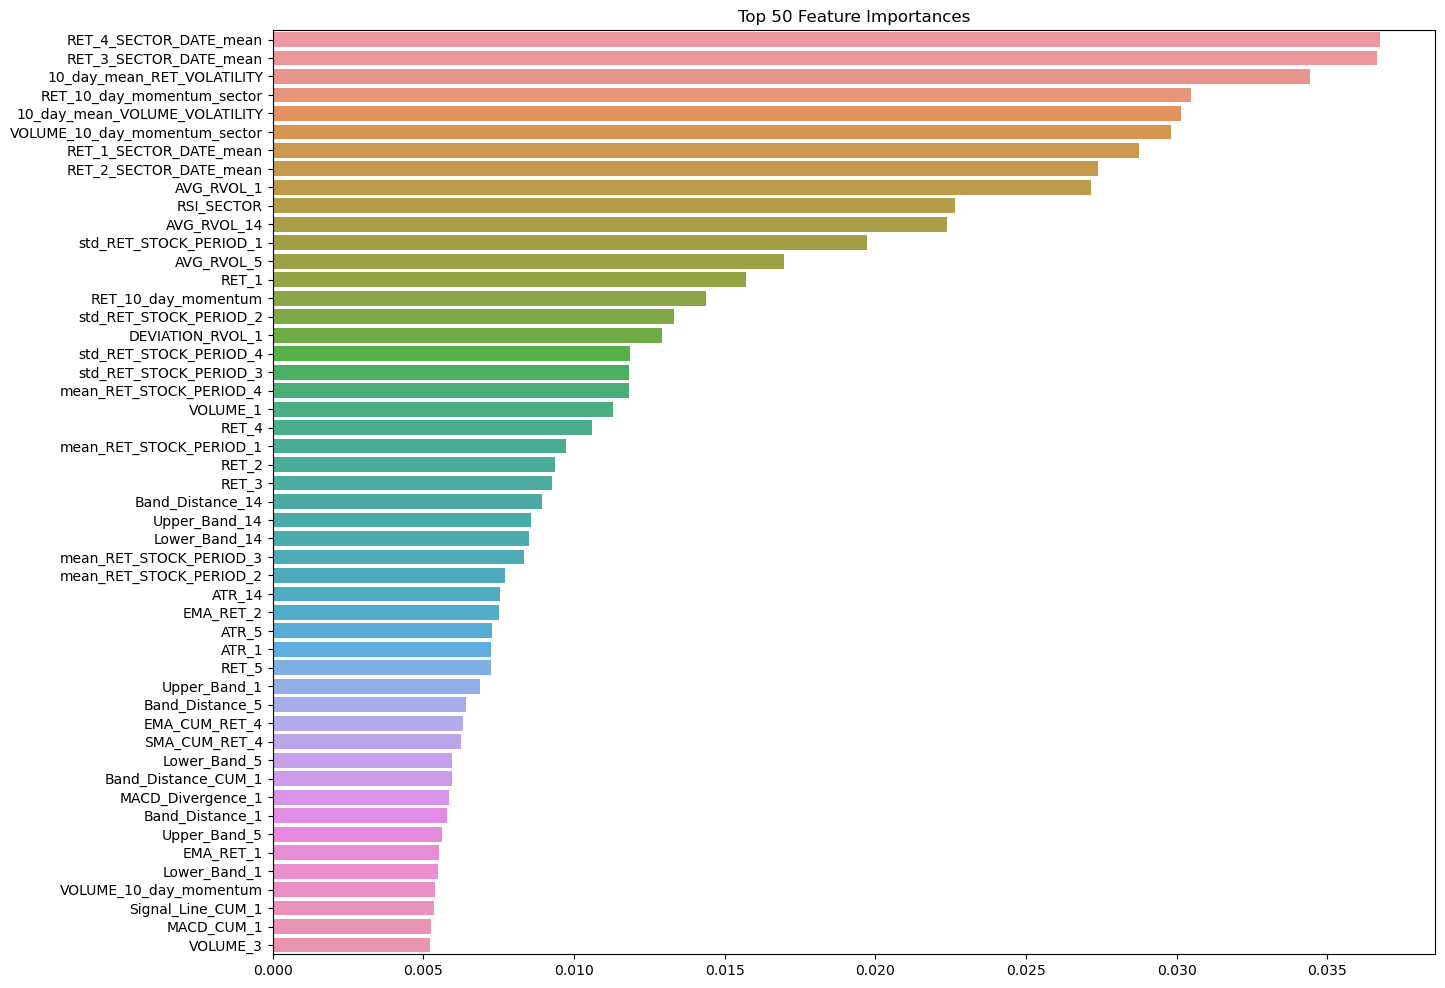

In [201]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model and 'features' is the list of feature names

# Combine feature importances from multiple models if you have an ensemble
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)

# Calculate mean feature importance and select top 50
mean_importances = feature_importances.mean(axis=0).sort_values(ascending=False).head(50)

# Plotting
plt.figure(figsize=(15, 12))
sns.barplot(x=mean_importances, y=mean_importances.index, orient='h', order=mean_importances.index)
plt.title('Top 50 Feature Importances')
plt.show()


# Prediction

In [202]:
test__ = pd.read_csv('x_test.csv', index_col='ID')

In [203]:
rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}

target = 'RET'
y_train = train[target]
X_train = train[features]
X_test = test[features]

model = RandomForestClassifier(**rf_params)
model.fit(X_train, y_train)

# Let's compare what to use as threshold.

sub = train.copy()
sub['pred'] = model.predict_proba(X_train)[:,1]
y_pred_train = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values
print('MEDIAN', accuracy_score(y_pred_train,y_train))

sub = train.copy()
sub['pred'] = model.predict_proba(X_train)[:,1]
y_pred_train = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.mean()).values
print('MEAN', accuracy_score(y_pred_train,y_train))

print('LIBRARY BUILT IN THRESHOLD 0.5', accuracy_score(model.predict(X_train),y_train))

y_pred = model.predict_proba(X_test)[:, 1]

sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test__.index
submission.name = target

submission.to_csv('./y_test.csv', index=True, header=True)

MEDIAN 0.5892025488844427
MEAN 0.589303428215949
LIBRARY BUILT IN THRESHOLD 0.5 0.5851505624022731


In [204]:
submission

ID
418595     True
418596    False
418597     True
418598     True
418599    False
          ...  
617019     True
617020     True
617021     True
617022    False
617023     True
Name: RET, Length: 198429, dtype: bool

# Submission to Leaderboard

This submission placed me in the 70th of 399 submissions.

In [205]:
rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}

target = 'RET'
y_train = train[target]
X_train = train[features]
X_test = test[features]

model = RandomForestClassifier(**rf_params)
model.fit(X_train, y_train)

sub = train.copy()
sub['pred'] = model.predict_proba(X_train)[:,1]
y_pred_train = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values
print(accuracy_score(y_pred_train,y_train))

y_pred = model.predict_proba(X_test)[:, 1]

sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test__.index
submission.name = target

submission.to_csv('./submission.csv', index=True, header=True)

0.5892025488844427


In [206]:
submission

ID
418595     True
418596    False
418597     True
418598     True
418599    False
          ...  
617019     True
617020     True
617021     True
617022    False
617023     True
Name: RET, Length: 198429, dtype: bool

Corresponding feature importances:

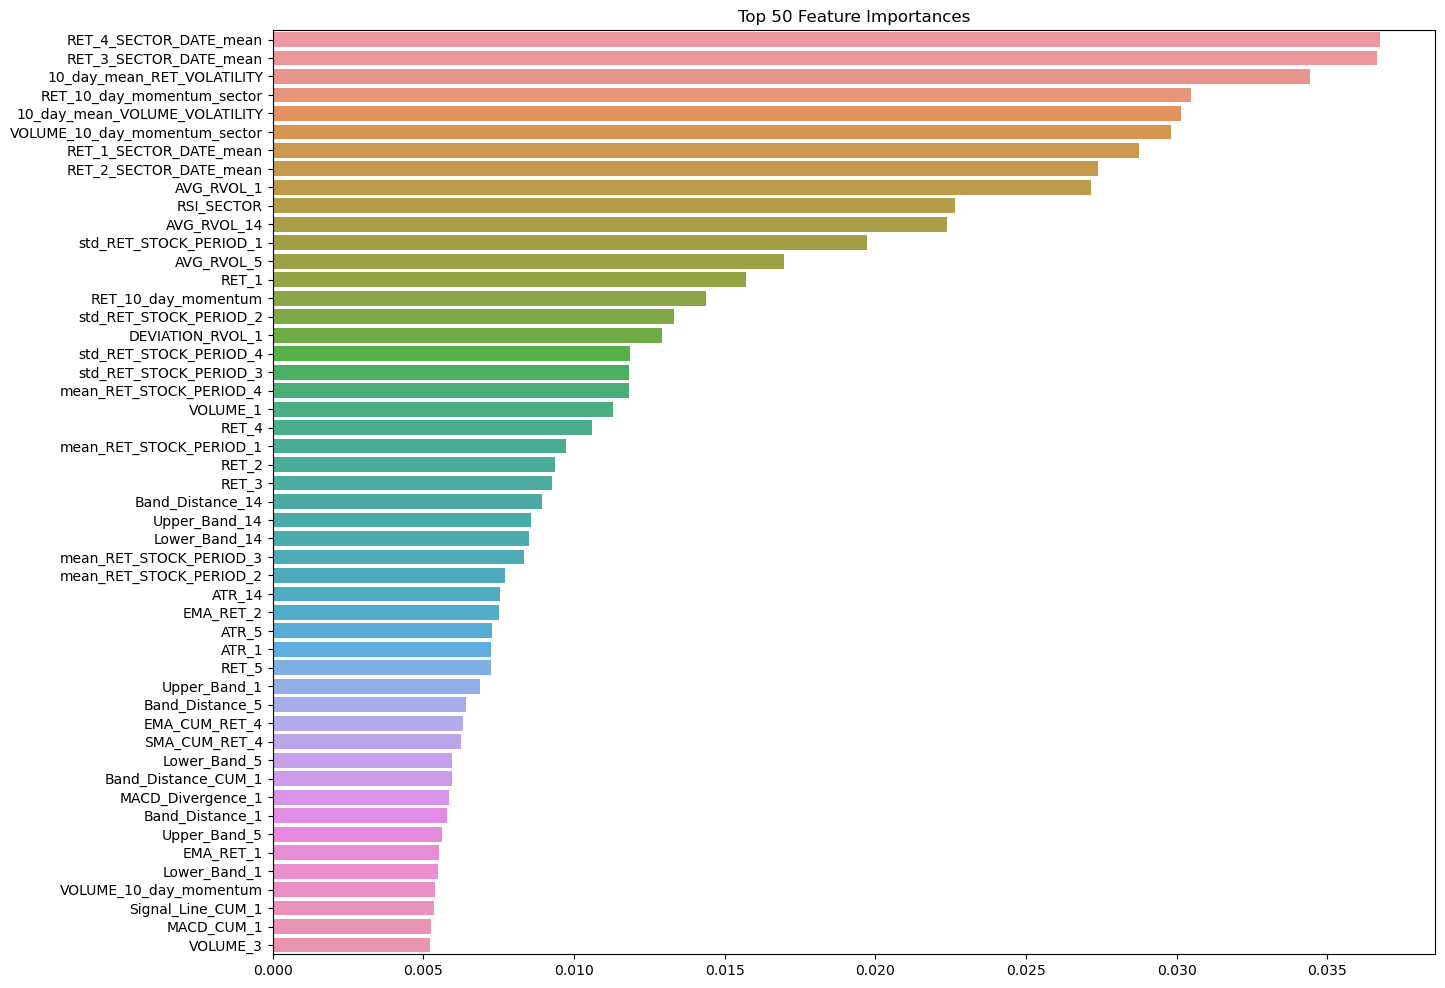

In [208]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Combine feature importances from multiple models if you have an ensemble
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)

# Calculate mean feature importance and select top 50
mean_importances = feature_importances.mean(axis=0).sort_values(ascending=False).head(50)

# Plotting
plt.figure(figsize=(15, 12))
sns.barplot(x=mean_importances, y=mean_importances.index, orient='h', order=mean_importances.index)
plt.title('Top 50 Feature Importances')
plt.show()


# Appendix

The following didn't help the prediction accuracy.

# PCA - Factors

### Explanation of PCA Application on Dataset

This script applies Principal Component Analysis (PCA) to the `train` and `test` datasets, specifically targeting the numerical columns (`RET` and `VOLUME` for the past 20 days). PCA is applied separately for each sector, both with and without whitening, to generate new features that capture the underlying variance in the data.

#### Principal Component Analysis (PCA)

**What is PCA?**

PCA is a dimensionality reduction technique that transforms a large set of variables into a smaller one that still contains most of the information in the large set. This is achieved by identifying the directions (principal components) along which the variation in the data is maximal.

**Intuitive Explanation:**

- **Principal Components (PCs)**: These are new axes that represent directions of maximum variance in the data. The first principal component accounts for the most variance, the second for the next most, and so on.
- **Dimensionality Reduction**: By transforming data into a smaller number of principal components, PCA reduces complexity and noise while preserving the essential patterns in the data.

**Mathematical Explanation:**

1. **Standardization**:
   - **Purpose**: To standardize the data to have a mean of 0 and a standard deviation of 1.
   - **Formula**: 
     $$ z = \frac{(x - \mu)}{\sigma} $$
   - Where \( \mu \) is the mean and \( \sigma \) is the standard deviation.

2. **Covariance Matrix**:
   - **Purpose**: To understand how variables in the data set vary together.
   - **Formula**:
     $$ \Sigma = \frac{1}{n-1} \sum_{i=1}^{n} (X_i - \mu)(X_i - \mu)^T $$
   - Where \( X_i \) is the vector of the \( i \)-th observation.

3. **Eigen Decomposition**:
   - **Purpose**: To find the principal components, which are the eigenvectors of the covariance matrix.
   - **Formula**:
     $$ \Sigma \mathbf{v} = \lambda \mathbf{v} $$
   - Where \( \mathbf{v} \) are the eigenvectors (principal components) and \( \lambda \) are the eigenvalues (variance explained by each principal component).

4. **Projection onto Principal Components**:
   - **Purpose**: To transform the data onto the new axes defined by the principal components.
   - **Formula**:
     $$ Z = X \cdot W $$
   - Where \( X \) is the standardized data matrix and \( W \) is the matrix of eigenvectors.

5. **Whitening**:
   - **Purpose**: To transform the principal components to have unit variance.
   - **Formula**:
     $$ Z_{\text{white}} = Z \cdot D^{-1/2} $$
   - Where \( D \) is the diagonal matrix of eigenvalues.

**Why Use PCA?**

- **Noise Reduction**: By focusing on the main components that explain the most variance, PCA helps reduce noise in the data.
- **Feature Extraction**: PCA generates new features (principal components) that may be more effective for predictive modeling.
- **Data Compression**: Reduces the dimensionality of the data, making it easier and faster to process.

**Why Use PCA Here?**

In this context, PCA is used to:
- Extract meaningful patterns from the historical return (`RET`) and volume (`VOLUME`) data for stocks.
- Reduce the complexity of the dataset by summarizing the information from 40 numerical columns into fewer principal components.
- Enhance the dataset with new features that capture the underlying variance, potentially improving the performance of machine learning models.




In [211]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

test_ = test.copy(deep=True)
train_ = train.copy(deep=True)

# Function to apply PCA to each group with a given whiten parameter and specified number of components
def apply_pca_to_group(group, numerical_cols, n_components=20, whiten=False):
    try:
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(group[numerical_cols])
        pca = PCA(n_components=n_components, whiten=whiten)
        principal_components = pca.fit_transform(scaled_data)
        # Create a DataFrame with the principal components
        suffix = 'W' if whiten else 'NW'
        pc_df = pd.DataFrame(data=principal_components, columns=[f'PC_{suffix}_{i+1}' for i in range(principal_components.shape[1])], index=group.index)
        return pc_df, pc_df.columns.tolist()
    except Exception as e:
        print(f"Error in group {group.name}: {e}")
        return pd.DataFrame(index=group.index), []

# Function to process the dataset
def process_dataset(df, numerical_cols, n_components=20):
    # Perform PCA without whitening
    df_pca_list = df.groupby('SECTOR').apply(lambda group: apply_pca_to_group(group, numerical_cols, n_components=n_components, whiten=False))
    df_pca = pd.concat([x[0] for x in df_pca_list], axis=0)
    new_variables = list({var for x in df_pca_list for var in x[1]})

    # Perform PCA with whitening
    df_pca_list_whiten = df.groupby('SECTOR').apply(lambda group: apply_pca_to_group(group, numerical_cols, n_components=n_components, whiten=True))
    df_pca_whiten = pd.concat([x[0] for x in df_pca_list_whiten], axis=0)
    new_variables_whiten = list({var for x in df_pca_list_whiten for var in x[1]})

    # Combine the two PCA results directly into the original DataFrame
    df_pca_combined = pd.concat([df_pca, df_pca_whiten[new_variables_whiten]], axis=1)

    return df_pca_combined, new_variables, new_variables_whiten

# Define numerical columns for PCA
numerical_cols = [f'RET_{i}' for i in range(1, 21)] + [f'VOLUME_{i}' for i in range(1, 21)]


# Process train_ dataset
train_pca_combined, train_new_variables, train_new_variables_whiten = process_dataset(train_, numerical_cols, n_components=20)
print("List of new variables for train (whiten=False):", train_new_variables)
print("List of new variables for train (whiten=True):", train_new_variables_whiten)

# Fill NaN values with the median for train_pca_combined
for col in train_new_variables:
    train_pca_combined[col].fillna(train_pca_combined[col].median(), inplace=True)

for col in train_new_variables_whiten:
    train_pca_combined[col].fillna(train_pca_combined[col].median(), inplace=True)

# Process test_ dataset
test_pca_combined, test_new_variables, test_new_variables_whiten = process_dataset(test_, numerical_cols, n_components=20)
print("List of new variables for test (whiten=False):", test_new_variables)
print("List of new variables for test (whiten=True):", test_new_variables_whiten)

# Fill NaN values with the median for test_pca_combined
for col in test_new_variables:
    test_pca_combined[col].fillna(test_pca_combined[col].median(), inplace=True)

for col in test_new_variables_whiten:
    test_pca_combined[col].fillna(test_pca_combined[col].median(), inplace=True)

# Ensure original columns do not get duplicated by merging only new PC columns
train_pca_combined = train_pca_combined[train_new_variables + train_new_variables_whiten]
test_pca_combined = test_pca_combined[test_new_variables + test_new_variables_whiten]

# Merge the PCA results back to the original train and test datasets
train = train.join(train_pca_combined, how='left')
test = test.join(test_pca_combined, how='left')

# Fill any remaining NaN values in the merged datasets
for col in train_new_variables + train_new_variables_whiten:
    train[col].fillna(train[col].median(), inplace=True)

for col in test_new_variables + test_new_variables_whiten:
    test[col].fillna(test[col].median(), inplace=True)



/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/976284888.py:27: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/976284888.py:32: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/976284888.py:52: FutureWarning:

A value is trying to be set on a copy of a DataFrame or 

List of new variables for train (whiten=False): ['PC_NW_13', 'PC_NW_16', 'PC_NW_7', 'PC_NW_9', 'PC_NW_11', 'PC_NW_14', 'PC_NW_18', 'PC_NW_10', 'PC_NW_3', 'PC_NW_4', 'PC_NW_15', 'PC_NW_12', 'PC_NW_17', 'PC_NW_20', 'PC_NW_6', 'PC_NW_5', 'PC_NW_1', 'PC_NW_8', 'PC_NW_2', 'PC_NW_19']
List of new variables for train (whiten=True): ['PC_W_3', 'PC_W_17', 'PC_W_10', 'PC_W_12', 'PC_W_14', 'PC_W_13', 'PC_W_1', 'PC_W_6', 'PC_W_4', 'PC_W_16', 'PC_W_9', 'PC_W_2', 'PC_W_20', 'PC_W_8', 'PC_W_11', 'PC_W_5', 'PC_W_15', 'PC_W_19', 'PC_W_7', 'PC_W_18']


/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/976284888.py:55: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/976284888.py:27: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to sile

List of new variables for test (whiten=False): ['PC_NW_13', 'PC_NW_16', 'PC_NW_7', 'PC_NW_9', 'PC_NW_11', 'PC_NW_14', 'PC_NW_18', 'PC_NW_10', 'PC_NW_3', 'PC_NW_4', 'PC_NW_15', 'PC_NW_12', 'PC_NW_17', 'PC_NW_20', 'PC_NW_6', 'PC_NW_5', 'PC_NW_1', 'PC_NW_8', 'PC_NW_2', 'PC_NW_19']
List of new variables for test (whiten=True): ['PC_W_3', 'PC_W_17', 'PC_W_10', 'PC_W_12', 'PC_W_14', 'PC_W_13', 'PC_W_1', 'PC_W_6', 'PC_W_4', 'PC_W_16', 'PC_W_9', 'PC_W_2', 'PC_W_20', 'PC_W_8', 'PC_W_11', 'PC_W_5', 'PC_W_15', 'PC_W_19', 'PC_W_7', 'PC_W_18']


/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/976284888.py:79: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/976284888.py:82: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

In [212]:
train[train_new_variables]


PC_NW_13  PC_NW_16   PC_NW_7   PC_NW_9  PC_NW_11  PC_NW_14  PC_NW_18  \
0      -0.660452  0.798375  1.046633 -2.267577  0.002126  1.484426  2.241052   
1       0.415816 -1.556211  0.030664 -1.253242  1.766904  0.008103  0.458241   
2      -0.260862  0.492219  0.284884  0.777805 -0.253205  0.768314  0.853039   
3       0.622444 -0.504758 -0.309812  0.859905 -0.411984 -0.341207  0.390676   
4      -1.386900  3.346928  0.980387 -0.833116 -1.554998  1.841378 -0.821970   
...          ...       ...       ...       ...       ...       ...       ...   
416334 -0.125915 -0.864976 -0.205819  0.196653  1.127093 -0.136617 -1.185492   
416335  0.145138  0.478868 -0.641925 -0.338856 -0.723382  0.326722  0.676061   
416336 -3.150435 -0.832151 -1.083782 -1.387896 -0.430802  0.314811  1.861702   
416337  0.626513 -1.212833  0.461503  0.777954  1.296513 -0.795581 -1.287079   
416338 -1.284759 -0.943852 -0.398390 -0.003700  1.669199 -0.062125 -0.818566   

        PC_NW_10   PC_NW_3   PC_NW_4  PC_NW_15  PC_NW_12  PC_NW_17  PC_NW_20  \
0       0.979146  2.424822 -1.832823 -1.345023  2.315907 -0.215871  0.114291   
1      -1.266027 -0.069590 -0.408588  1.597317  1.412250 -0.918006 -0.470945   
2       0.738802 -0.424545 -0.312561 -0.894298  0.553743  0.103104  0.518488   
3       0.386845 -0.212680 -0.585753  0.818527  0.165764 -0.766409  0.001807   
4      -2.433971 -4.388268  3.580651  1.857404 -0.515983 -0.446267  1.142911   
...          ...       ...       ...       ...       ...       ...       ...   
416334 -0.206930 -0.392787  0.541493 -0.681830 -0.474740  0.381337  0.045961   
416335  0.453096  1.944599 -0.368594 -0.317012  0.348373  0.555735  0.172725   
416336 -1.069213 -0.333941  0.233735  0.019542  0.048889  0.669638  0.418991   
416337 -0.211421  0.073829  1.286051 -0.185523  0.108560  0.209730 -0.073126   
416338 -1.901847  0.928945 -0.843207  0.818860 -0.929355 -0.752173 -1.667659   

         PC_NW_6   PC_NW_5   PC_NW_1   PC_NW_8   PC_NW_2  PC_NW_19  
0      -3.150003 -1.463505  0.894128  2.587894 -2.261943  1.537308  
1      -1.418082  1.193372 -0.390604  1.266024 -0.104538  0.378856  
2      -0.218663 -0.002303 -0.206423  0.436175 -0.219445  0.419948  
3       0.283630  1.107260 -1.348947  0.609515 -0.295116 -0.623158  
4       0.531937  1.456076  2.544972 -0.005817  1.631723  1.399142  
...          ...       ...       ...       ...       ...       ...  
416334  0.453702 -0.381365 -0.004524 -0.034199  0.171275 -1.033664  
416335  0.261290  0.034057 -0.534825 -0.270953 -0.261940 -0.049930  
416336 -0.048210 -0.420748  0.584843  1.396451  3.007618  1.075664  
416337  0.554202 -0.403173 -0.374344  0.221934 -0.166079 -1.370497  
416338 -0.197542  0.039633  7.626384  0.013564 -1.813272 -0.177253  

[416339 rows x 20 columns]

In [213]:
train[train_new_variables_whiten].isna().sum()

PC_W_3     0
PC_W_17    0
PC_W_10    0
PC_W_12    0
PC_W_14    0
PC_W_13    0
PC_W_1     0
PC_W_6     0
PC_W_4     0
PC_W_16    0
PC_W_9     0
PC_W_2     0
PC_W_20    0
PC_W_8     0
PC_W_11    0
PC_W_5     0
PC_W_15    0
PC_W_19    0
PC_W_7     0
PC_W_18    0
dtype: int64

In [214]:
new_features.extend(train_new_variables_whiten)


In [215]:
new_features

['RSI',
 'overbought_rsi',
 'oversold_rsi',
 'RSI_SECTOR',
 'overbought_rsi_sector',
 'oversold_rsi_sector',
 'ROC_1',
 'ROC_5',
 'ROC_14',
 'RET_10_day_momentum',
 'VOLUME_10_day_momentum',
 'RET_10_day_momentum_sector',
 'VOLUME_10_day_momentum_sector',
 '%K_1',
 '%D_1',
 '%K_5',
 '%D_5',
 '%K_14',
 '%D_14',
 'MACD_1',
 'Signal_Line_1',
 'MACD_Divergence_1',
 'MACD_5',
 'Signal_Line_5',
 'MACD_Divergence_5',
 'MACD_14',
 'Signal_Line_14',
 'MACD_Divergence_14',
 'Golden_Cross_1',
 'Upper_Band_1',
 'Lower_Band_1',
 'Band_Distance_1',
 'Upper_Band_5',
 'Lower_Band_5',
 'Band_Distance_5',
 'Upper_Band_14',
 'Lower_Band_14',
 'Band_Distance_14',
 'Band_Distance_CUM_1',
 'Band_Distance_CUM_5',
 'Band_Distance_CUM_14',
 'MFI_1',
 'overbought_mfi_1',
 'oversold_mfi_1',
 'MFI_10',
 'overbought_mfi_10',
 'oversold_mfi_10',
 'MFI_20',
 'overbought_mfi_20',
 'oversold_mfi_20',
 'MFI_1_sector',
 'overbought_mfi_1_sector',
 'oversold_mfi_1_sector',
 'MFI_10_sector',
 'overbought_mfi_10_sector',
 

## Further look into factors

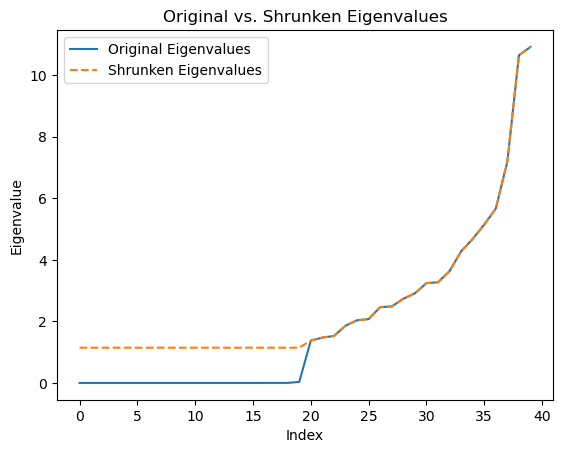

In [216]:
import numpy as np
import matplotlib.pyplot as plt

def optimal_shrinkage(cov_matrix):
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    n = len(eigenvalues)
    m = n - 5  # example choice, adjust as needed
    shrinkage_target = np.mean(eigenvalues[:m])
    shrunken_eigenvalues = np.maximum(eigenvalues, shrinkage_target)
    shrunken_cov_matrix = eigenvectors @ np.diag(shrunken_eigenvalues) @ eigenvectors.T
    return shrunken_cov_matrix, eigenvalues, shrunken_eigenvalues

# Example usage with sample data
np.random.seed(0)
sample_data = train_[numerical_cols]  # 100 samples, 20 features
cov_matrix = np.cov(sample_data, rowvar=False)
shrunken_cov_matrix, eigenvalues, shrunken_eigenvalues = optimal_shrinkage(cov_matrix)

# Plot original vs. shrunken eigenvalues
plt.plot(eigenvalues, label='Original Eigenvalues')
plt.plot(shrunken_eigenvalues, label='Shrunken Eigenvalues', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.legend()
plt.title('Original vs. Shrunken Eigenvalues')
plt.show()


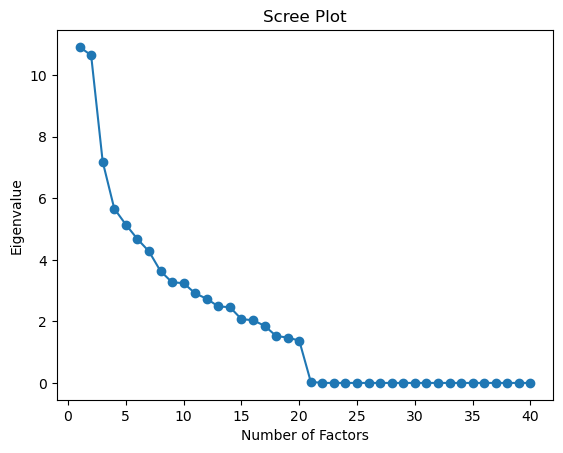

In [217]:
def choose_number_of_factors(eigenvalues):
    plt.plot(range(1, len(eigenvalues) + 1), sorted(eigenvalues, reverse=True), marker='o')
    plt.xlabel('Number of Factors')
    plt.ylabel('Eigenvalue')
    plt.title('Scree Plot')
    plt.show()

# Example usage with sample data
choose_number_of_factors(eigenvalues)


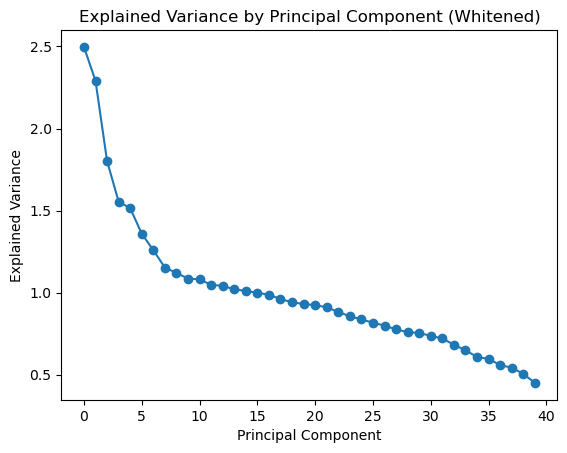

In [218]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def whiten_data(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    pca = PCA(whiten=True)
    whitened_data = pca.fit_transform(scaled_data)
    return whitened_data, pca.explained_variance_

# Example usage with sample data
whitened_data, explained_variance = whiten_data(sample_data)

# Plot explained variance
plt.plot(explained_variance, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Principal Component (Whitened)')
plt.show()


# Beta

### Explanation of Beta Calculation and Integration into Dataset

#### What is Beta?

**Beta** is a measure of a stock's volatility in relation to the overall market. It quantifies the tendency of a stock's returns to respond to swings in the market. A beta value can provide insights into a stock's risk profile compared to the market.

- **Beta > 1**: Indicates that the stock is more volatile than the market.
- **Beta < 1**: Indicates that the stock is less volatile than the market.
- **Beta = 1**: Indicates that the stock's volatility is similar to the market.

#### Mathematical Explanation

**Beta Calculation** involves the following steps:

1. **Covariance**: Measures how two variables (stock returns and market returns) move together.
   - **Formula**:
     $$ \text{Cov}(\text{Stock Returns}, \text{Market Returns}) = \frac{1}{n-1} \sum_{i=1}^{n} (R_{\text{stock}, i} - \overline{R}_{\text{stock}})(R_{\text{market}, i} - \overline{R}_{\text{market}}) $$
   - Where \( R_{\text{stock}, i} \) and \( R_{\text{market}, i} \) are the returns of the stock and market at time \( i \), and \( \overline{R}_{\text{stock}} \) and \( \overline{R}_{\text{market}} \) are their mean returns.

2. **Variance**: Measures the dispersion of market returns.
   - **Formula**:
     $$ \text{Var}(\text{Market Returns}) = \frac{1}{n-1} \sum_{i=1}^{n} (R_{\text{market}, i} - \overline{R}_{\text{market}})^2 $$

3. **Beta**: The ratio of the covariance between the stock and market returns to the variance of the market returns.
   - **Formula**:
     $$ \beta = \frac{\text{Cov}(\text{Stock Returns}, \text{Market Returns})}{\text{Var}(\text{Market Returns})} $$

#### Why Use Beta?

**Risk Assessment**: Beta provides a measure of a stock's risk in relation to the market. It helps investors understand how much a stock is expected to move relative to market movements.

**Portfolio Management**: By knowing the beta of individual stocks, investors can construct portfolios with desired risk profiles.

#### Overview of Implementation

1. **Loading Data**:
   - The script assumes that the `train_` and `test_` datasets are loaded from CSV files.

2. **Defining Numerical Columns**:
   - The numerical columns for stock returns are defined as `RET_1`, `RET_5`, and `RET_10`.

3. **Calculating Market Returns**:
   - Market returns are calculated by averaging the stock returns for each day across all stocks. This provides a benchmark for comparing individual stock performance.

4. **Function to Calculate Beta**:
   - A function `calculate_beta` is defined to calculate beta for each stock. It computes the covariance between stock returns and market returns and divides it by the variance of market returns.

5. **Calculating Beta Values**:
   - The script calculates beta values for `RET_1`, `RET_5`, and `RET_10` for both `train_` and `test_` datasets. This is done by grouping the data by stock and applying the `calculate_beta` function.

6. **Merging Beta Values**:
   - The calculated beta values are merged back into the original `train` and `test` datasets based on the `STOCK` column. New variables for beta values are added to the datasets.

7. **Handling NaN Values**:
   - Any NaN values in the new beta variables are filled with the median of the respective columns to ensure completeness of the data.

#### Summary

This process enhances the original dataset by adding new features that represent the beta values of the returns for different periods. Beta is a measure of volatility and risk relative to the market, providing valuable insights for financial analysis and modeling. By calculating and integrating these beta values, the dataset is enriched with features that capture the relationship between individual stocks and the overall market.


In [219]:
import pandas as pd
import numpy as np

# Load the separate datasets
# train_ = pd.read_csv("x_train.csv", index_col='ID')
# test_ = pd.read_csv('x_test.csv', index_col='ID')

# Define numerical columns for stock returns
numerical_cols = ['RET_1', 'RET_5', 'RET_10']

# Calculate market returns by averaging stock returns for each day
train_['MARKET_RET_1'] = train_[['RET_1']].mean(axis=1)
train_['MARKET_RET_5'] = train_[['RET_5']].mean(axis=1)
train_['MARKET_RET_10'] = train_[['RET_10']].mean(axis=1)

test_['MARKET_RET_1'] = test_[['RET_1']].mean(axis=1)
test_['MARKET_RET_5'] = test_[['RET_5']].mean(axis=1)
test_['MARKET_RET_10'] = test_[['RET_10']].mean(axis=1)

# Function to calculate beta
def calculate_beta(df, ret_col, market_col):
    betas = []
    for stock in df['STOCK'].unique():
        stock_df = df[df['STOCK'] == stock]
        market_returns = stock_df[market_col]
        stock_returns = stock_df[ret_col]
        cov = np.cov(stock_returns, market_returns)[0, 1]
        var = np.var(market_returns)
        beta = cov / var
        betas.append((stock, beta))
    beta_df = pd.DataFrame(betas, columns=['STOCK', f'BETA_{ret_col}'])
    return beta_df

# Calculate beta for RET_1, RET_5, and RET_10
train_beta_1 = calculate_beta(train_, 'RET_1', 'MARKET_RET_1')
train_beta_5 = calculate_beta(train_, 'RET_5', 'MARKET_RET_5')
train_beta_10 = calculate_beta(train_, 'RET_10', 'MARKET_RET_10')

test_beta_1 = calculate_beta(test_, 'RET_1', 'MARKET_RET_1')
test_beta_5 = calculate_beta(test_, 'RET_5', 'MARKET_RET_5')
test_beta_10 = calculate_beta(test_, 'RET_10', 'MARKET_RET_10')

# Initialize the new variables list
new_variables = []

# Merge beta values back to the original datasets and update new variables list
train = train.merge(train_beta_1, on='STOCK', how='left')
new_variables.append('BETA_RET_1')
train = train.merge(train_beta_5, on='STOCK', how='left')
new_variables.append('BETA_RET_5')
train = train.merge(train_beta_10, on='STOCK', how='left')
new_variables.append('BETA_RET_10')

test = test.merge(test_beta_1, on='STOCK', how='left')
test = test.merge(test_beta_5, on='STOCK', how='left')
test = test.merge(test_beta_10, on='STOCK', how='left')

new_variables.extend(['BETA_RET_1', 'BETA_RET_5', 'BETA_RET_10'])

# Fill NaN values with the median for the new beta variables in train and test datasets
for col in new_variables:
    train[col].fillna(train[col].median(), inplace=True)
    test[col].fillna(test[col].median(), inplace=True)

# Save the processed data
# train.to_csv("train_with_beta.csv", index=False)
# test.to_csv("test_with_beta.csv", index=False)

# Display the list of new variables
print("List of new variables:", new_variables)


/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/2151772959.py:27: RuntimeWarning:

Degrees of freedom <= 0 for slice

/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning:

divide by zero encountered in divide

/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning:

invalid value encountered in multiply



List of new variables: ['BETA_RET_1', 'BETA_RET_5', 'BETA_RET_10', 'BETA_RET_1', 'BETA_RET_5', 'BETA_RET_10']


/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/2151772959.py:62: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/69/1fq1s7q57p94wry3bjs7xq900000gp/T/ipykernel_85350/2151772959.py:63: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing

In [220]:
new_features.extend(new_variables)


In [221]:
train[new_variables].isna().sum()

BETA_RET_1     0
BETA_RET_5     0
BETA_RET_10    0
BETA_RET_1     0
BETA_RET_5     0
BETA_RET_10    0
dtype: int64

In [223]:
test[new_variables].isna().sum()

BETA_RET_1     0
BETA_RET_5     0
BETA_RET_10    0
BETA_RET_1     0
BETA_RET_5     0
BETA_RET_10    0
dtype: int64

In [226]:
# Define a function to print beta statistics
def print_beta_statistics(df, beta_cols):
    for col in beta_cols:
        greater_than_1 = df[df[col] > 1].shape[0]
        less_than_1 = df[df[col] < 1].shape[0]
        close_to_1 = df[(df[col] >= 0.98) & (df[col] <= 1.01)].shape[0]
        print(f"Statistics for {col}:")
        print(f"  Observations where {col} > 1: {greater_than_1}")
        print(f"  Observations where {col} < 1: {less_than_1}")
        print(f"  Observations where {col} ≈ 1: {close_to_1}\n")

In [227]:
# Print beta statistics for train dataset
print("Beta statistics for train dataset:")
print_beta_statistics(train, new_variables)

# Print beta statistics for test dataset
print("Beta statistics for test dataset:")
print_beta_statistics(test, new_variables)

Beta statistics for train dataset:
Statistics for BETA_RET_1:
  Observations where BETA_RET_1 > 1: 416339
  Observations where BETA_RET_1 < 1: 0
  Observations where BETA_RET_1 ≈ 1: 269814

Statistics for BETA_RET_5:
  Observations where BETA_RET_5 > 1: 416339
  Observations where BETA_RET_5 < 1: 0
  Observations where BETA_RET_5 ≈ 1: 270016

Statistics for BETA_RET_10:
  Observations where BETA_RET_10 > 1: 416339
  Observations where BETA_RET_10 < 1: 0
  Observations where BETA_RET_10 ≈ 1: 270016

Statistics for BETA_RET_1:
  Observations where BETA_RET_1 > 1: 416339
  Observations where BETA_RET_1 < 1: 0
  Observations where BETA_RET_1 ≈ 1: 269814

Statistics for BETA_RET_5:
  Observations where BETA_RET_5 > 1: 416339
  Observations where BETA_RET_5 < 1: 0
  Observations where BETA_RET_5 ≈ 1: 270016

Statistics for BETA_RET_10:
  Observations where BETA_RET_10 > 1: 416339
  Observations where BETA_RET_10 < 1: 0
  Observations where BETA_RET_10 ≈ 1: 270016

Beta statistics for test da

# Feature Selection

In [228]:
target = 'RET'

n_shifts_ret = 5  # If you don't want all the shifts to reduce noise
n_shifts_vol = 5
features = ['RET_%d' % (i + 1) for i in range(n_shifts_ret)]
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts_vol)]
features += new_features  # The conditional features
train[features].head()

RET_1     RET_2     RET_3     RET_4     RET_5  VOLUME_1  VOLUME_2  \
0 -0.015748 -0.015504  0.010972 -0.014672  0.016483  0.147931  0.179183   
1  0.003984 -0.090580  0.018826 -0.025540 -0.038062 -0.282609 -0.278437   
2  0.000440 -0.058896 -0.009042  0.024852  0.009354 -0.096282  0.084771   
3  0.031298  0.007756 -0.004632 -0.019677  0.003544 -0.429540 -0.089919   
4  0.027273 -0.039302  0.000000  0.000000  0.022321 -0.847155 -0.943033   

   VOLUME_3  VOLUME_4  VOLUME_5  ...   PC_W_15   PC_W_19    PC_W_7   PC_W_18  \
0  0.033832 -0.362868 -0.972920  ... -1.399369  1.220742  0.842144  0.845379   
1 -0.278277 -0.275435 -0.281238  ...  2.122397  0.174060 -0.001776  0.592675   
2 -0.298777 -0.157421  0.091455  ...  1.201413  0.737540 -0.285814 -0.948429   
3 -0.639737 -0.940163 -0.882464  ... -0.516028 -0.600731 -0.224852 -0.532213   
4 -1.180629 -1.313896 -1.204398  ...  0.654334  0.929633  1.073851  0.703163   

   BETA_RET_1  BETA_RET_5  BETA_RET_10  BETA_RET_1  BETA_RET_5  BETA_RET_10  
0    1.013333    1.013333     1.013333    1.013333    1.013333     1.013333  
1    1.019608    1.019608     1.019608    1.019608    1.019608     1.019608  
2    1.006494    1.006494     1.006494    1.006494    1.006494     1.006494  
3    1.006494    1.006494     1.006494    1.006494    1.006494     1.006494  
4    1.006803    1.006803     1.006803    1.006803    1.006803     1.006803  

[5 rows x 192 columns]

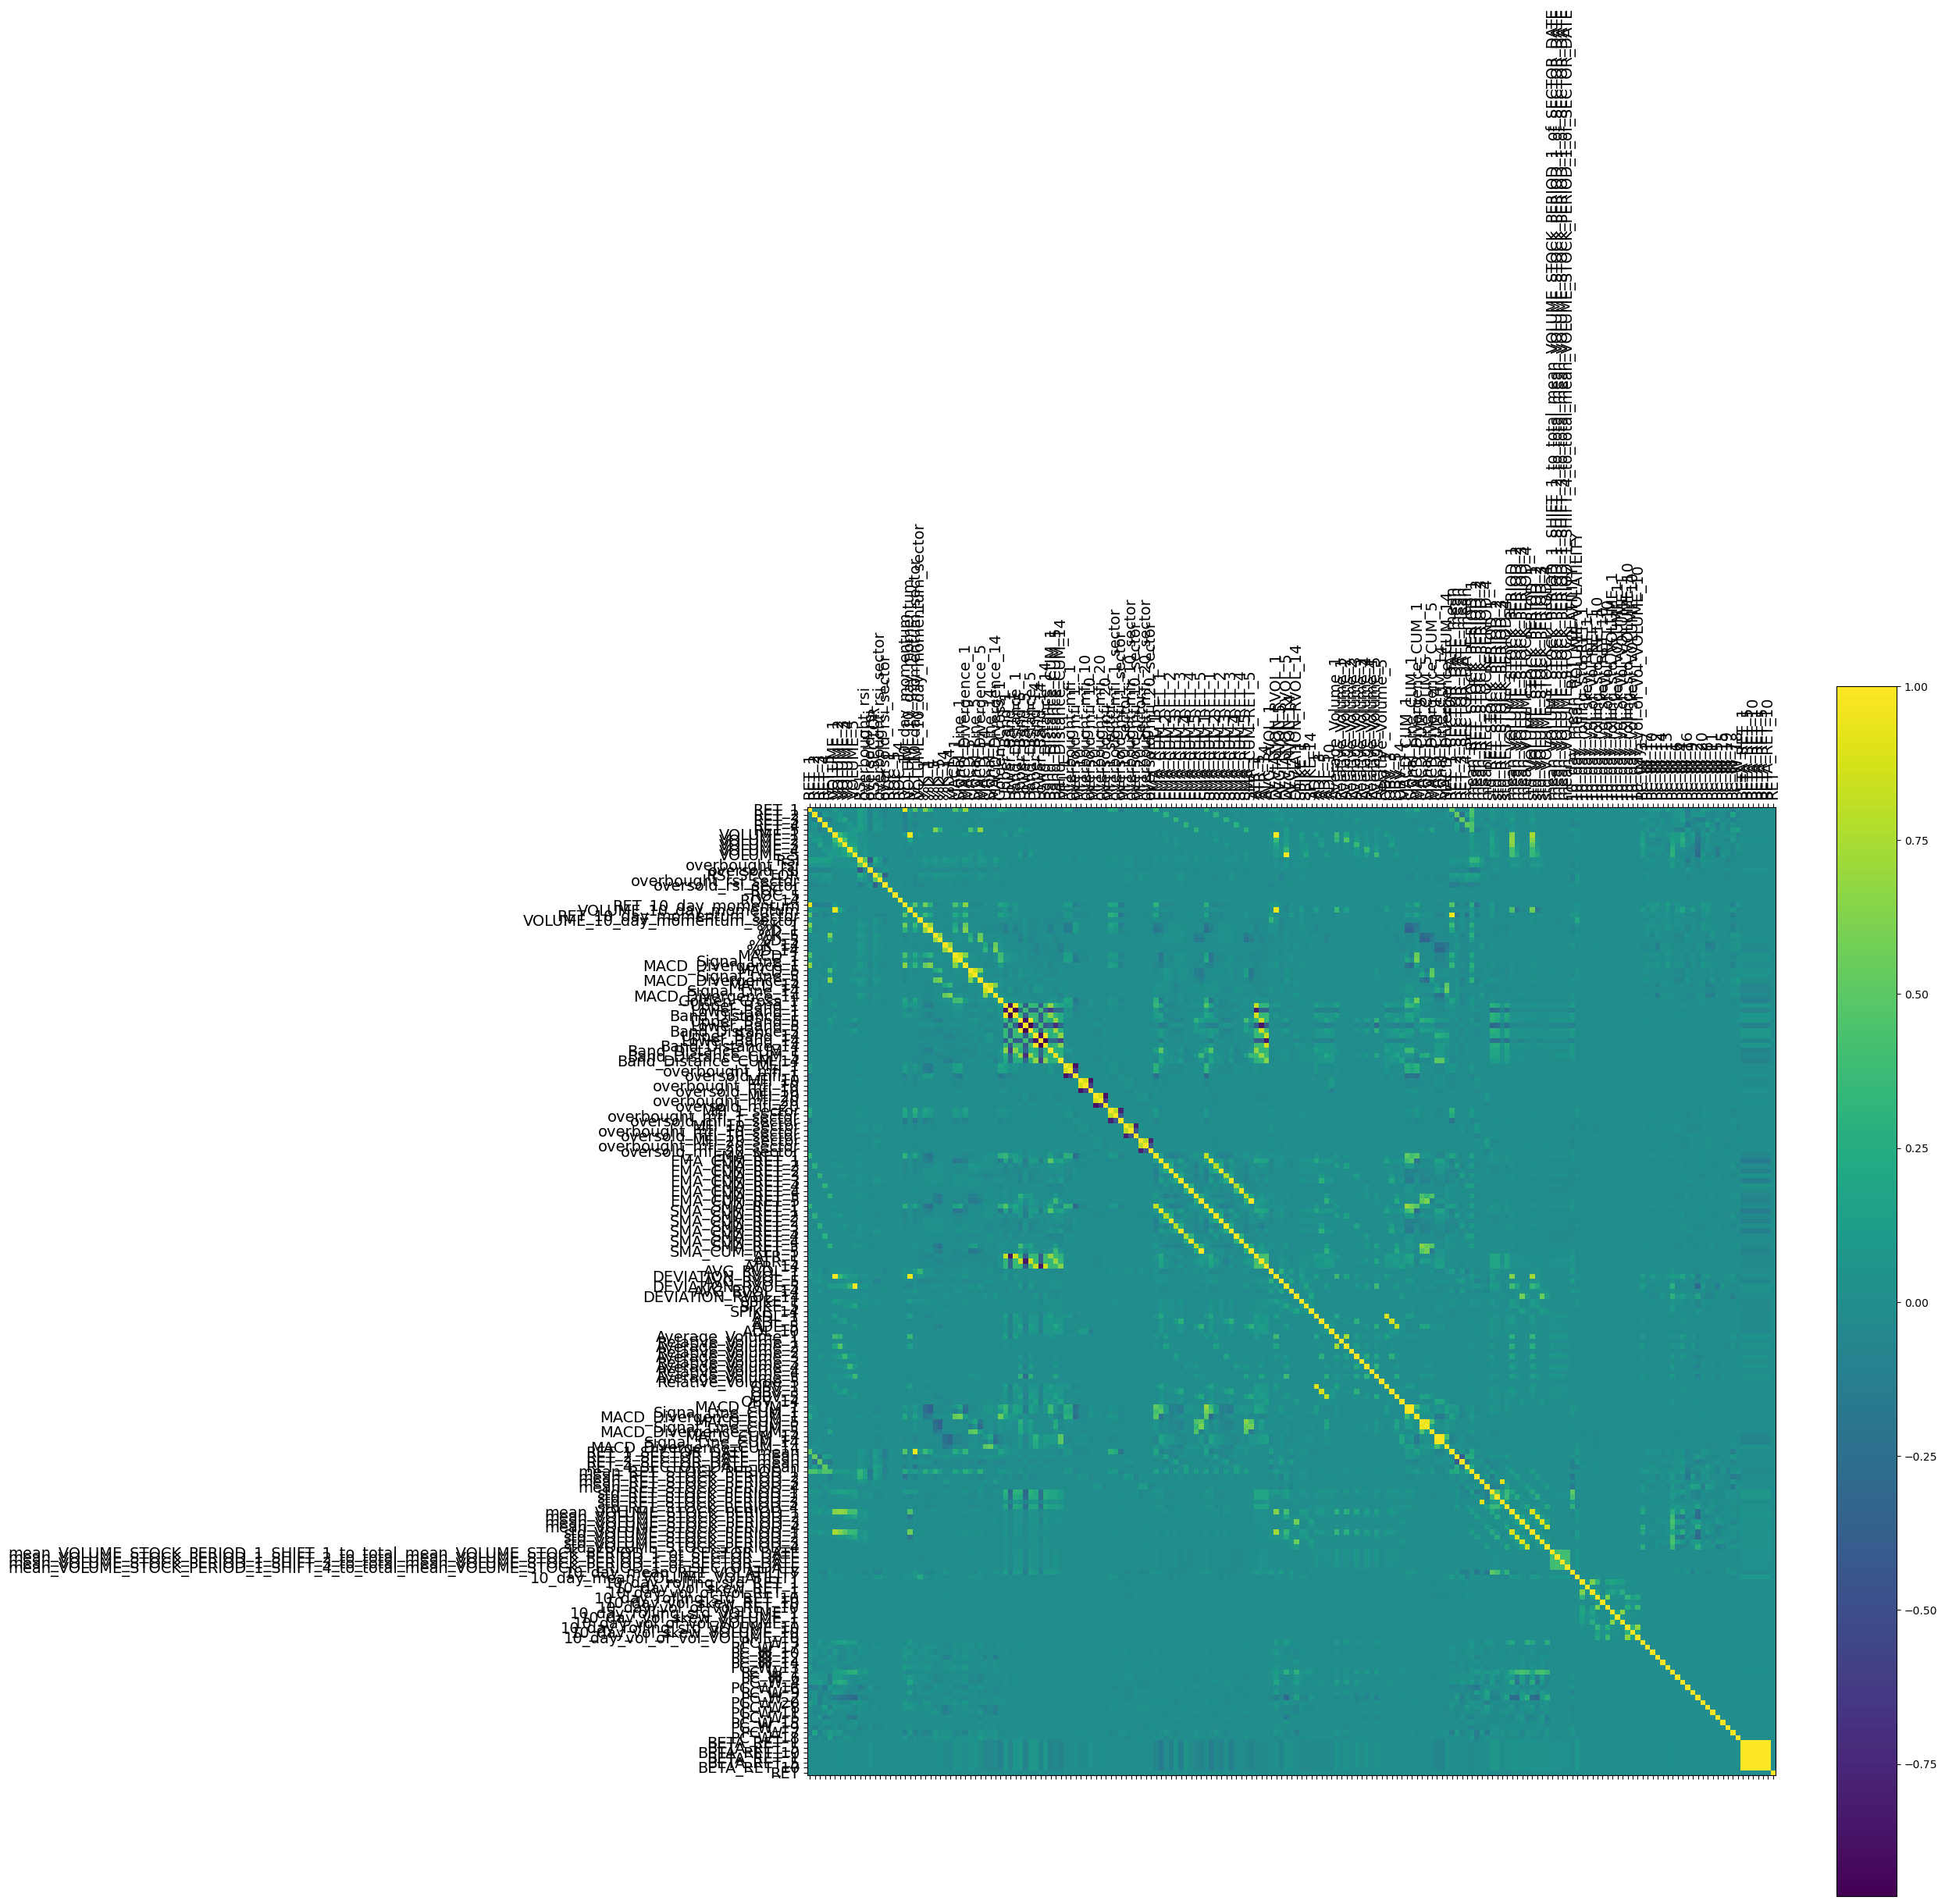

In [229]:
corr_features = features + ['RET']
fig = plt.figure(figsize=(20,20))
plt.matshow(train[corr_features].corr(), fignum=fig.number)
plt.xticks(range(train[corr_features].shape[1]), train[corr_features].columns, rotation=90, fontsize=14)
plt.yticks(range(train[corr_features].shape[1]), train[corr_features].columns, fontsize=14)
plt.colorbar()
plt.show()

In [230]:
import numpy as np

# Check for infinity values in the train dataset
inf_counts_train = np.isinf(train).sum()
inf_columns_train = inf_counts_train[inf_counts_train > 0]
inf_columns_train_list = inf_columns_train.index.tolist()
print("Columns with infinity values in the train dataset:")
print(inf_columns_train_list)

# Check for infinity values in the test dataset
inf_counts_test = np.isinf(test).sum()
inf_columns_test = inf_counts_test[inf_counts_test > 0]
inf_columns_test_list = inf_columns_test.index.tolist()
print("Columns with infinity values in the test dataset:")
print(inf_columns_test_list)

# Total infinity values in train and test datasets
total_inf_train = inf_columns_train.sum()
total_inf_test = inf_columns_test.sum()
print(f"Total infinity values in the train dataset: {total_inf_train}")
print(f"Total infinity values in the test dataset: {total_inf_test}")

# Combine the lists for further use if needed
inf_columns_combined_list = list(set(inf_columns_train_list + inf_columns_test_list))
print("Combined list of columns with infinity values:")
print(inf_columns_combined_list)

# Assuming features is your list of feature column names
features = [col for col in features if col not in inf_columns_combined_list]


Columns with infinity values in the train dataset:
['ROC_1', 'ROC_5', 'ROC_14', 'Money_Flow_Ratio_1', 'Money_Flow_Ratio_10', 'Money_Flow_Ratio_20', 'Money_Flow_Ratio_1_sector', 'Money_Flow_Ratio_10_sector', 'Money_Flow_Ratio_20_sector']
Columns with infinity values in the test dataset:
['ROC_1', 'ROC_5', 'ROC_14', 'Money_Flow_Ratio_1', 'Money_Flow_Ratio_10', 'Money_Flow_Ratio_20', 'Money_Flow_Ratio_1_sector', 'Money_Flow_Ratio_10_sector', 'Money_Flow_Ratio_20_sector']
Total infinity values in the train dataset: 43599
Total infinity values in the test dataset: 27248
Combined list of columns with infinity values:
['Money_Flow_Ratio_20_sector', 'ROC_5', 'Money_Flow_Ratio_1', 'Money_Flow_Ratio_10_sector', 'Money_Flow_Ratio_20', 'ROC_1', 'Money_Flow_Ratio_1_sector', 'Money_Flow_Ratio_10', 'ROC_14']


In [231]:
features

['RET_1',
 'RET_2',
 'RET_3',
 'RET_4',
 'RET_5',
 'VOLUME_1',
 'VOLUME_2',
 'VOLUME_3',
 'VOLUME_4',
 'VOLUME_5',
 'RSI',
 'overbought_rsi',
 'oversold_rsi',
 'RSI_SECTOR',
 'overbought_rsi_sector',
 'oversold_rsi_sector',
 'RET_10_day_momentum',
 'VOLUME_10_day_momentum',
 'RET_10_day_momentum_sector',
 'VOLUME_10_day_momentum_sector',
 '%K_1',
 '%D_1',
 '%K_5',
 '%D_5',
 '%K_14',
 '%D_14',
 'MACD_1',
 'Signal_Line_1',
 'MACD_Divergence_1',
 'MACD_5',
 'Signal_Line_5',
 'MACD_Divergence_5',
 'MACD_14',
 'Signal_Line_14',
 'MACD_Divergence_14',
 'Golden_Cross_1',
 'Upper_Band_1',
 'Lower_Band_1',
 'Band_Distance_1',
 'Upper_Band_5',
 'Lower_Band_5',
 'Band_Distance_5',
 'Upper_Band_14',
 'Lower_Band_14',
 'Band_Distance_14',
 'Band_Distance_CUM_1',
 'Band_Distance_CUM_5',
 'Band_Distance_CUM_14',
 'MFI_1',
 'overbought_mfi_1',
 'oversold_mfi_1',
 'MFI_10',
 'overbought_mfi_10',
 'oversold_mfi_10',
 'MFI_20',
 'overbought_mfi_20',
 'oversold_mfi_20',
 'MFI_1_sector',
 'overbought_mfi_1

# Model

In [232]:
X_train = train[features]
y_train = train[target]

# Choose parameters of the LGBM RF such that they coincide with the RandomForestClassifier 
parameters = {
    'boosting_type': 'rf',
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1, 
    'feature_fraction': np.log(X_train.shape[0])/X_train.shape[0],
    'objective': 'binary',
    'verbose': -1
}

rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates) # Generates the splits of the indexes to use as train / test

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]

    #model = LGBMClassifier(**parameters)
    model = RandomForestClassifier(**rf_params)
    model.fit(X_local_train, y_local_train.values.reshape(-1))

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = train.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 51.42%
Fold 2 - Accuracy: 50.97%
Fold 3 - Accuracy: 52.81%
Fold 4 - Accuracy: 52.32%
Accuracy: 51.88% [51.15 ; 52.60] (+- 0.72)


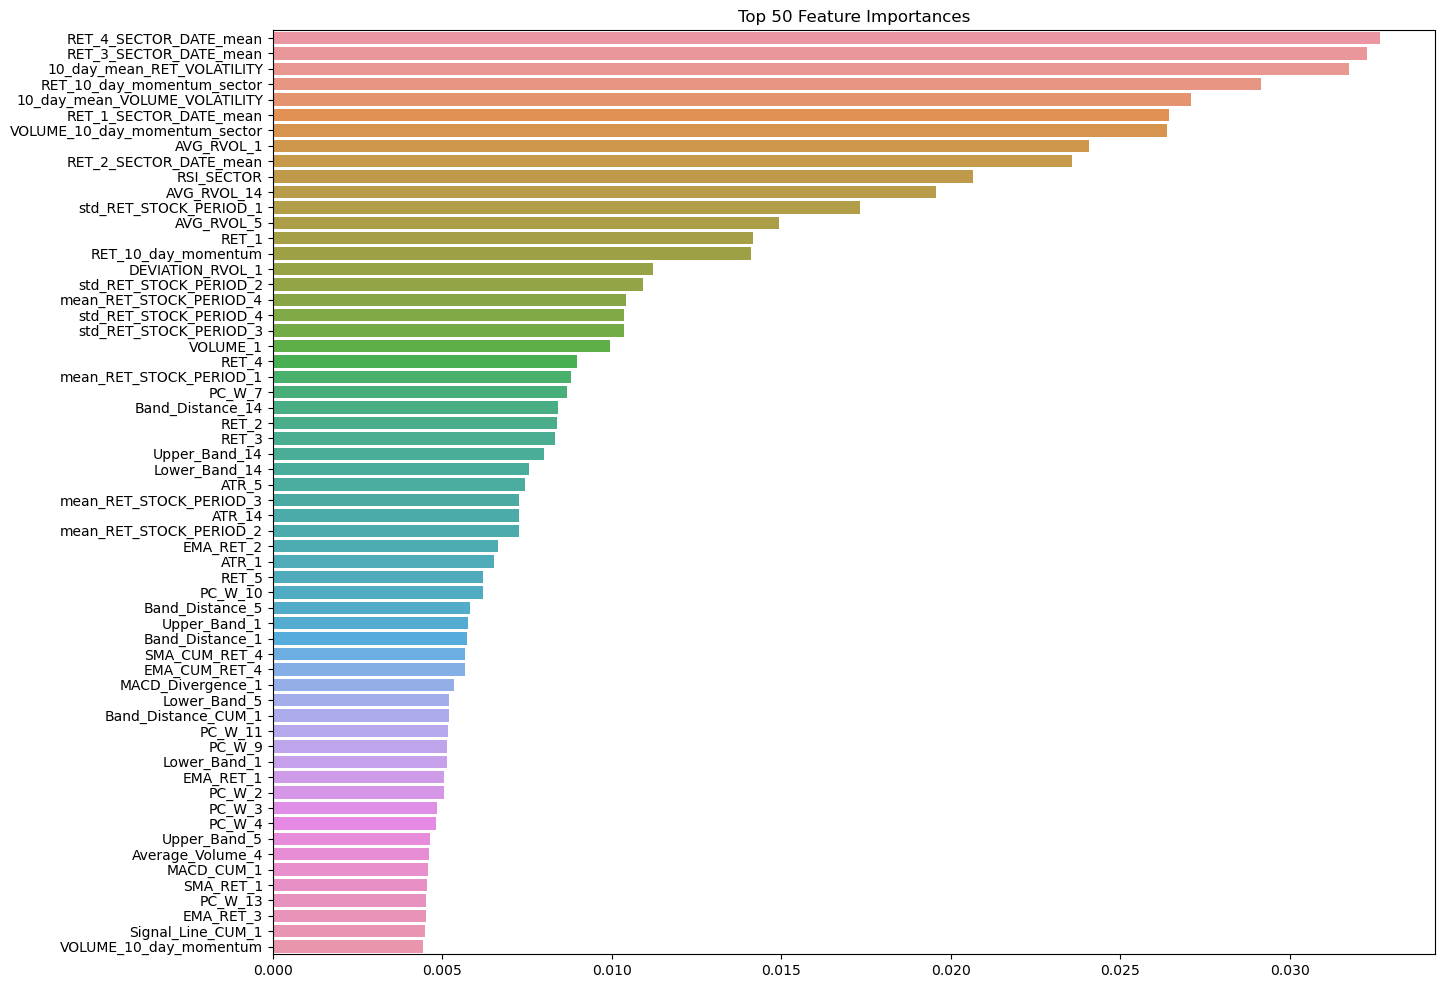

In [233]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model and 'features' is the list of feature names

# Combine feature importances from multiple models if you have an ensemble
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)

# Calculate mean feature importance and select top 50
mean_importances = feature_importances.mean(axis=0).sort_values(ascending=False).head(60)

# Plotting
plt.figure(figsize=(15, 12))
sns.barplot(x=mean_importances, y=mean_importances.index, orient='h', order=mean_importances.index)
plt.title('Top 50 Feature Importances')
plt.show()

**End of Notebook**